In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [2]:
!python -V

Python 3.10.8


In [3]:
from joblib import Parallel, delayed

In [4]:
from tqdm.notebook import tqdm

In [5]:
from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [6]:
np.finfo(float).eps

2.220446049250313e-16

In [9]:
nx = 1500+1
nz = 1000 +1
xmax = 500 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-4 # Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*xmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print(dx, dz, zmax)
print(1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print(pxmax,pzmax)

0.6666666666666666 1.0 333.4443704197202
0.00119077125j
299.67248816432607 299.7721463251281


In [189]:
wavelength = 1.083 #Micrometers
# k = 2*pi / wavelength
k = 0.15 * 2*pi / wavelength
p = hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

k = 0.8702472724625466 1/µm
p = 55.26748973009692 u*µm/ms
v = 13.81687243252423 µm/ms


In [190]:
a4 = 0.007512
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggCenter = 1
tBraggPi = np.sqrt(2*pi*hb)/V0
print(tBraggPi*1000,"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


15.727018740679478 µs


In [191]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max size of this thing")

1.5746097329776815e-06j term infront of Bragg potential
0.050733363643743784j max size of this thing


In [192]:
# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

##### Checking parameters reasonable

In [193]:
V0

1270.156

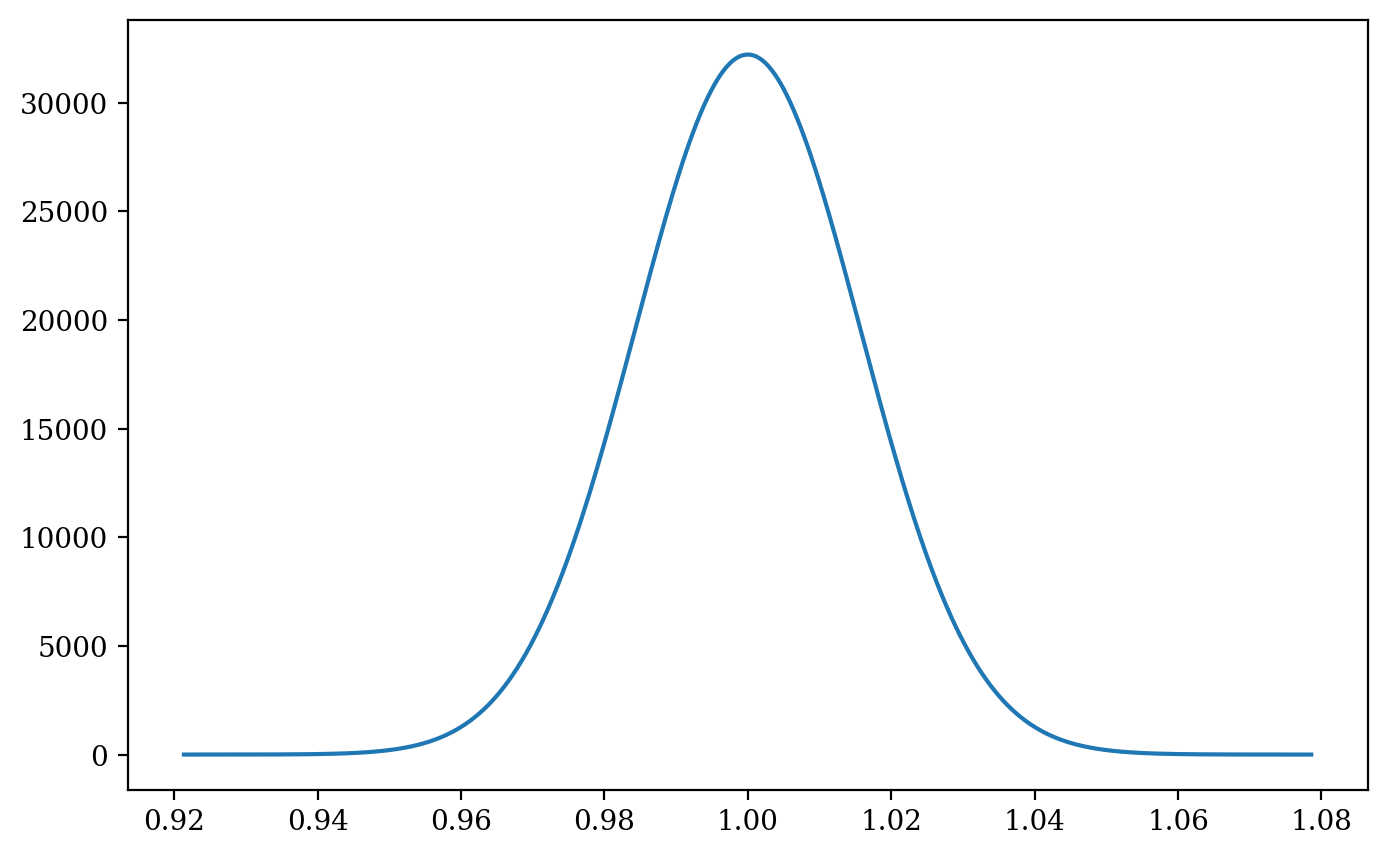

In [194]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [195]:
np.trapz(V(tbtest),tbtest)

1270.1552632290575

#### Initial State

In [196]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
# psi=np.zeros((nx,nz),dtype=complex)

zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)

print(nx**2/1000/1000,"million grid points")
print((nx**2)*0.001/60/60,"hours (for 1ms per operation)")

2.2530010000000003 million grid points
0.6258336111111112 hours (for 1ms per operation)


In [197]:
def plot_psi(psi):
    plt.figure(figsize=(12,6))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])*0.001
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (mm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [198]:
def plot_mom(psi):
    plt.figure(figsize=(3,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])
    psifft = np.fft.fftshift(np.fft.fft2(psi))
#     plotdata = ((np.abs(psifft)**2).T)[:,::-1] # weird flipping????
#     plotdata = ((np.abs(psifft)**2).T) # weird flipping????
    plotdata = np.flipud((np.abs(psifft)**2).T)
    plt.imshow(plotdata,extent=extent)
    plt.show()

In [199]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))

0.9999999999999997 normalisation check
24.040016 MB of data used


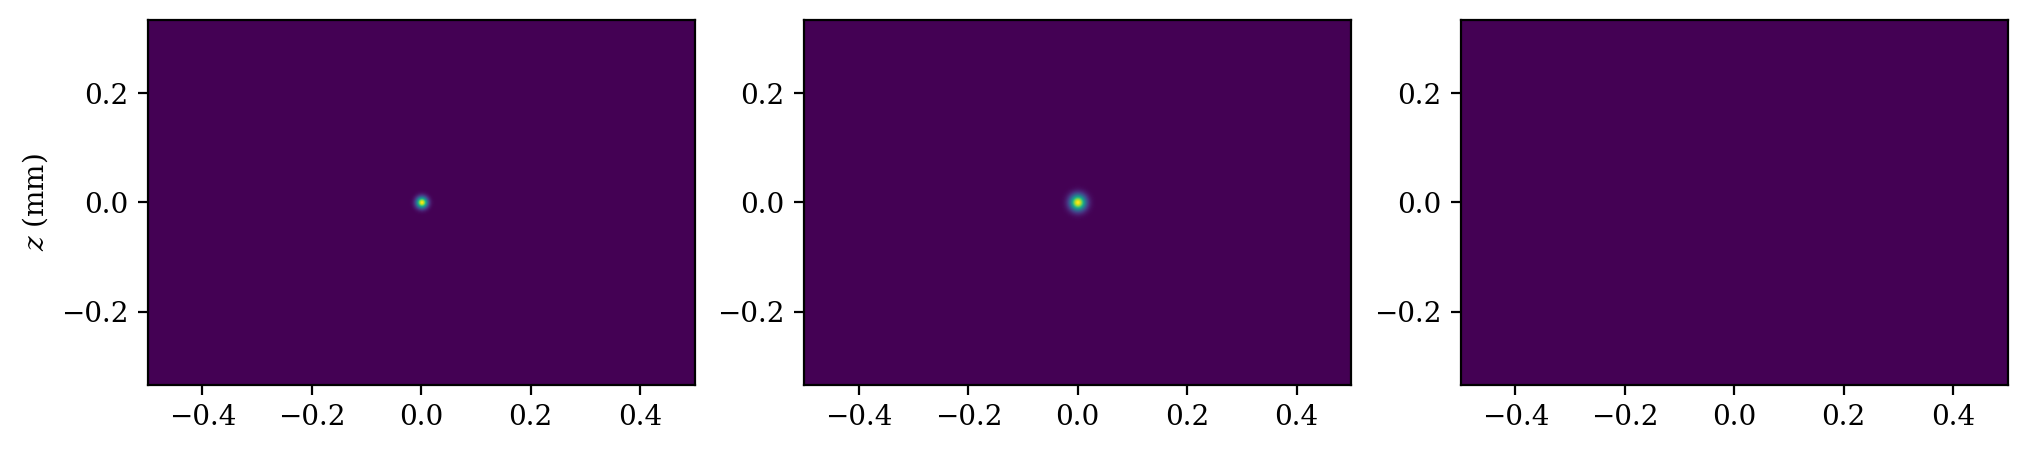

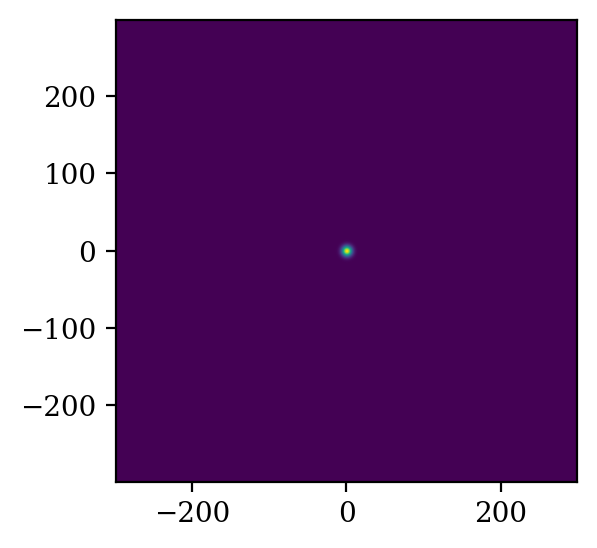

In [200]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
psi = psi0np(10,10,0,0)
t = 0

print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin), "normalisation check")
print(psi.nbytes/1000/1000, "MB of data used")
plot_psi(psi)
plot_mom(psi)

In [224]:
dt

0.0001

In [225]:
# @njit(parallel=True, fastmath=True)
@njit(parallel=True)
def runNB(psi,xgrid,t,V0,tBraggCenter,tBraggPi,steps=1000): # basically so that i can run this in a different cell and keep its output
#     set_parallel_chunksize(8)
    def V(t):
#         return 30000
        if abs(t-0.5) < 0.0010: return 50000; 
        else: return 0
#         return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)
#     V = lambda t : V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)
    
#     with parallel_chunksize(8):
    for step in range(steps):
        psi[1:-1,1:-1] += 1j*hb*dt/(2*m4*dx**2)*(\
                psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2] - 4*psi[1:-1,1:-1] )\
              - 1j*(dt/hb)*np.multiply( V(t)*np.cos(2*k*xgrid[1:-1,1:-1]), psi[1:-1,1:-1] )
        t += dt 
    return (t,psi)

In [217]:
runNB(psi,xgrid,t,V0,tBraggCenter,tBraggPi) # test run (sometimes this kills the kernel? don't know why)

(5.100000000001453,
 array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j, -3.22485486e-45-1.27891956e-44j,
          3.45194004e-45+4.41367188e-45j, ...,
          8.67447250e-45-1.13661586e-45j, -6.87815680e-45-2.45583156e-46j,
          0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j, -8.55042082e-45+7.11566247e-45j,
          2.89183321e-45-2.13905828e-45j, ...,
          8.16880591e-46-4.56634993e-45j, -2.34431412e-45+9.79839565e-45j,
          0.00000000e+00+0.00000000e+00j],
        ...,
        [ 0.00000000e+00+0.00000000e+00j,  1.24728212e-45-1.05982261e-44j,
         -4.78564907e-45-5.04738509e-46j, ...,
         -5.19570235e-45-8.84167256e-46j,  5.62730942e-45-1.18460146e-44j,
          0.00000000e+00+0.00000000e+00j],
       

In [226]:
def runNBWithPlots(psi=psi,t=0,endTMs=10, plotEveryMs=0.1):
    if t >= endTMs: return (t,psi)
    iterCount = int((endTMs-t) / plotEveryMs)
    print("Initial state at t =", round(t,4), "ms", "Target end time at ", round(endTMs,4), "ms")
    plot_psi(psi)
    plot_mom(psi)
    
    for step in tqdm(range(iterCount)):
        (t,psi) = runNB(psi,xgrid,t,V0,tBraggCenter,tBraggPi,int(plotEveryMs/dt))
        print("time =", round(t,4), "ms")
        print(np.sum(np.abs(psi)**2)*dx**2,"|psi|^2")
        plot_psi(psi)
        plot_mom(psi)
    return (t,psi)

Initial state at t = 0 ms Target end time at  1 ms


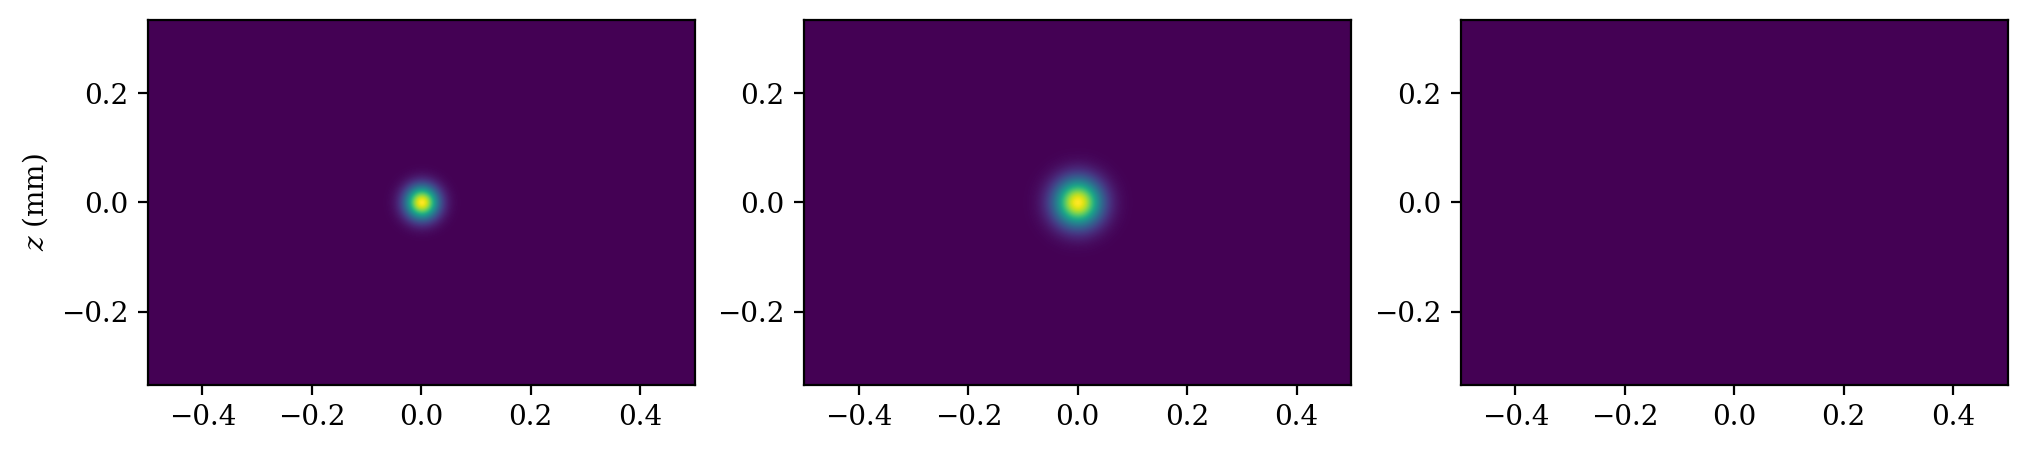

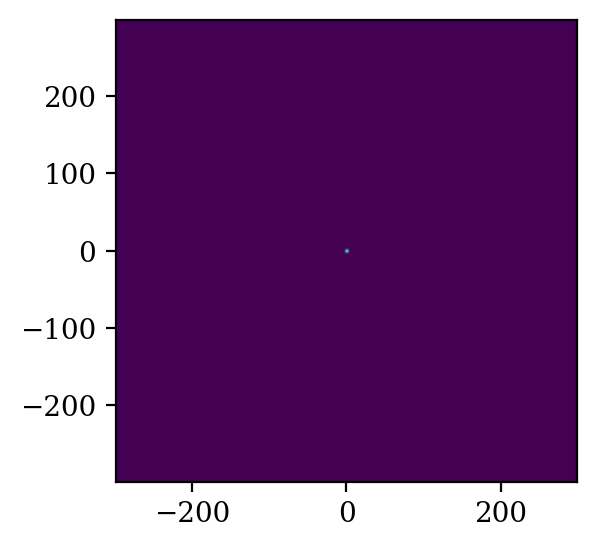

  0%|          | 0/5 [00:00<?, ?it/s]

time = 0.2 ms
0.9996670027795296 |psi|^2


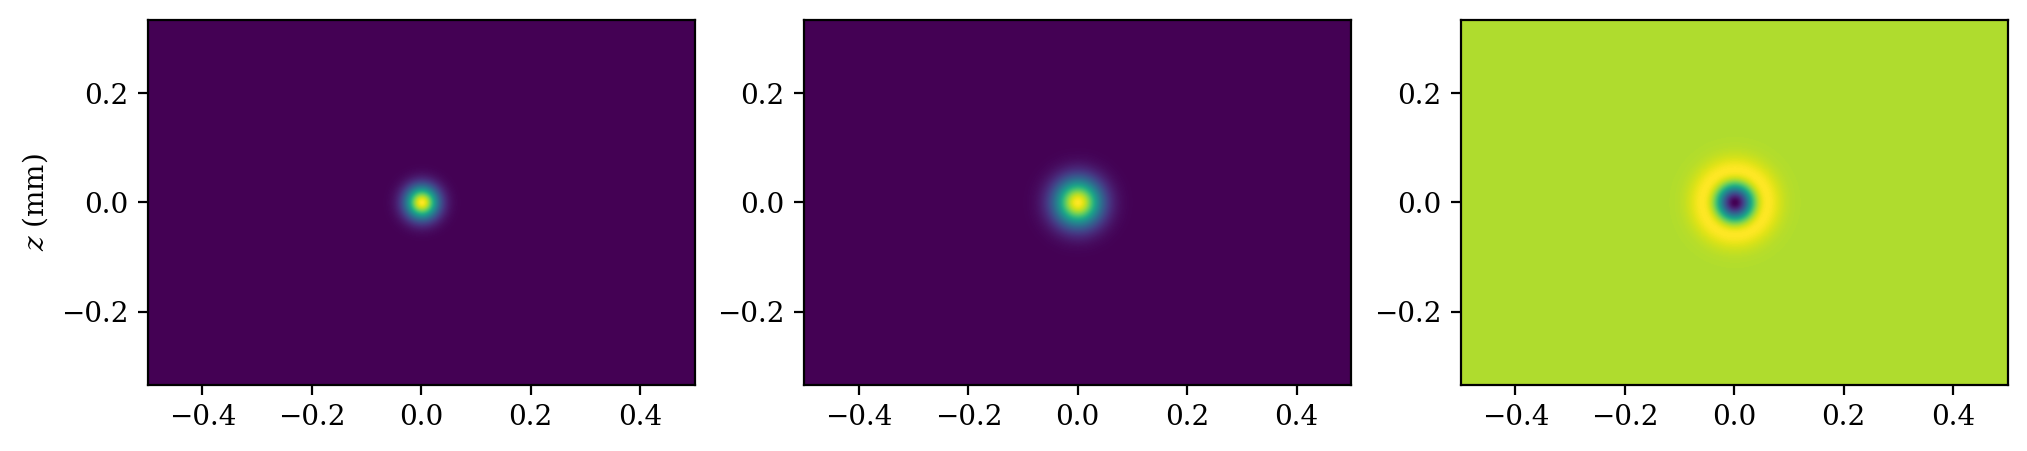

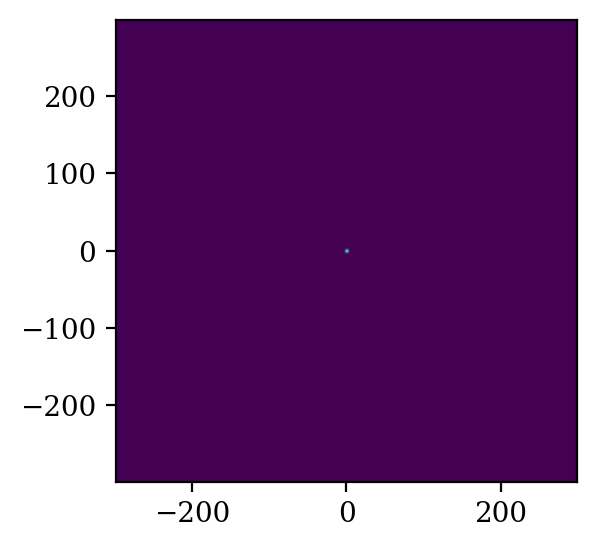

time = 0.4 ms
1.0725959108704257 |psi|^2


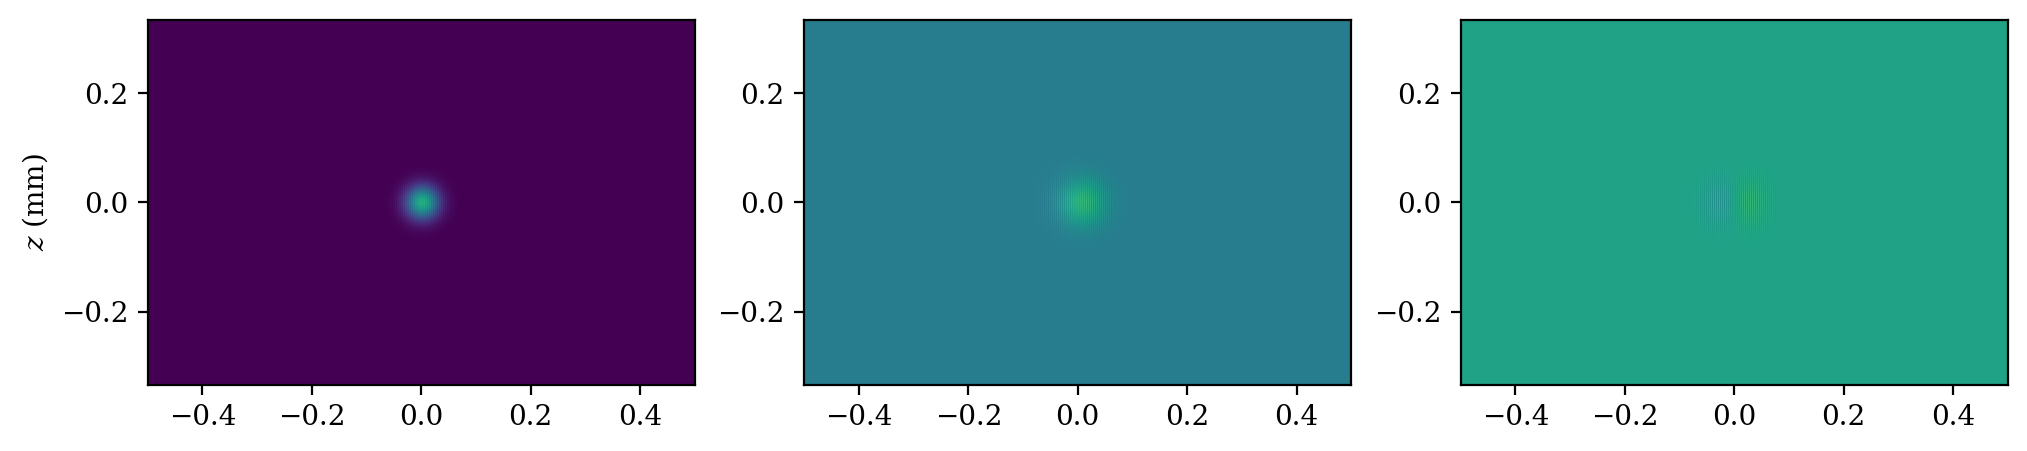

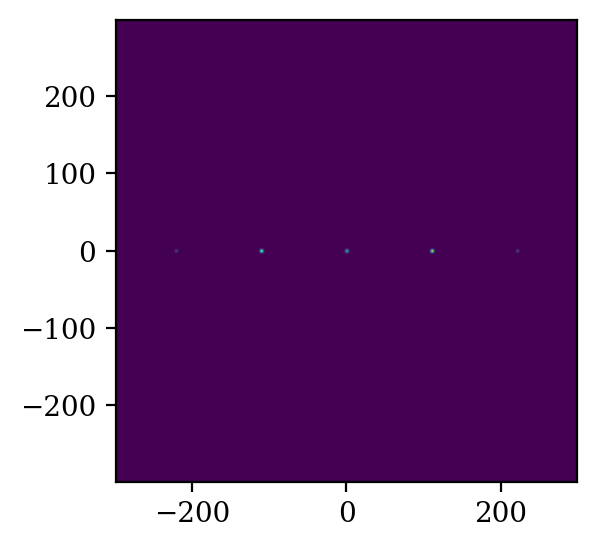

time = 0.6 ms
1.0896660474301125 |psi|^2


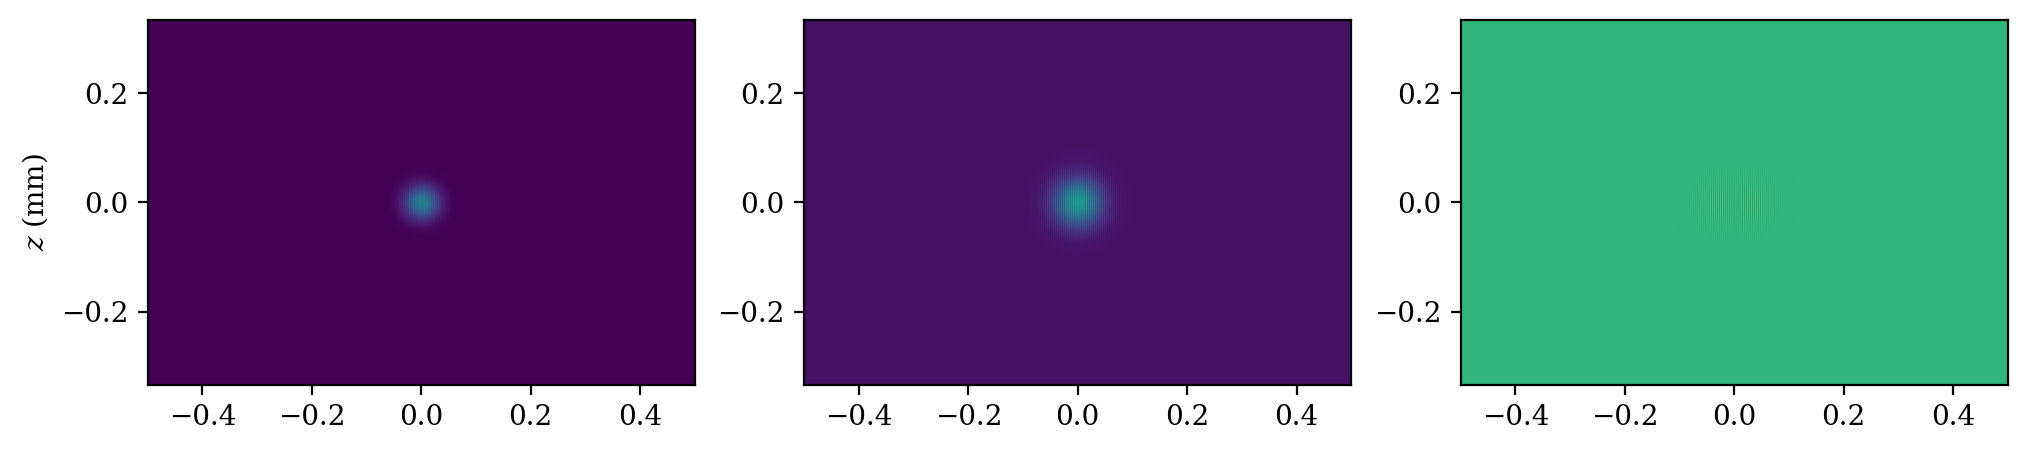

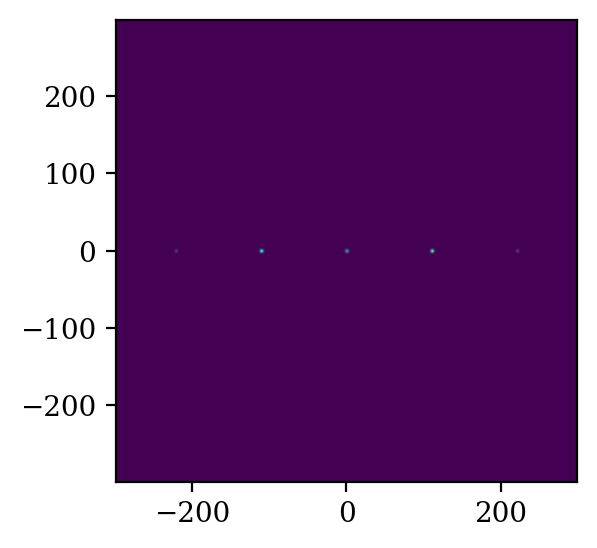

time = 0.8 ms
1.107606218762495 |psi|^2


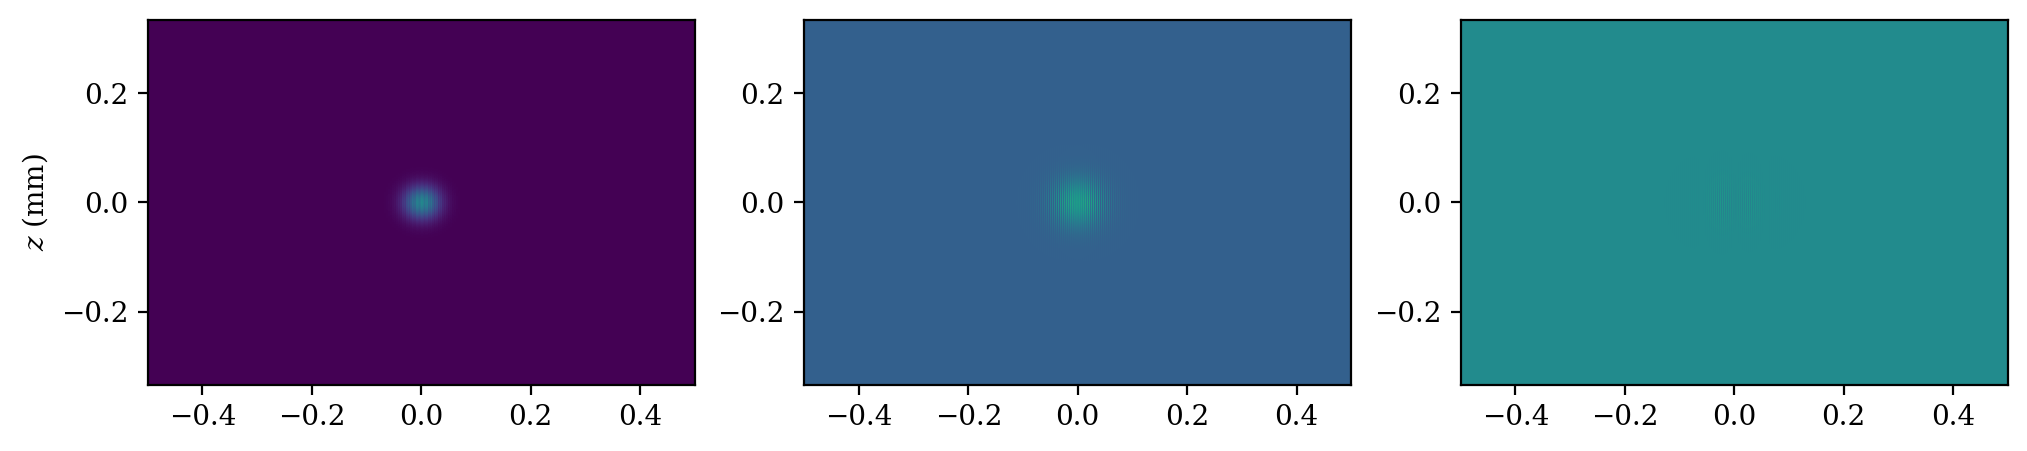

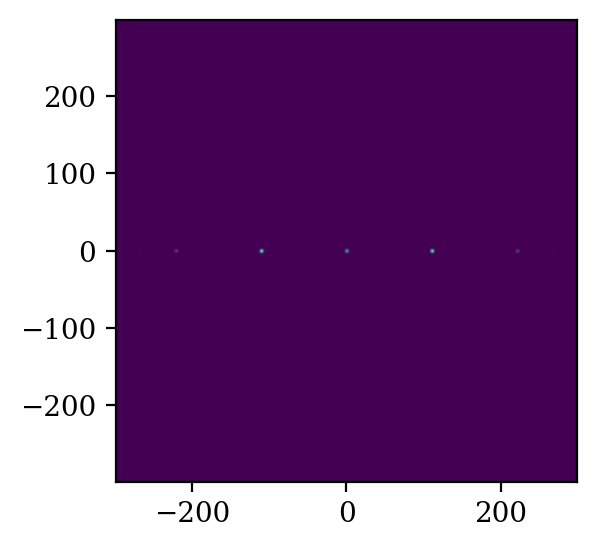

time = 1.0 ms
1.1264797670223128 |psi|^2


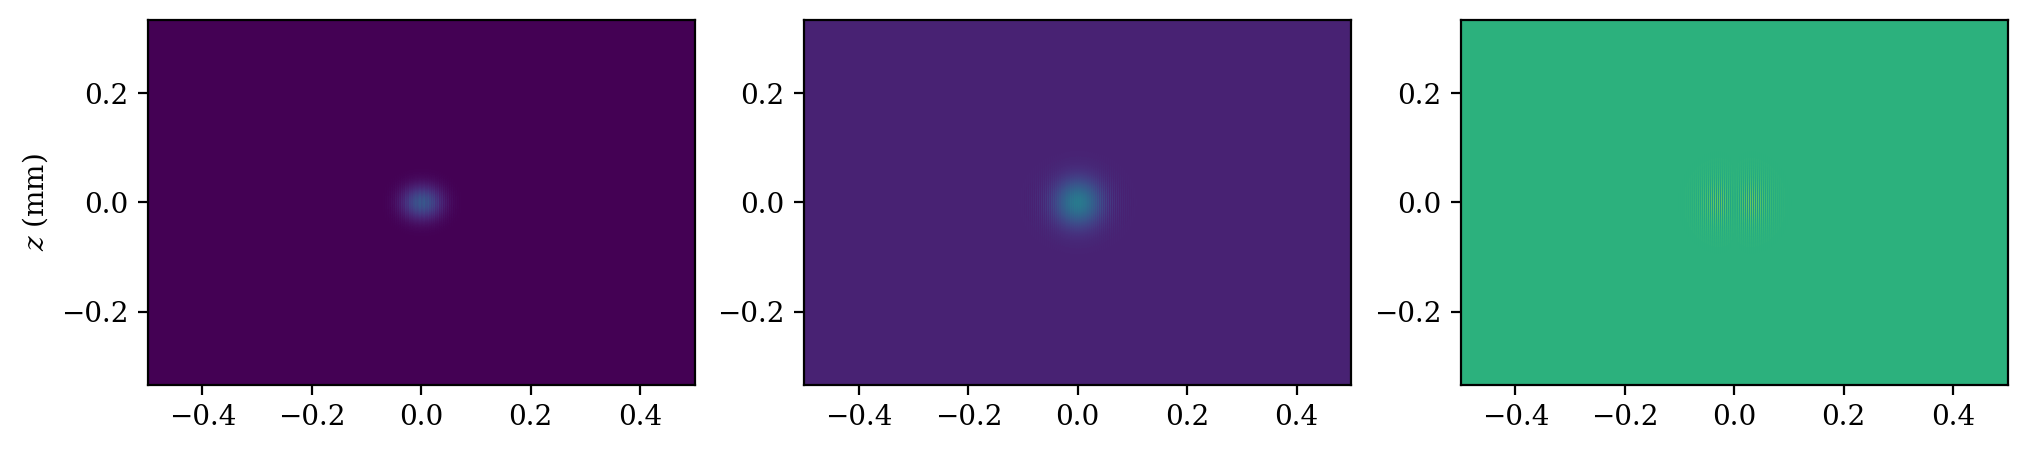

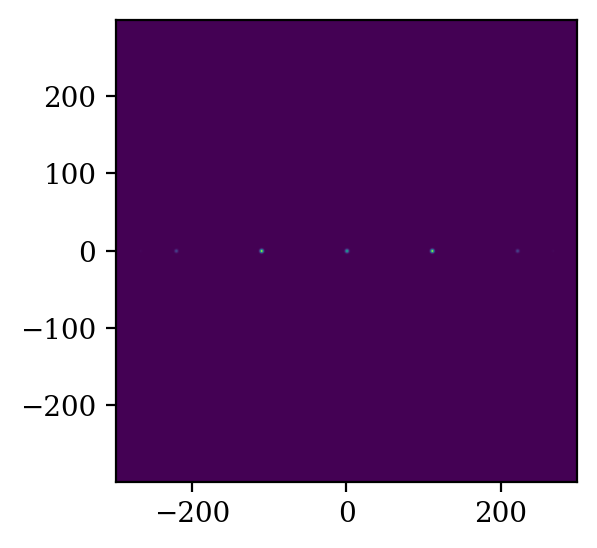

In [223]:
# (t,psi) = runNBWithPlots(psi0np(30,30,0,0),0,1,0.2)

Initial state at t = 0 ms Target end time at  5 ms


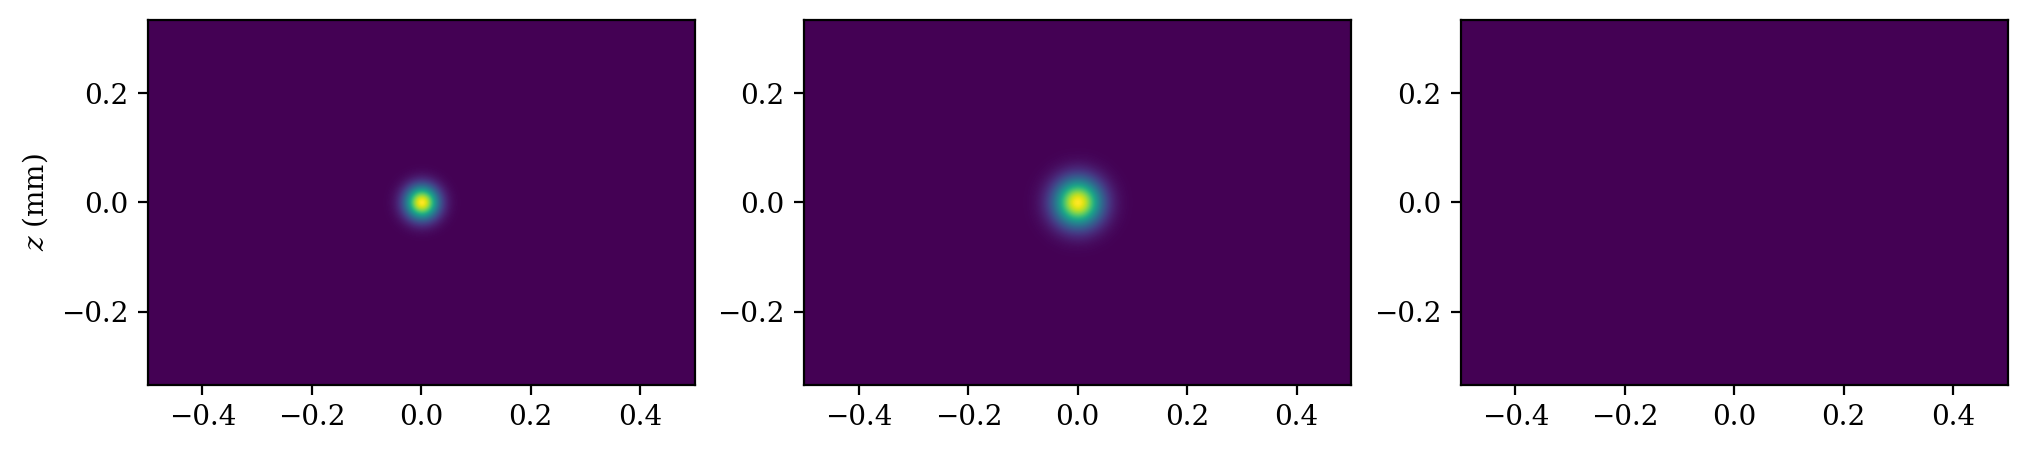

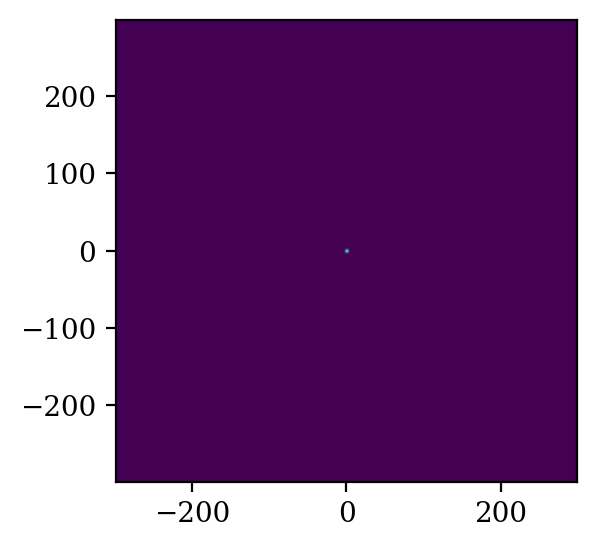

  0%|          | 0/25 [00:00<?, ?it/s]

time = 0.2 ms
0.9996670027795296 |psi|^2


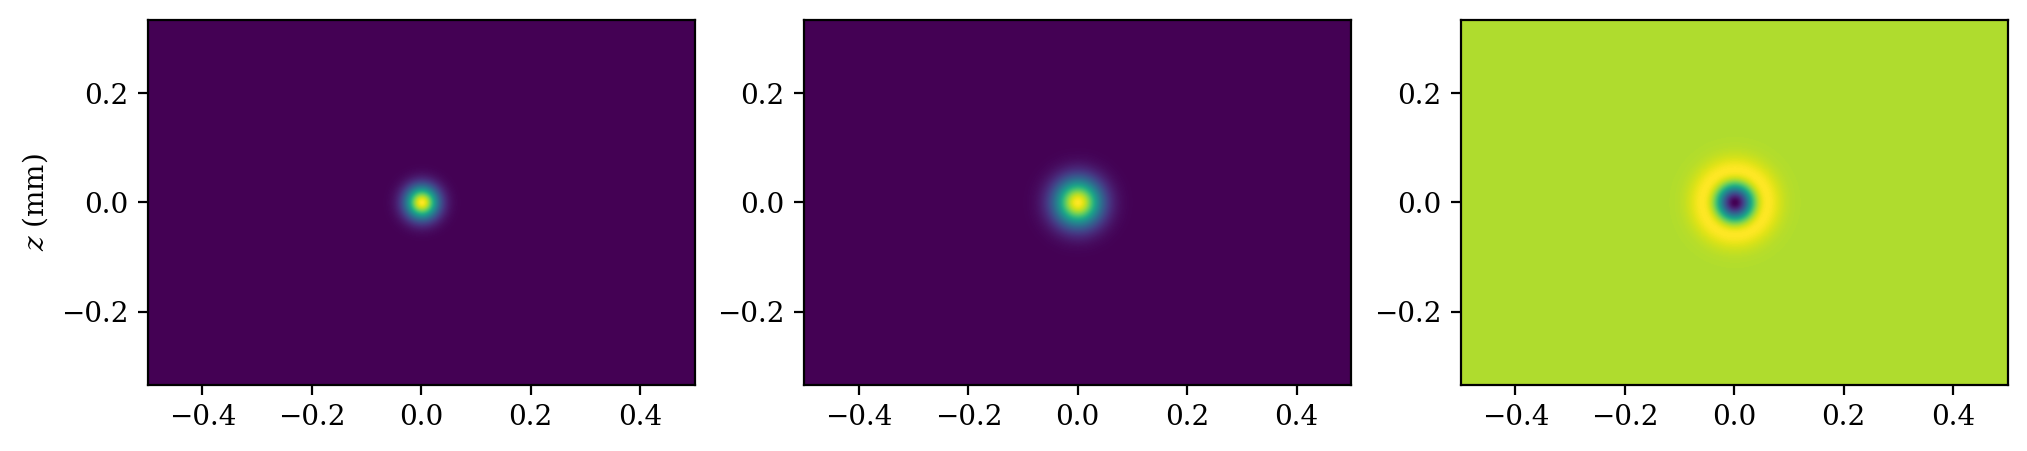

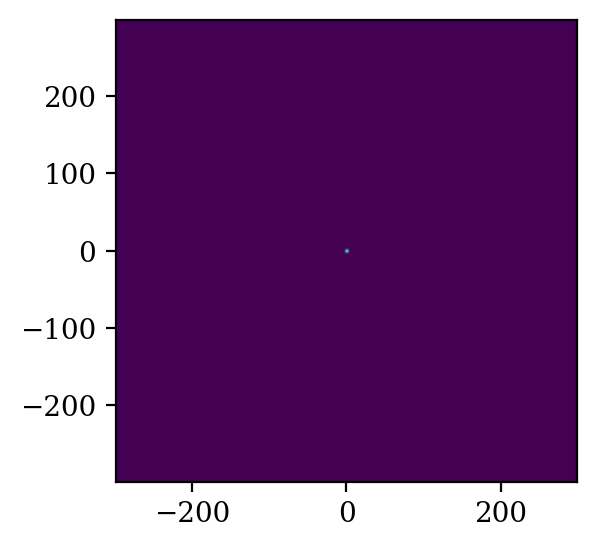

time = 0.4 ms
0.999667005892058 |psi|^2


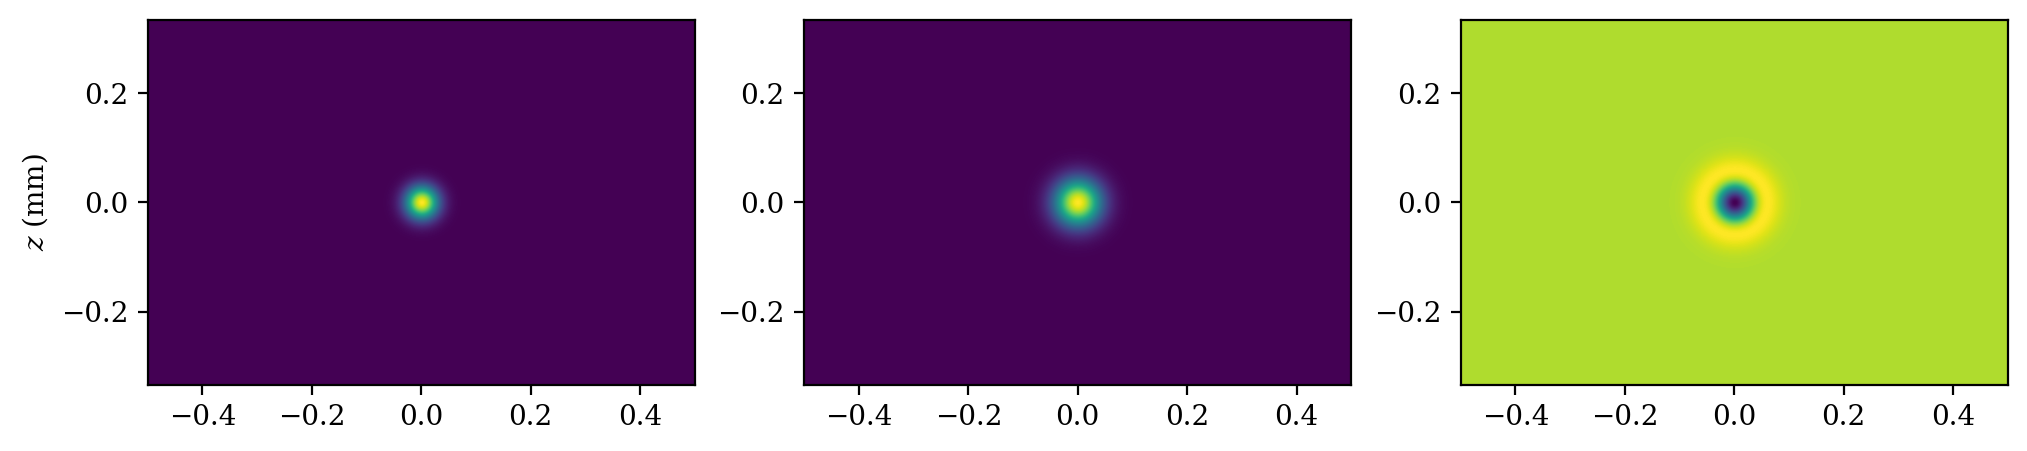

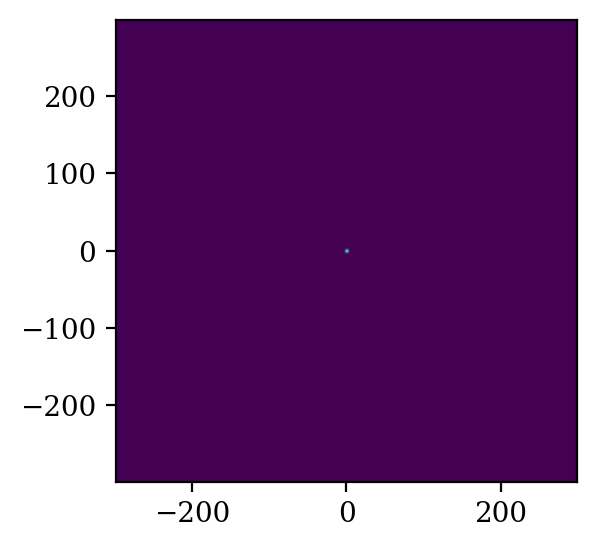

time = 0.6 ms
1.0725959142100496 |psi|^2


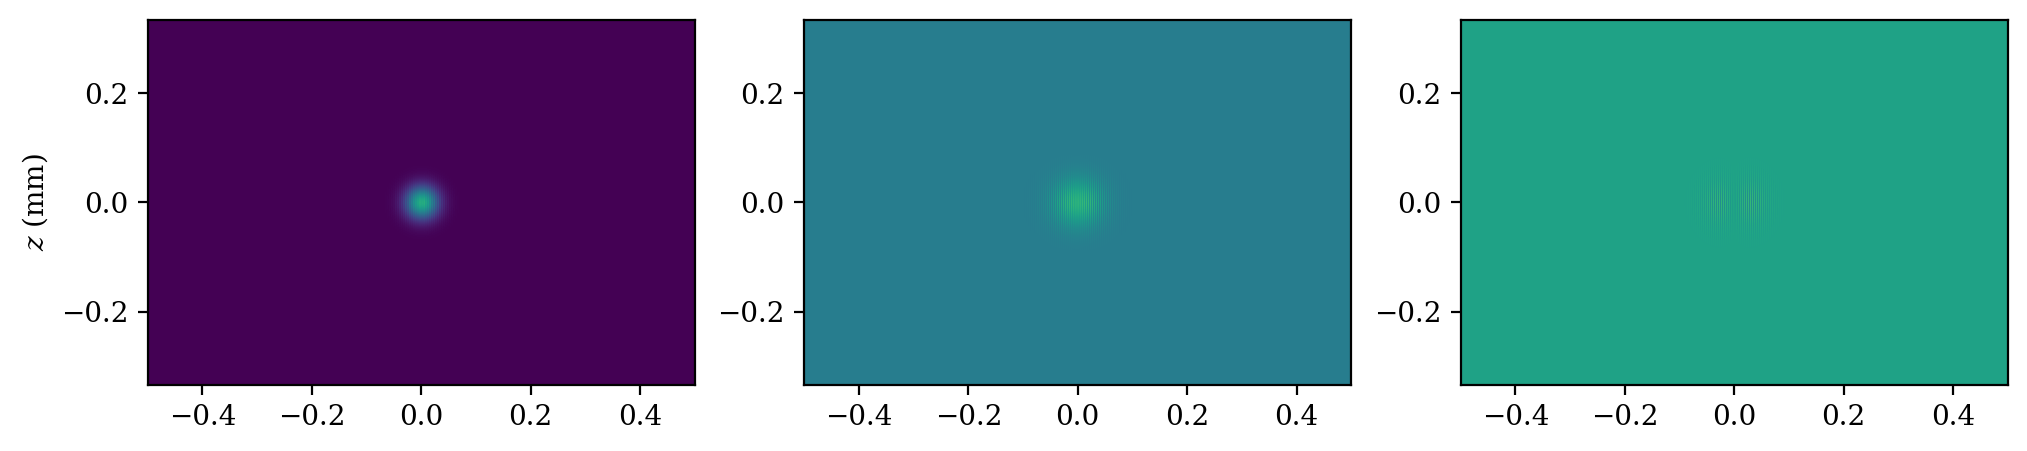

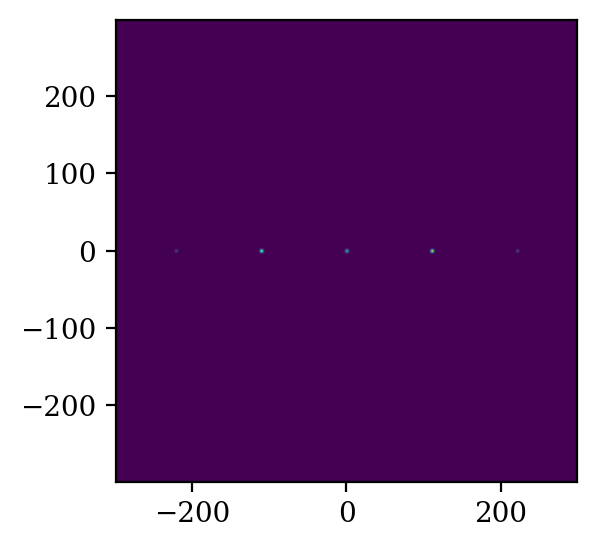

time = 0.8 ms
1.0896660508229403 |psi|^2


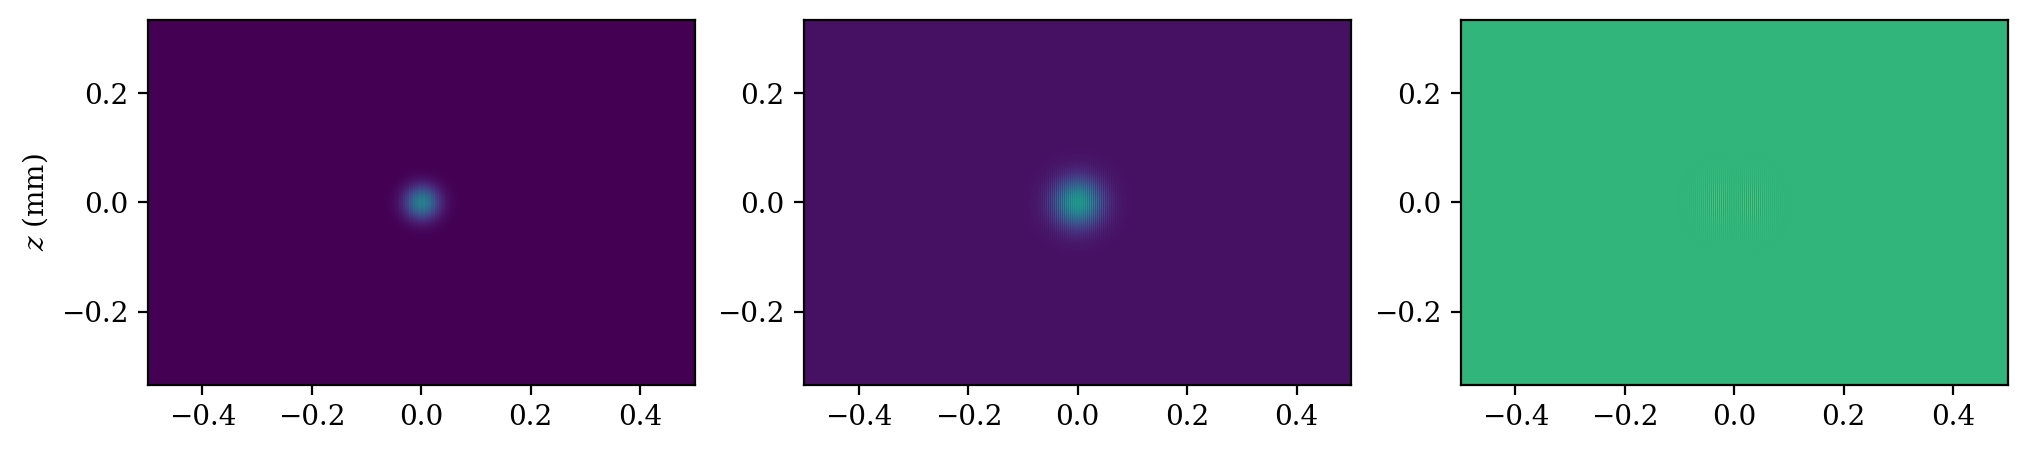

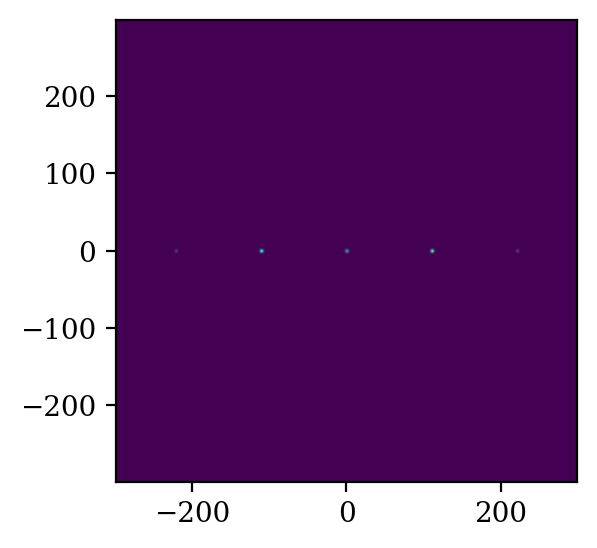

time = 1.0 ms
1.107606222211239 |psi|^2


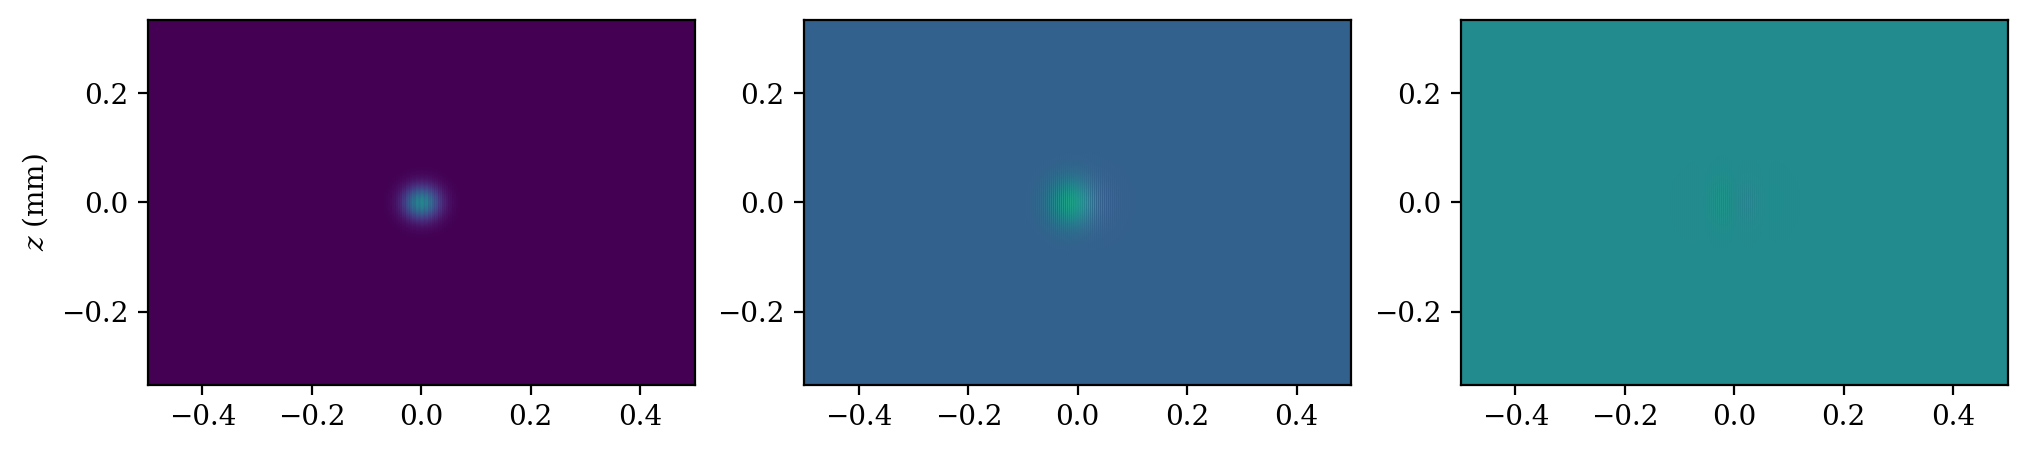

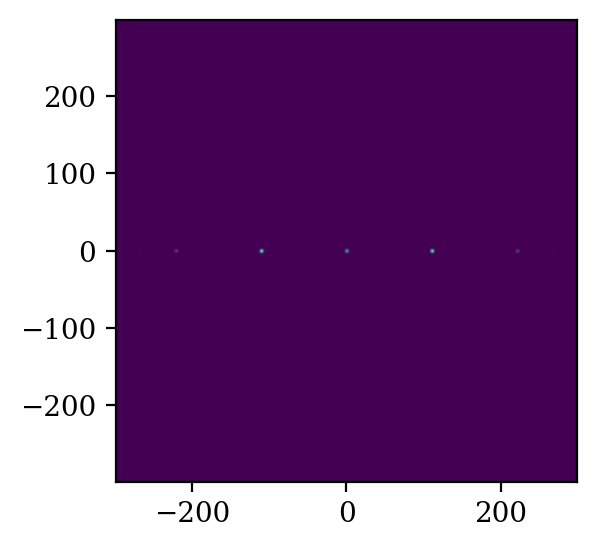

time = 1.2 ms
1.1264797705298837 |psi|^2


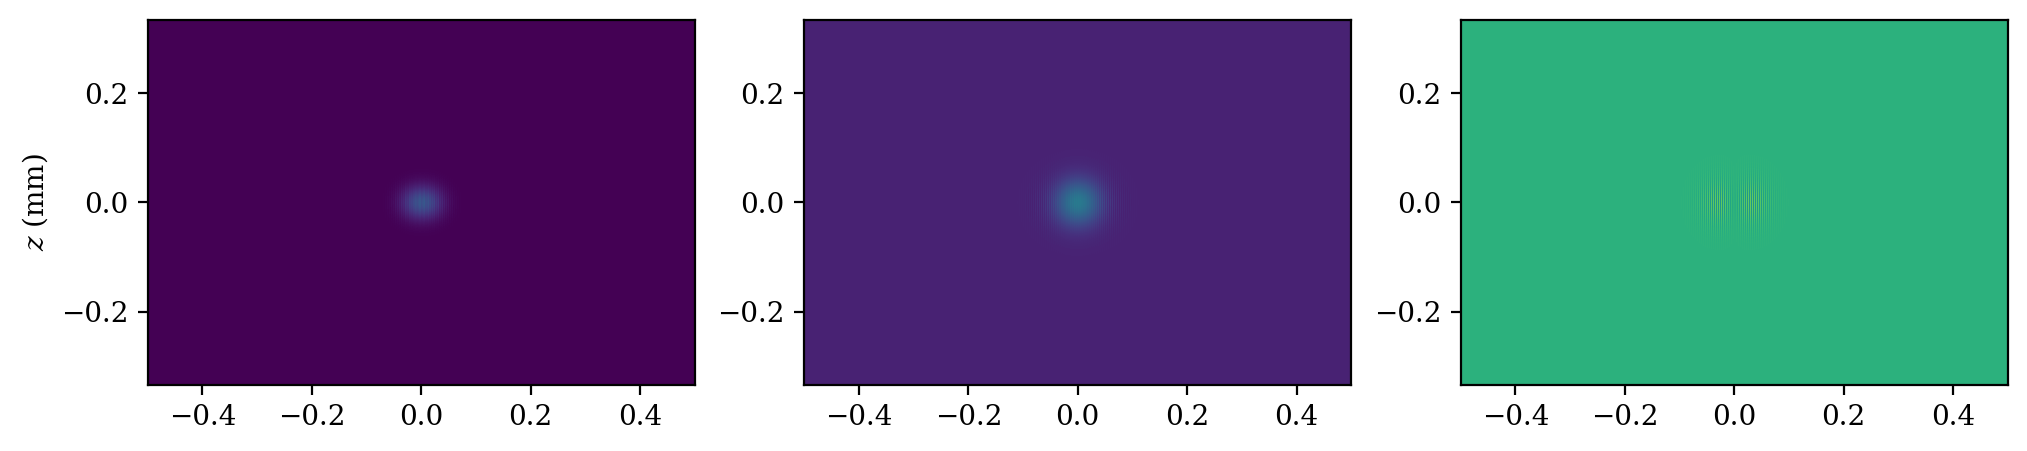

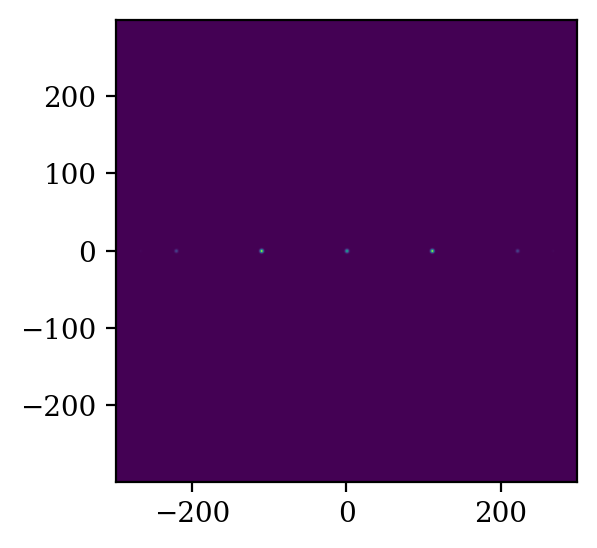

time = 1.4 ms
1.1463549662853518 |psi|^2


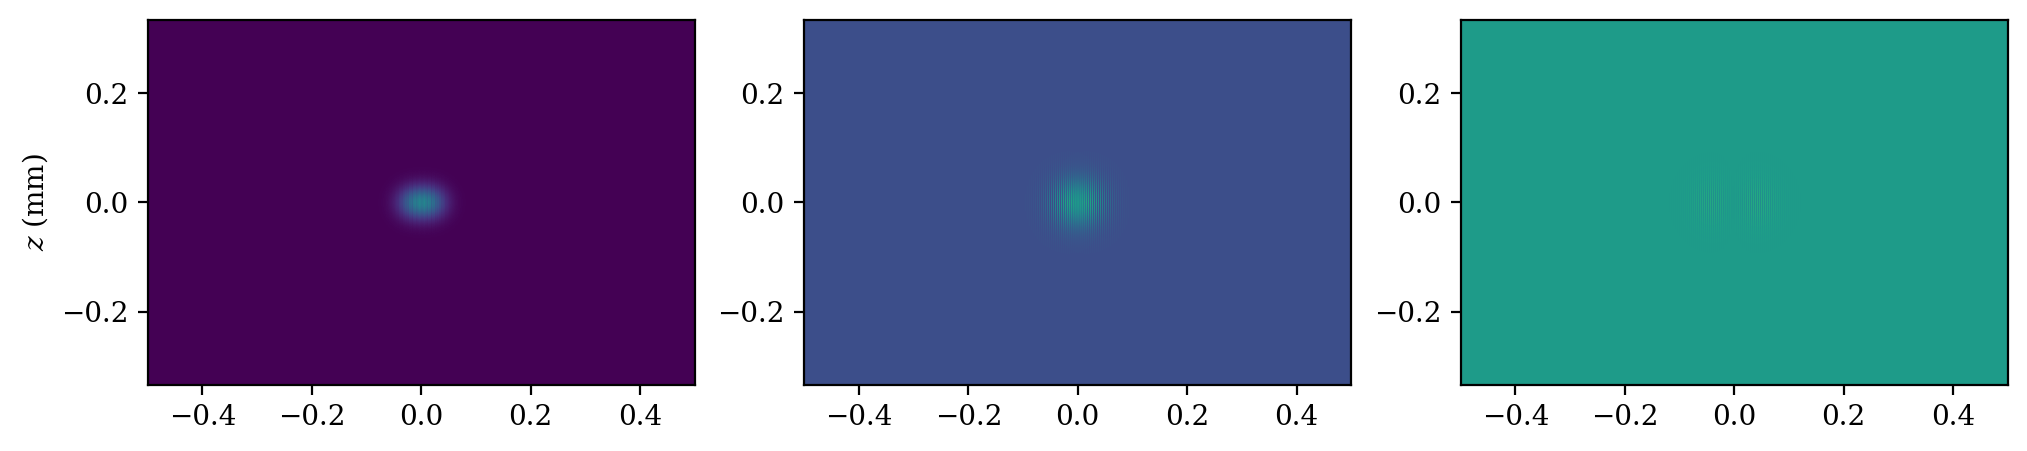

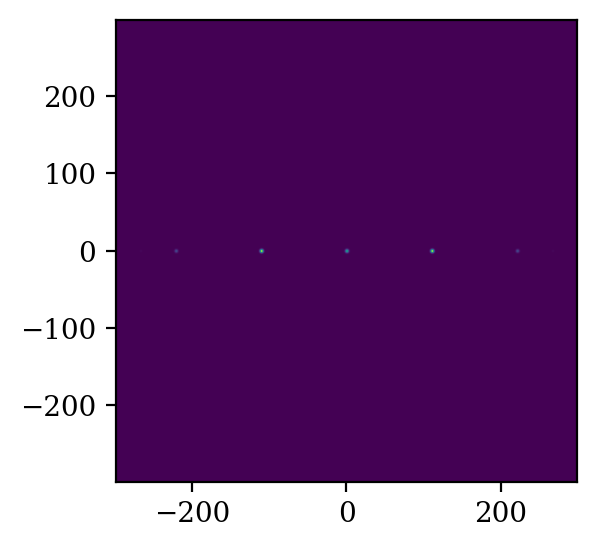

time = 1.6 ms
1.1673053995967522 |psi|^2


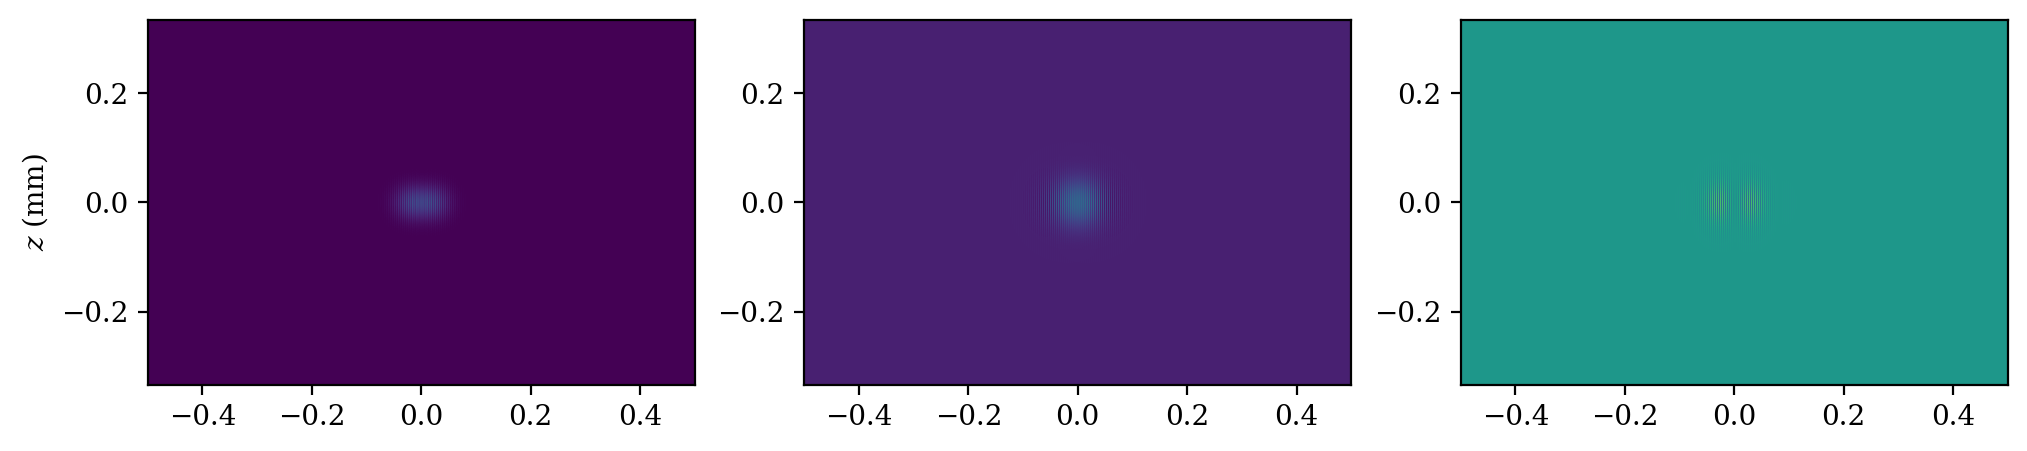

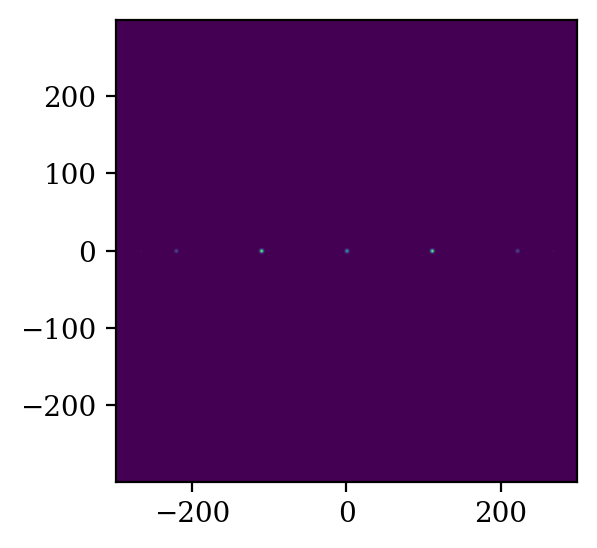

time = 1.8 ms
1.1894104030377304 |psi|^2


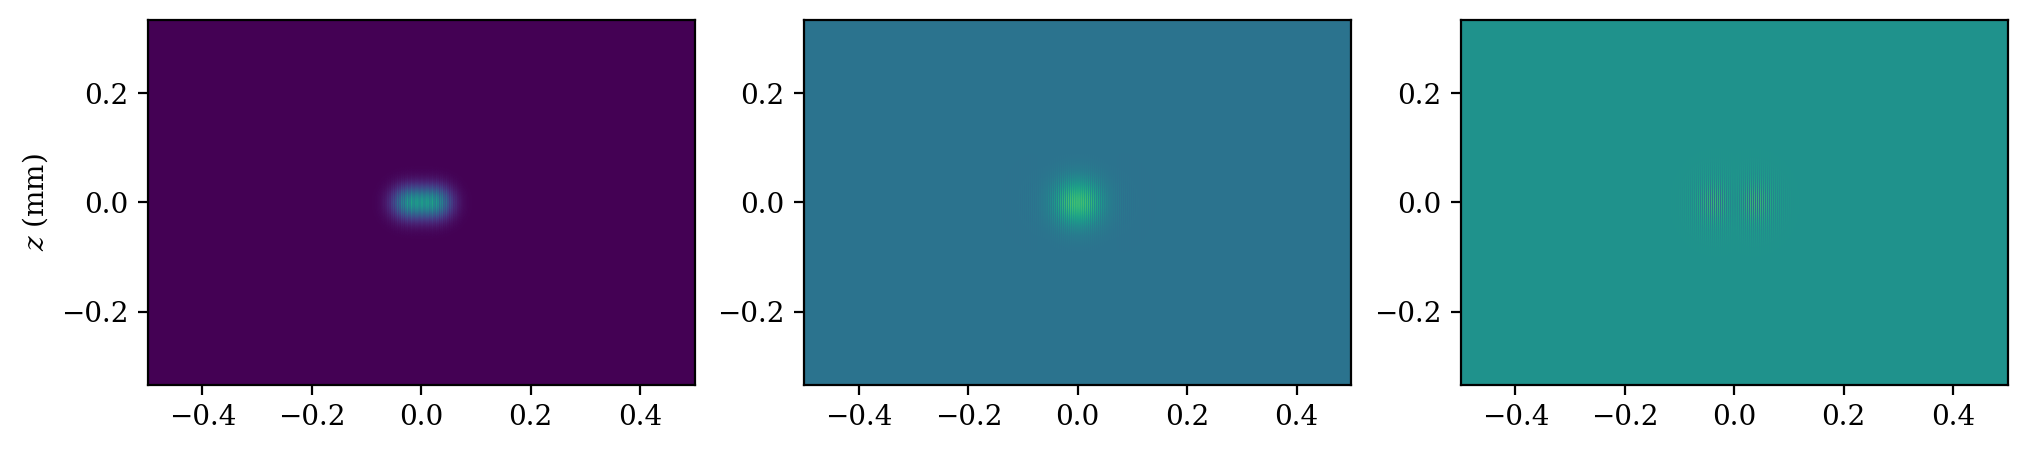

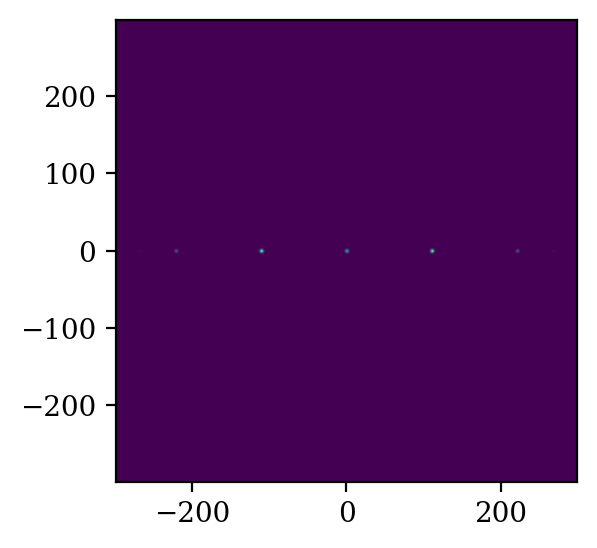

time = 2.0 ms
1.212755508655328 |psi|^2


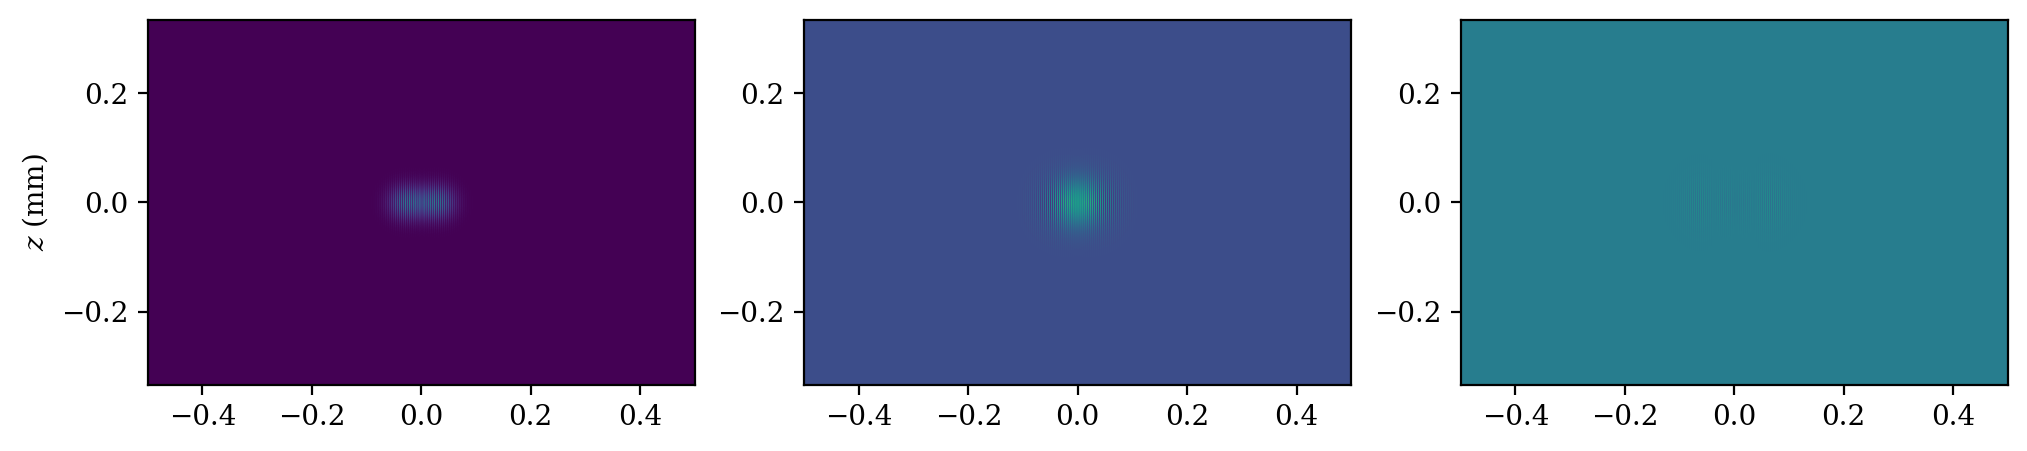

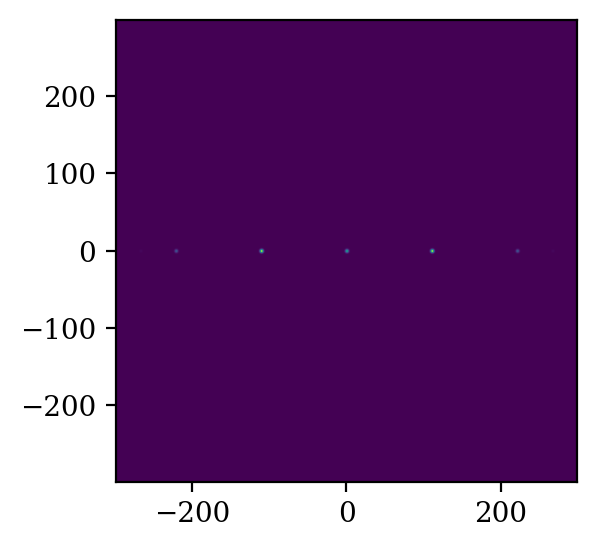

time = 2.2 ms
1.2374329419797052 |psi|^2


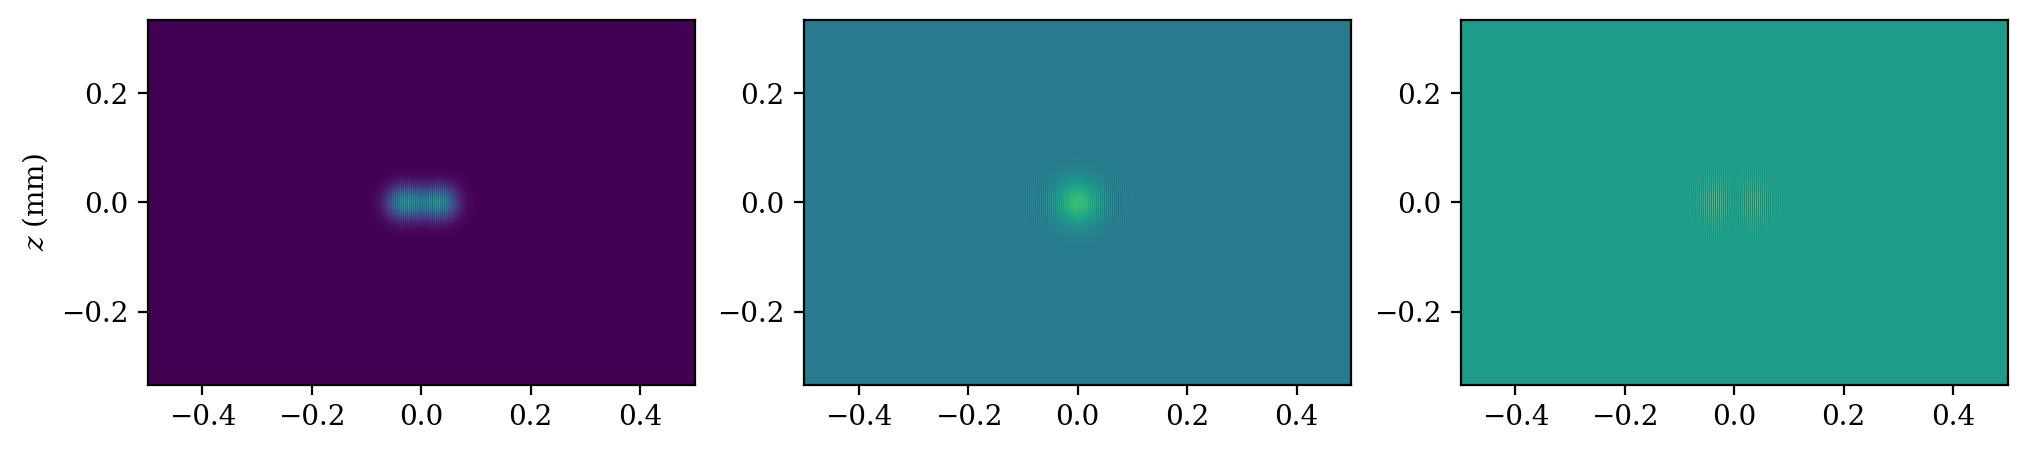

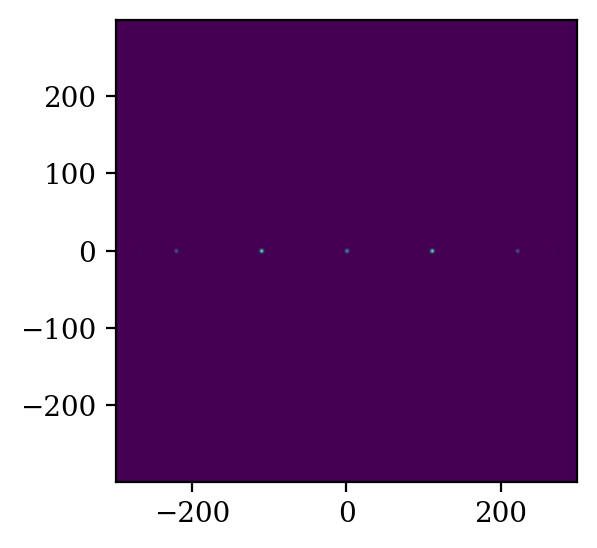

time = 2.4 ms
1.263542156075157 |psi|^2


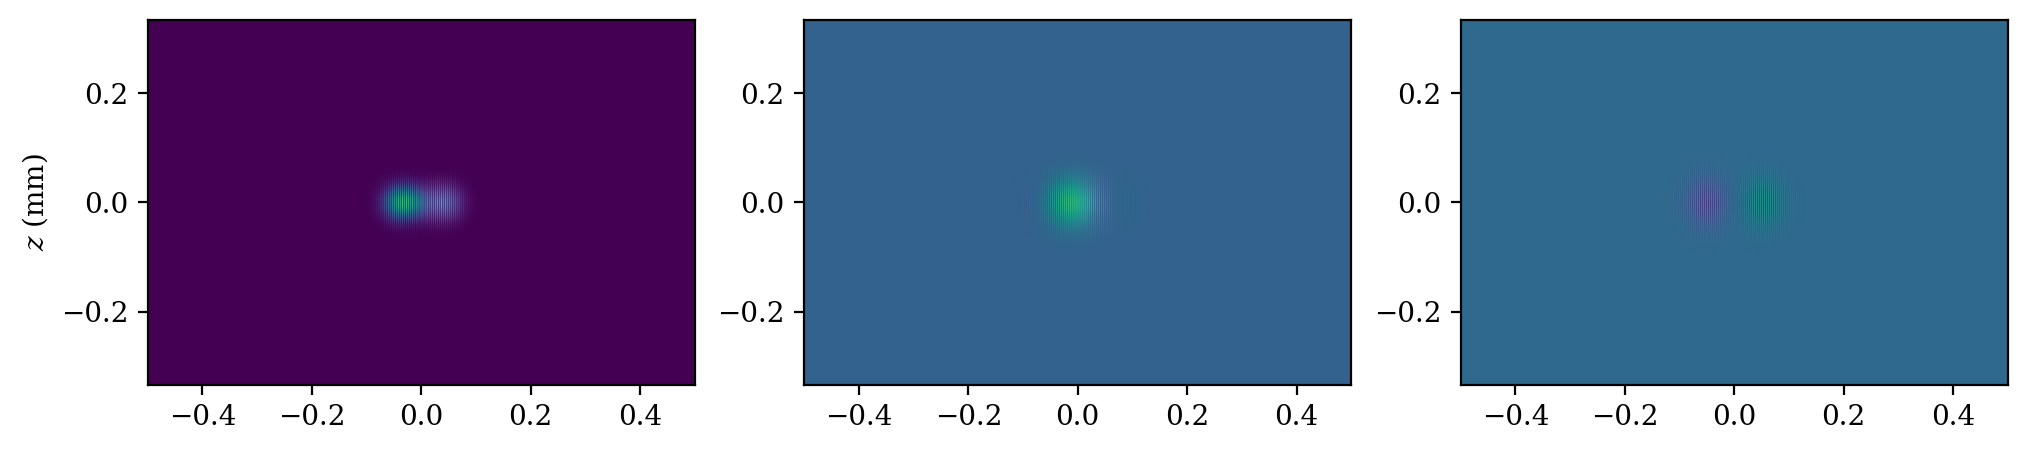

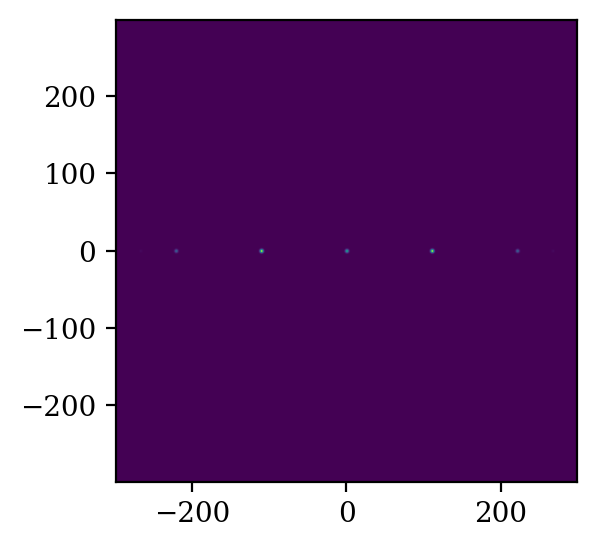

time = 2.6 ms
1.2911904089396113 |psi|^2


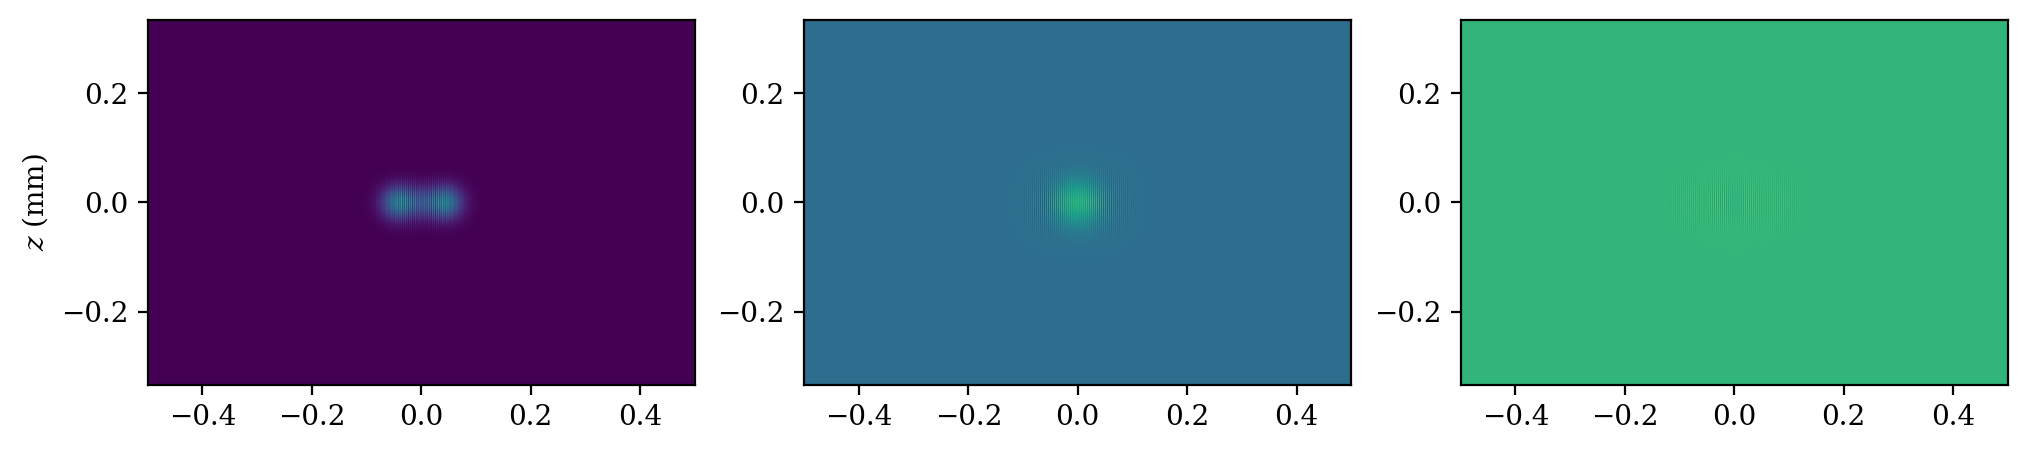

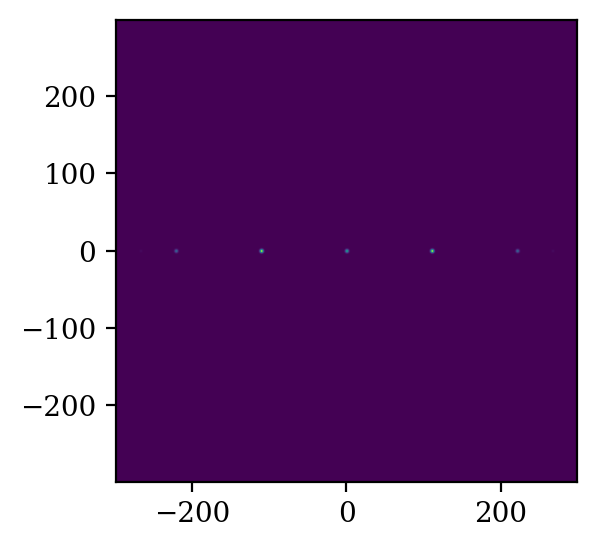

time = 2.8 ms
1.3204933878386997 |psi|^2


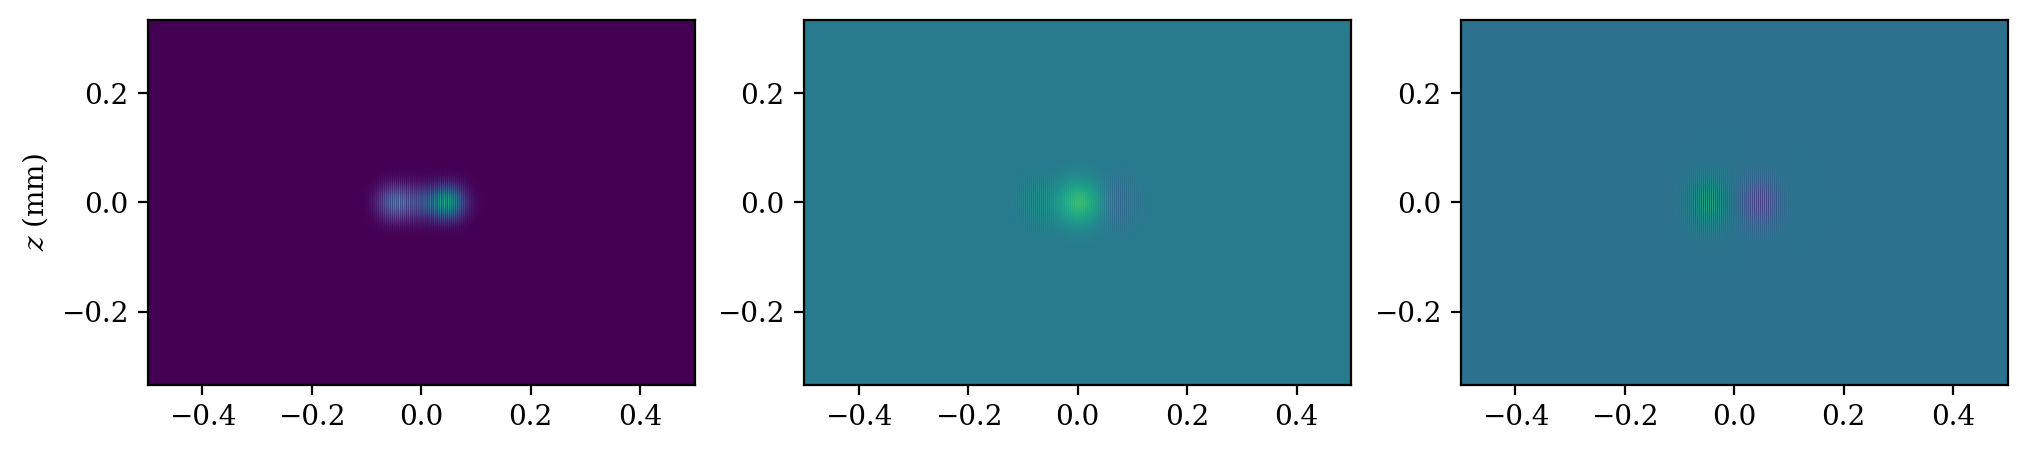

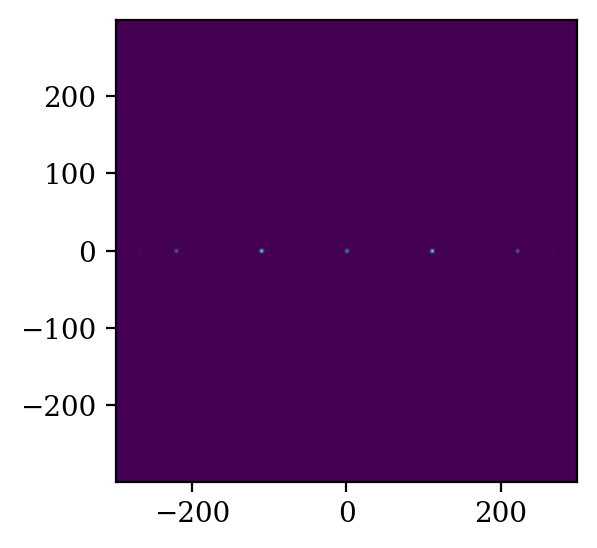

time = 3.0 ms
1.35157588446344 |psi|^2


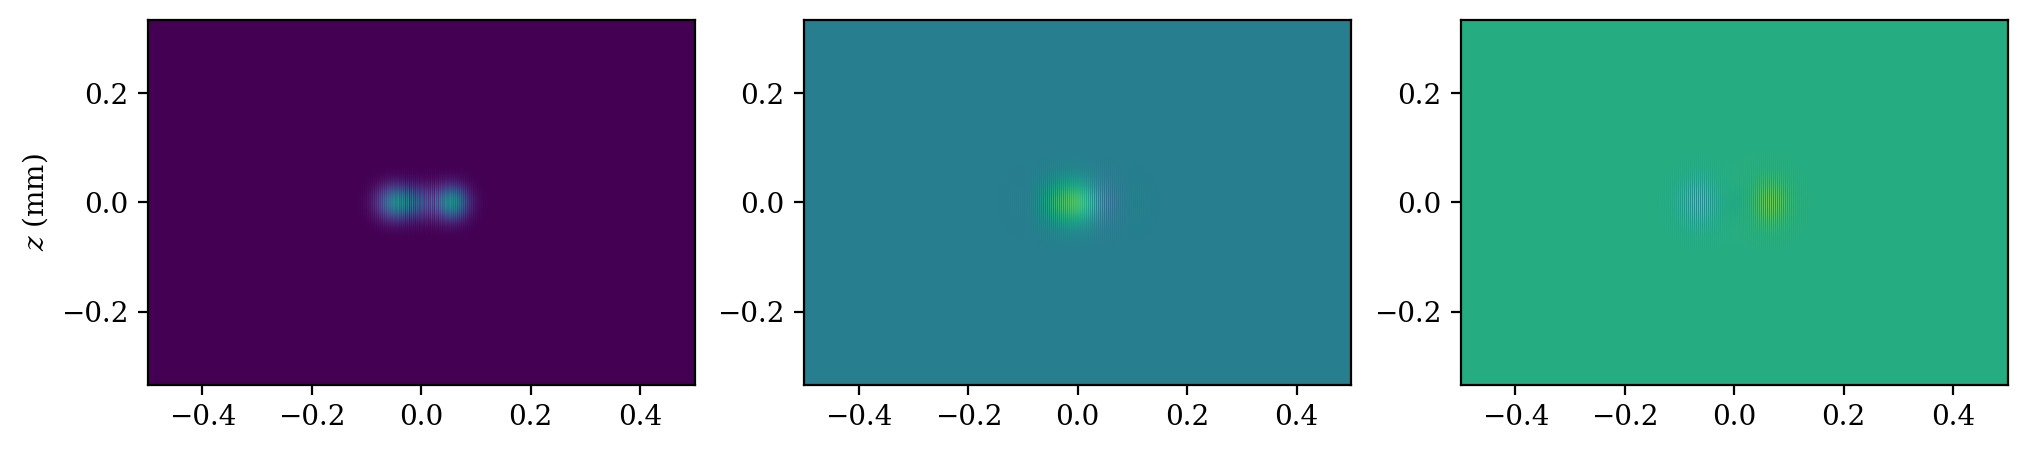

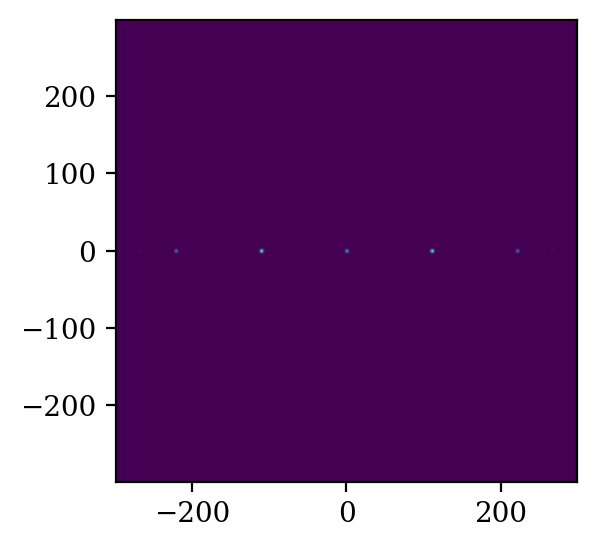

time = 3.2 ms
1.3845725251296435 |psi|^2


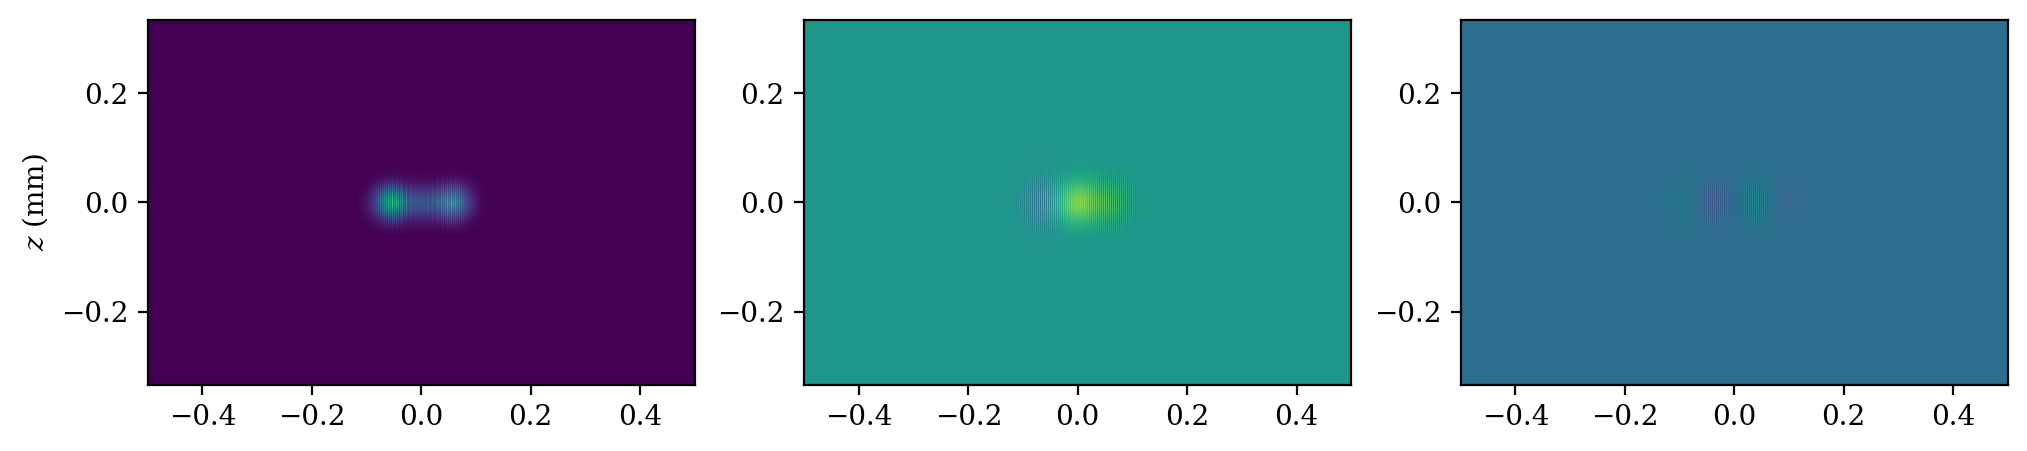

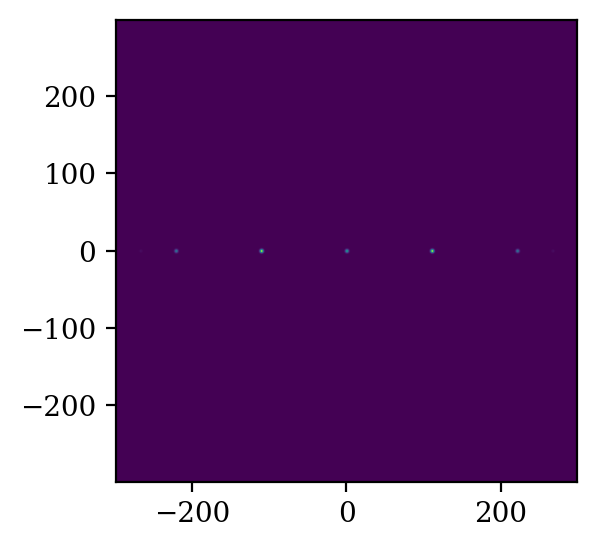

time = 3.4 ms
1.4196285605947616 |psi|^2


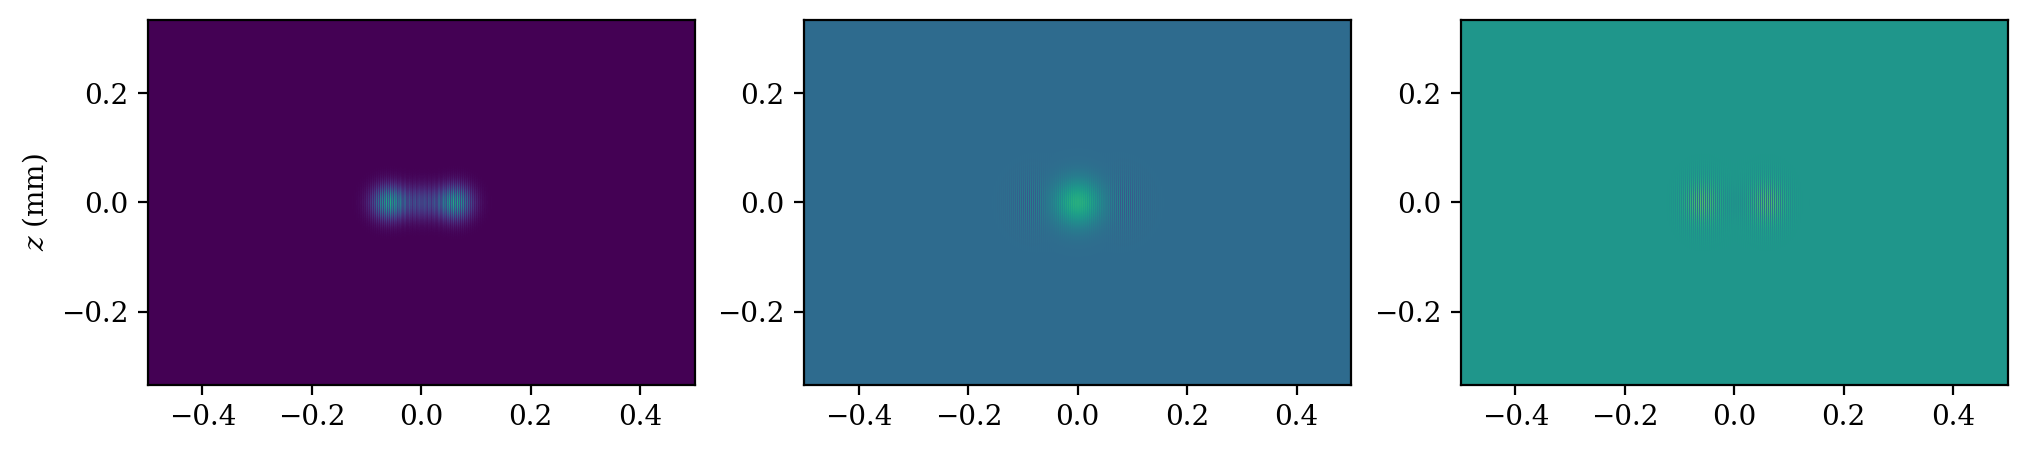

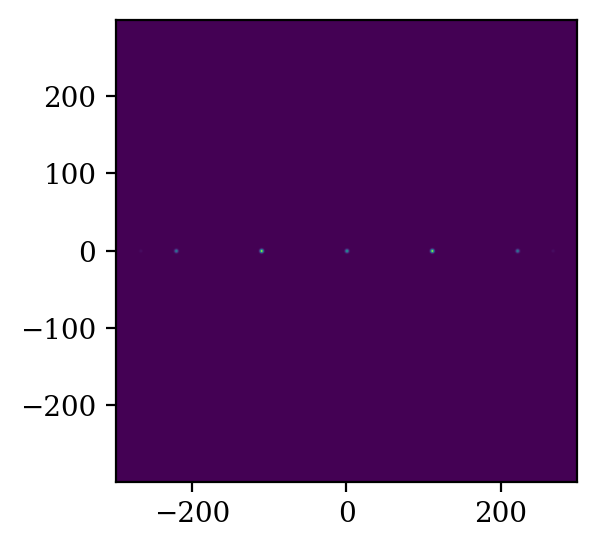

time = 3.6 ms
1.456900720456426 |psi|^2


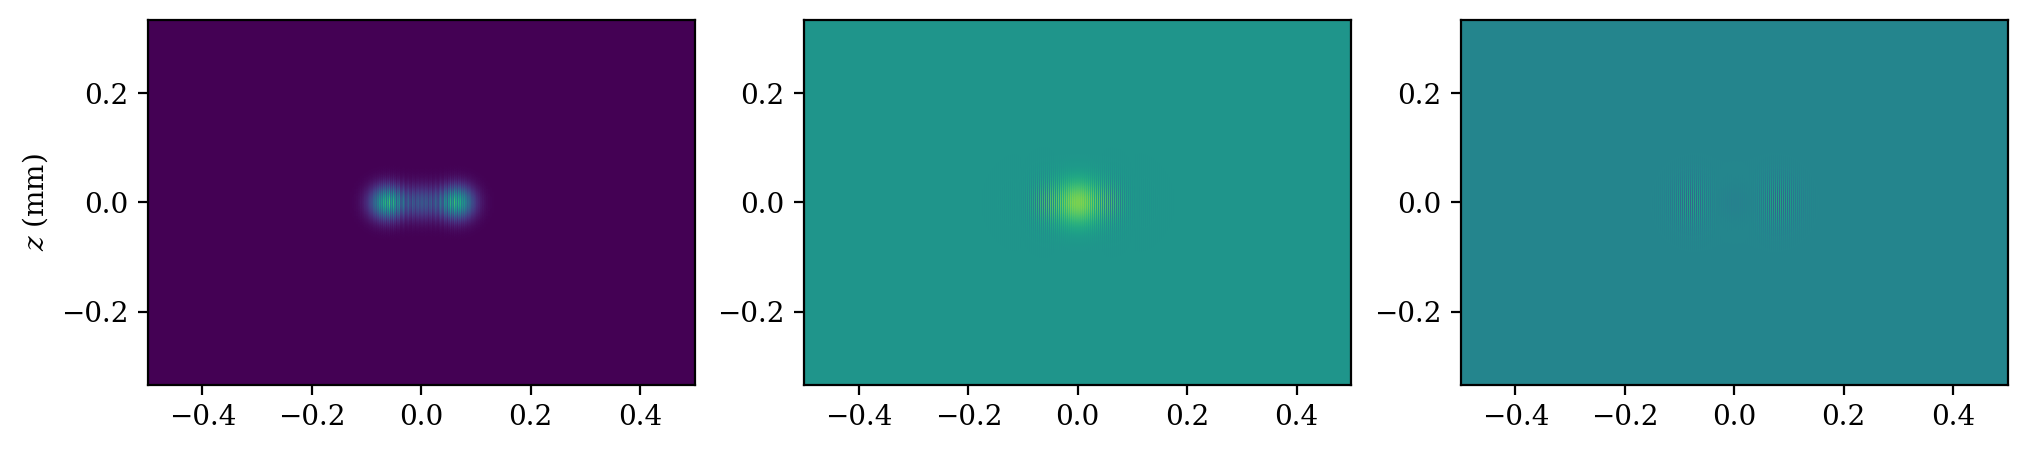

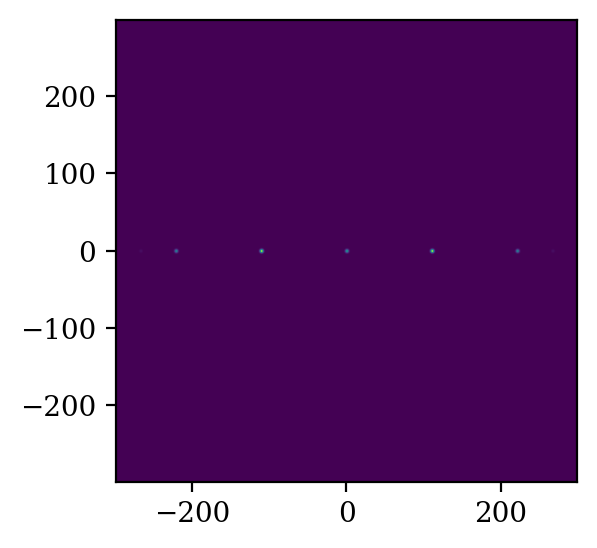

time = 3.8 ms
1.4965581375192687 |psi|^2


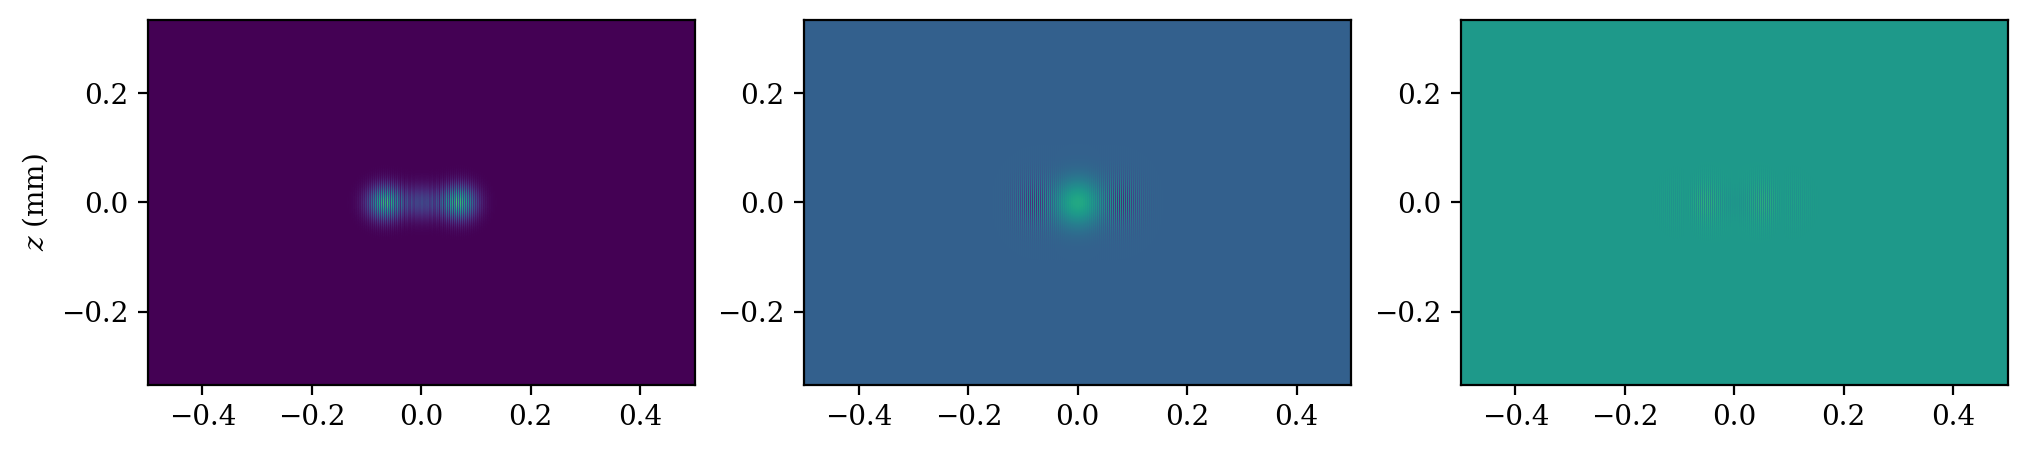

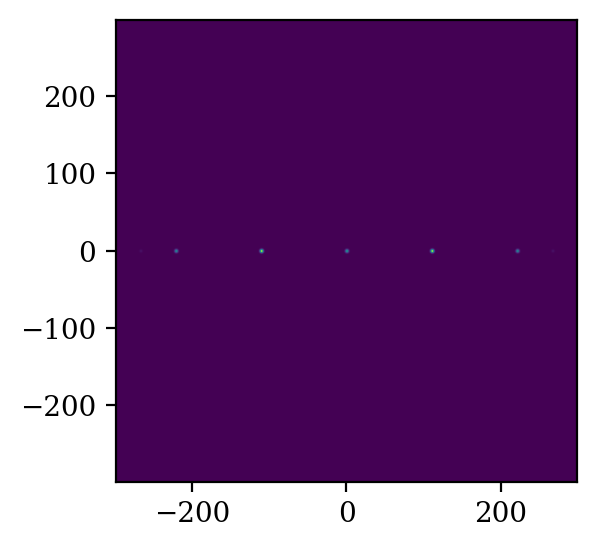

time = 4.0 ms
1.5387833479756508 |psi|^2


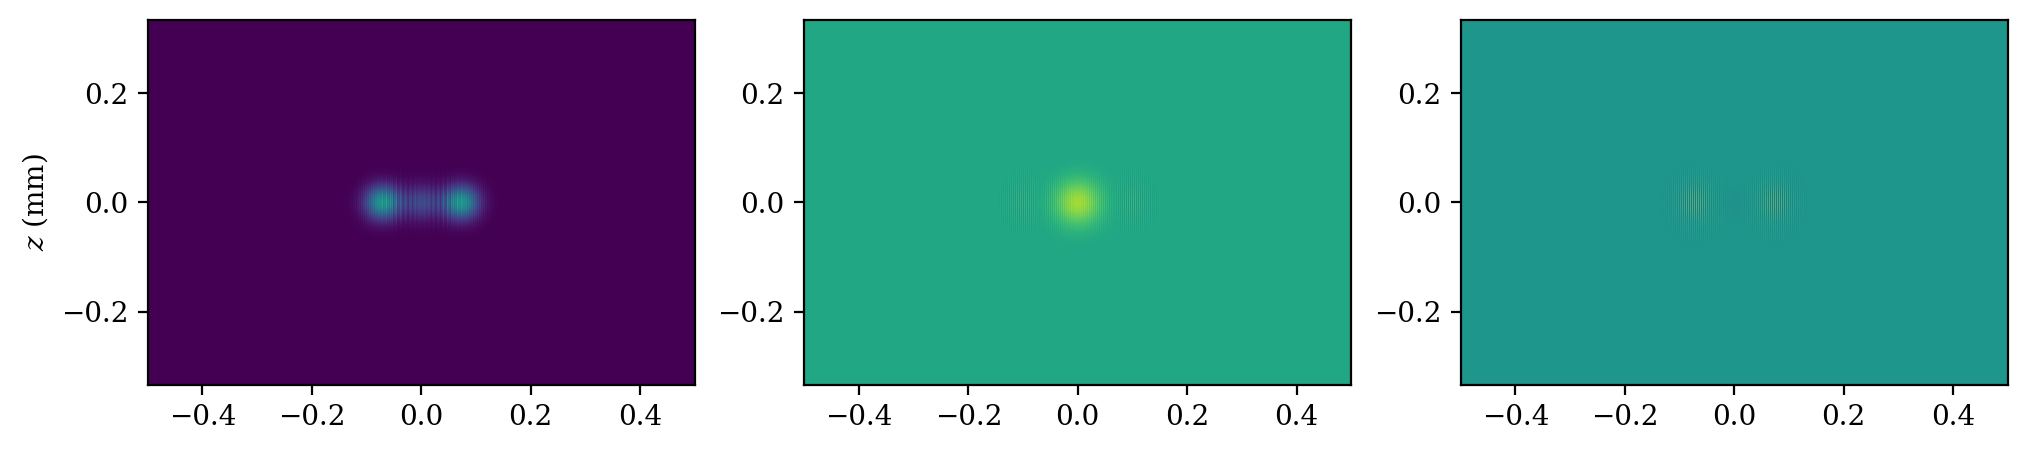

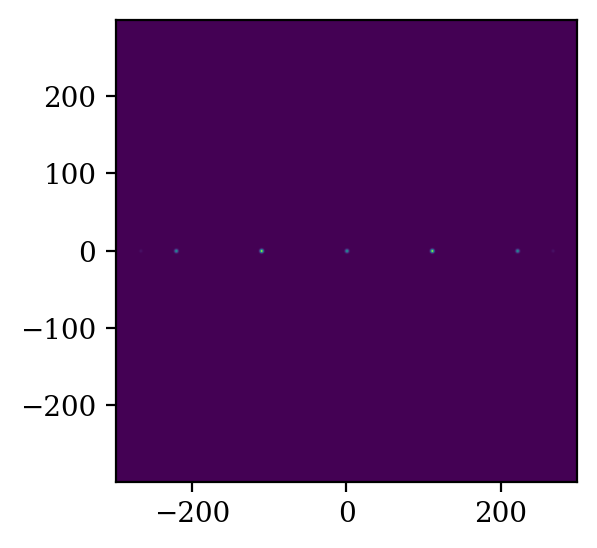

time = 4.2 ms
1.5837733737449695 |psi|^2


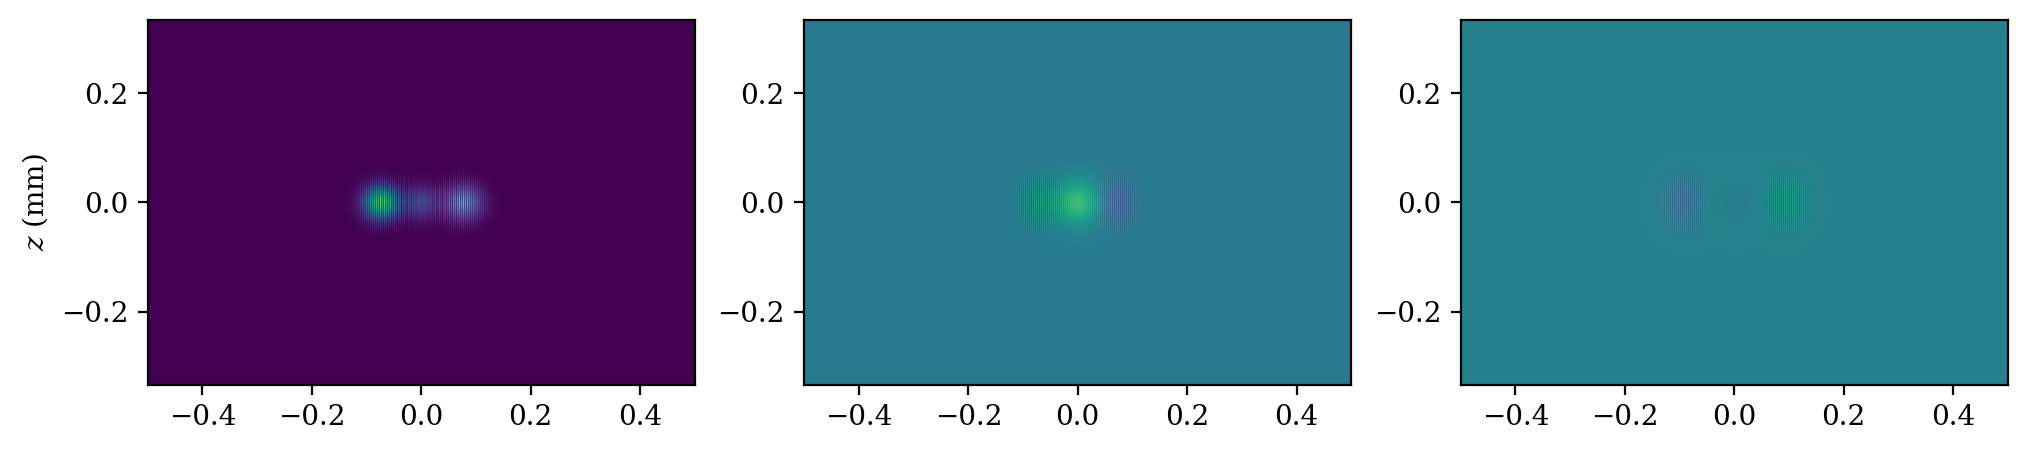

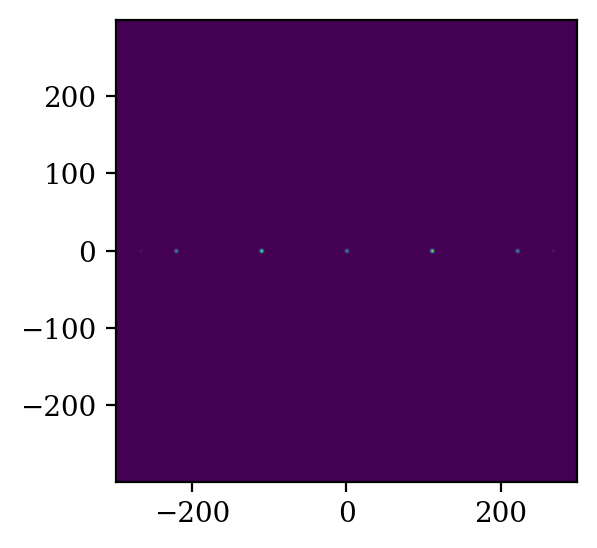

time = 4.4 ms
1.6317408938588527 |psi|^2


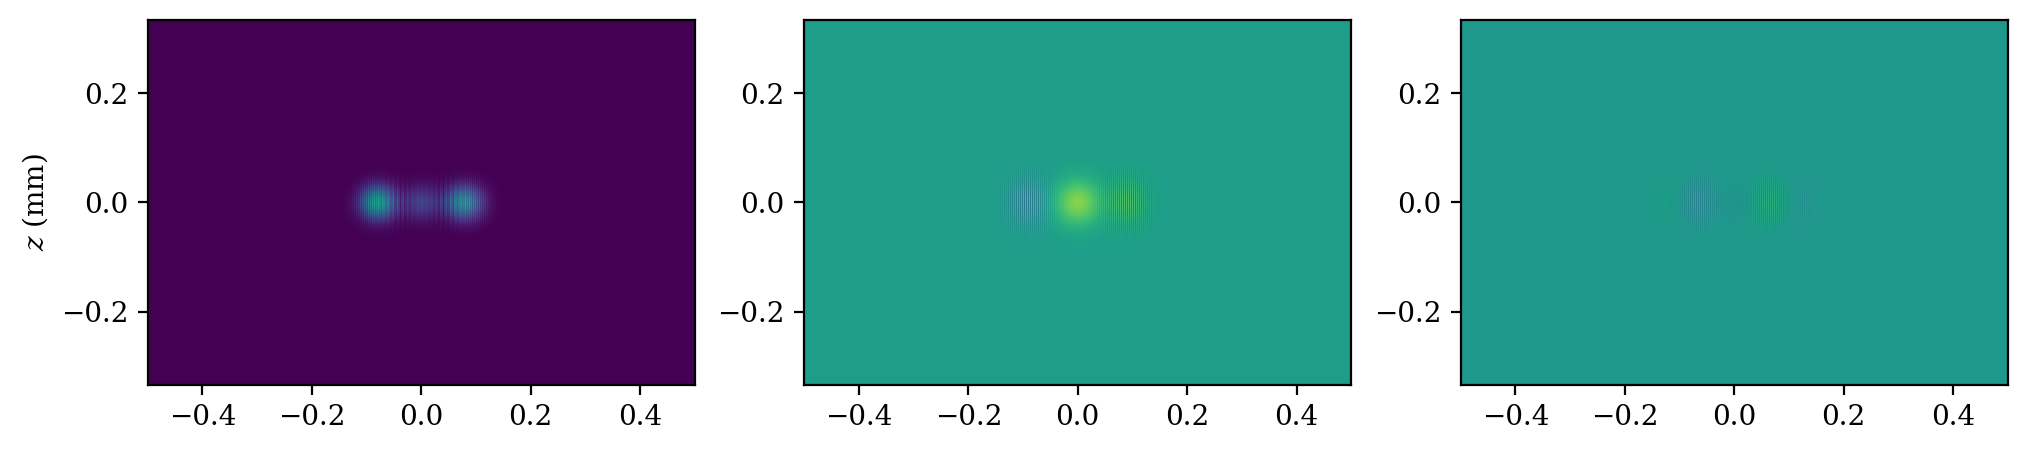

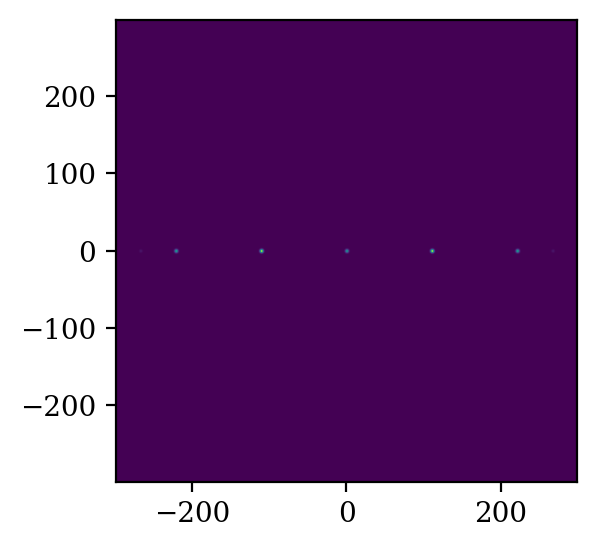

time = 4.6 ms
1.6829155123696502 |psi|^2


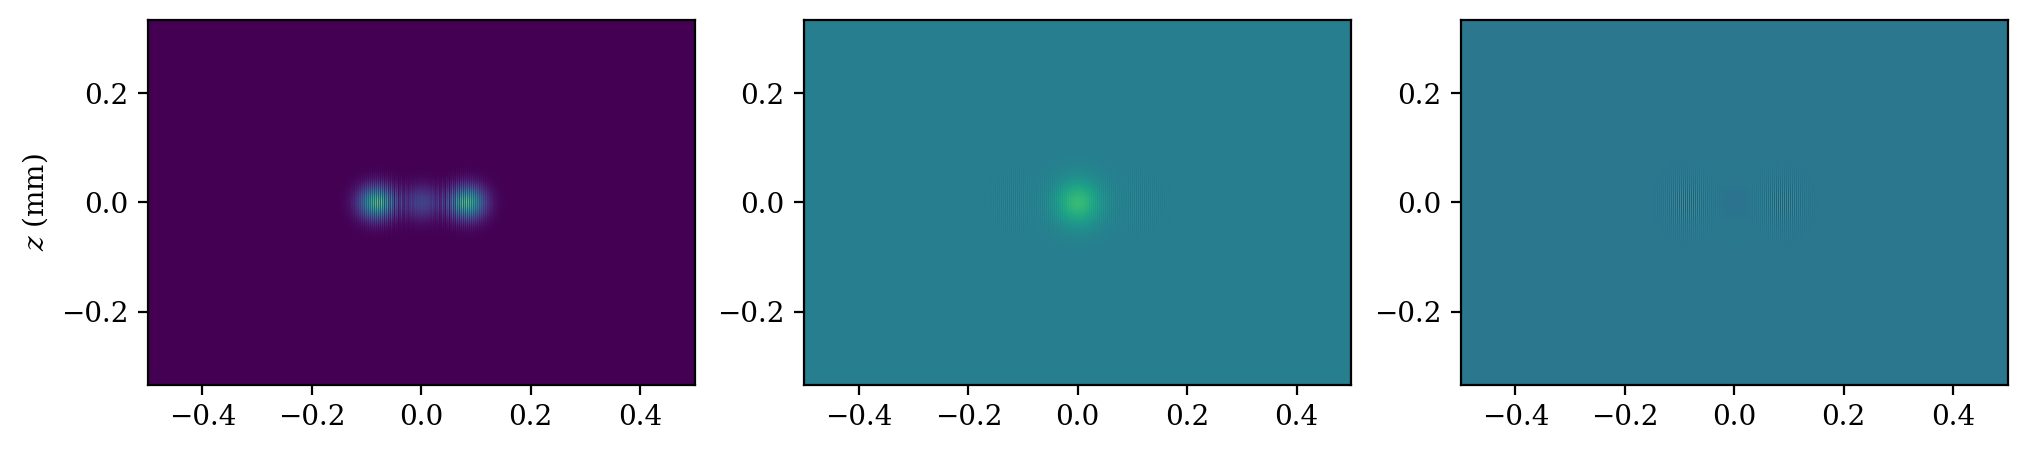

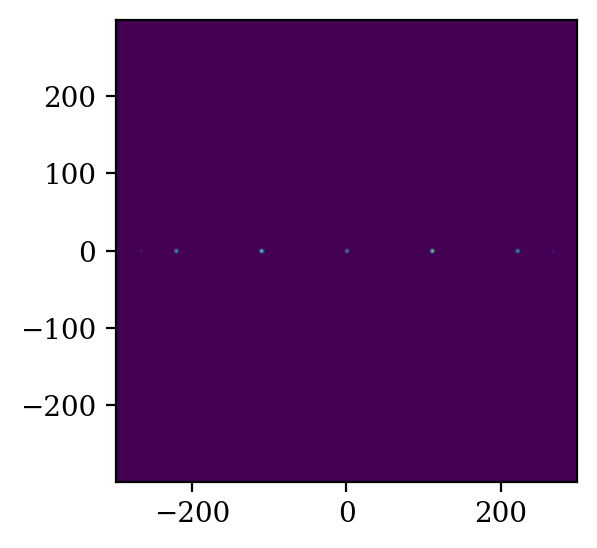

time = 4.8 ms
1.737545130901382 |psi|^2


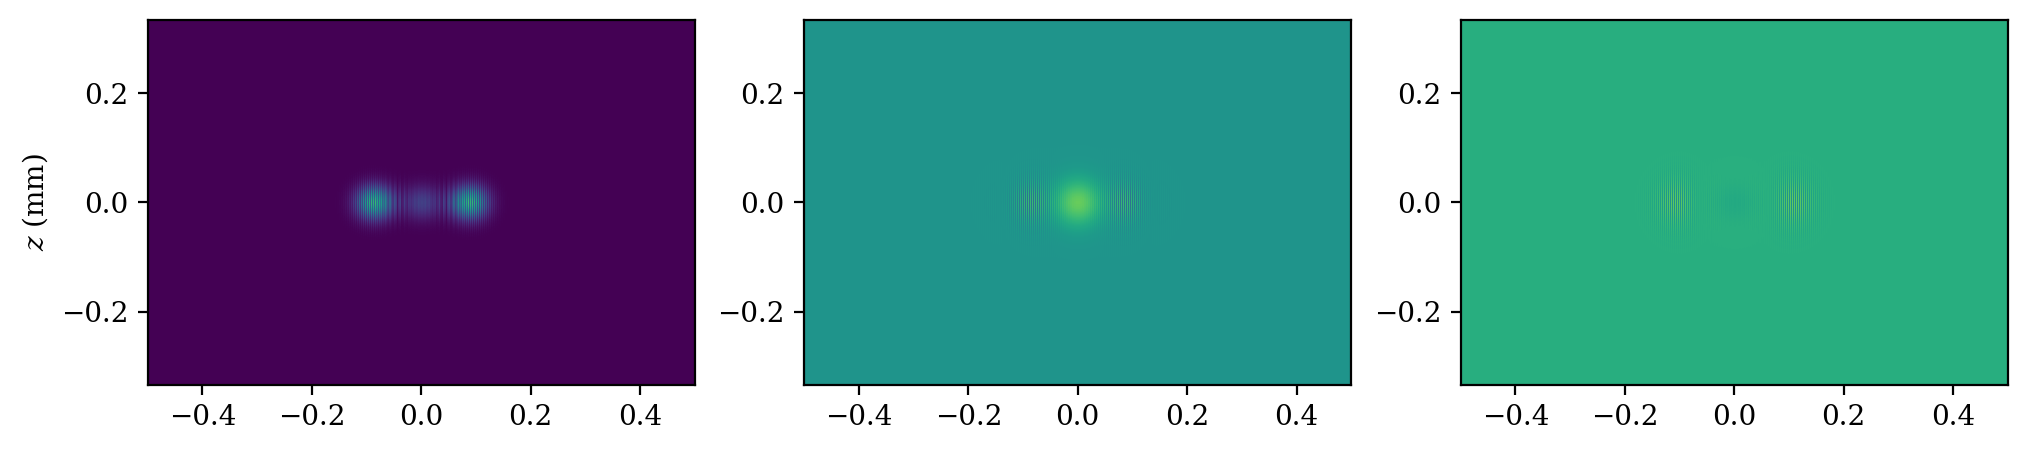

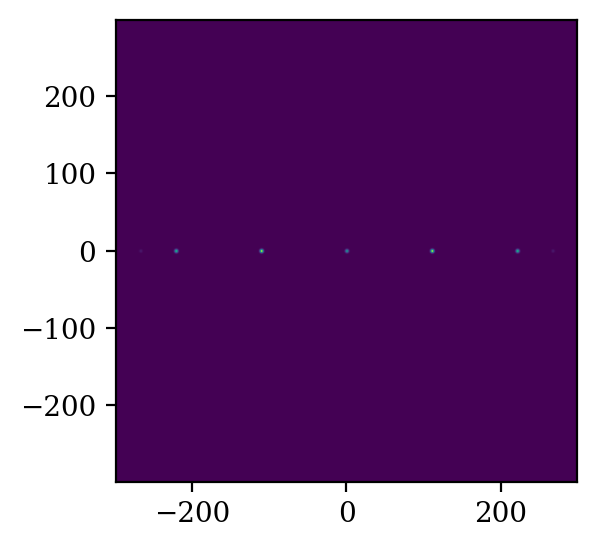

time = 5.0 ms
1.7958974346605048 |psi|^2


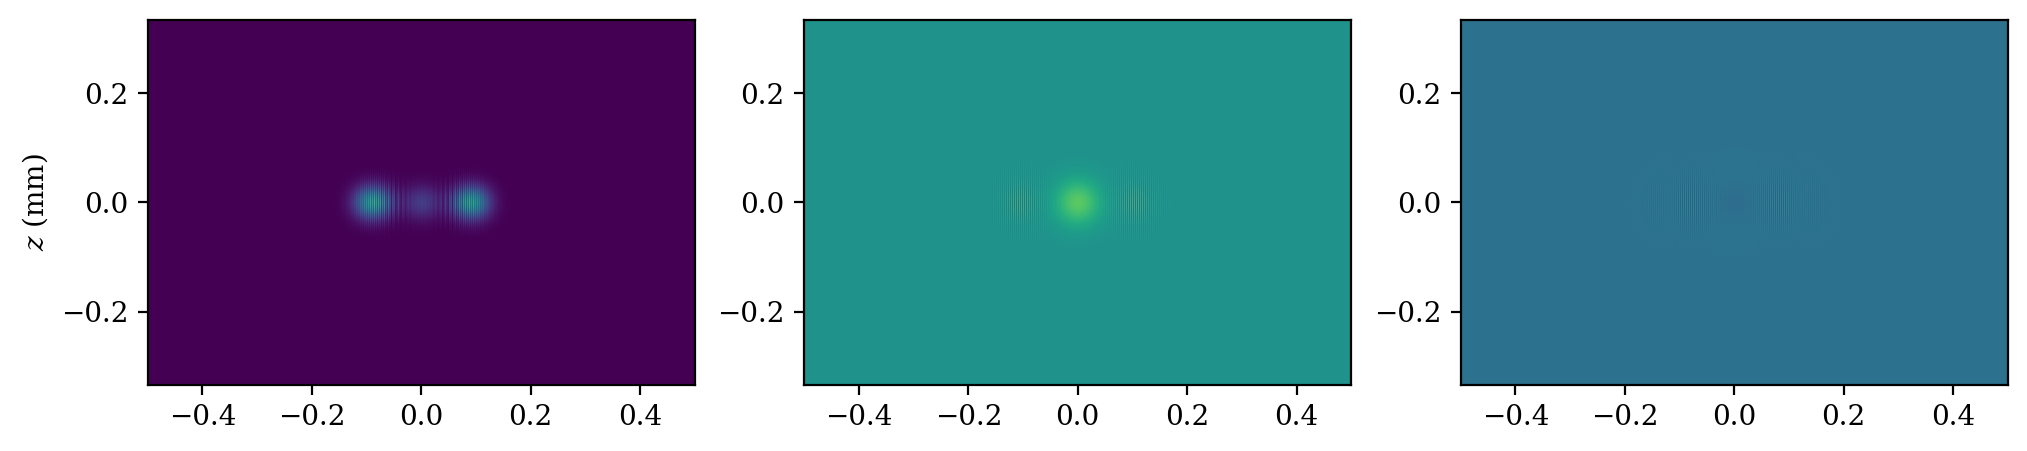

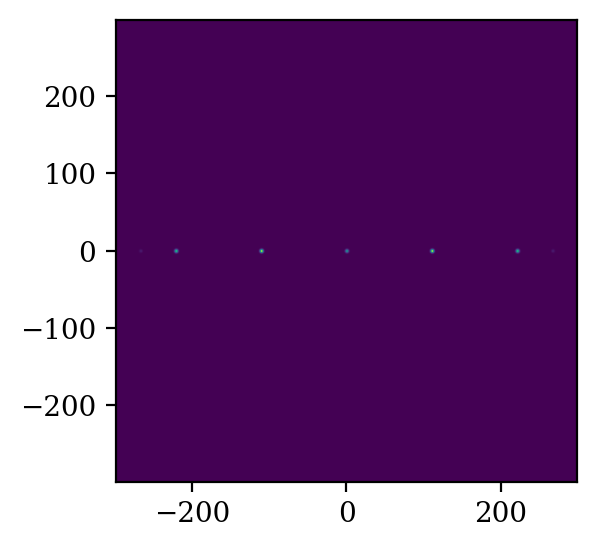

In [227]:
(t,psi) = runNBWithPlots(psi0np(30,30,0,0),0,5,0.2)

Initial state at t = 5.0 ms Target end time at  20 ms


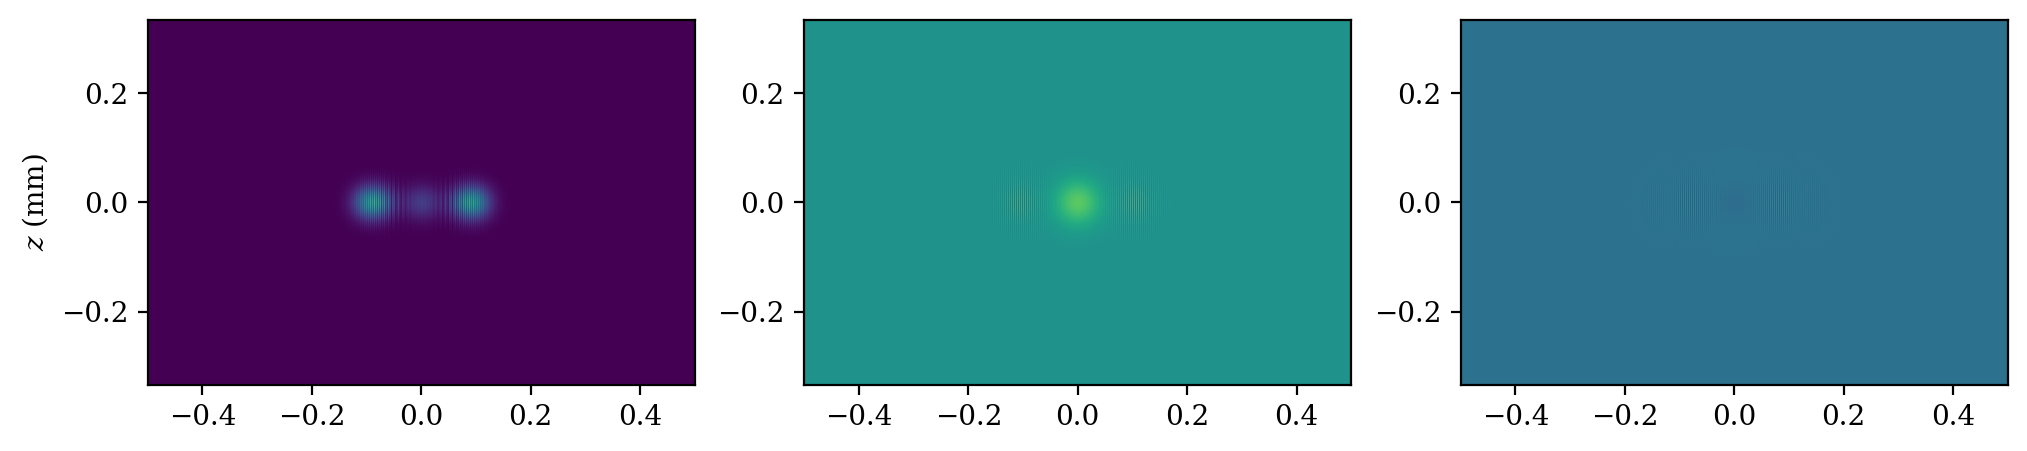

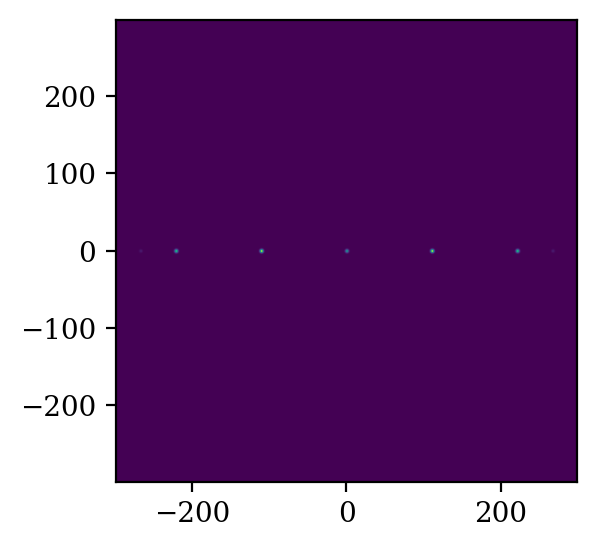

  0%|          | 0/29 [00:00<?, ?it/s]

time = 5.5 ms
1.9600194105786266 |psi|^2


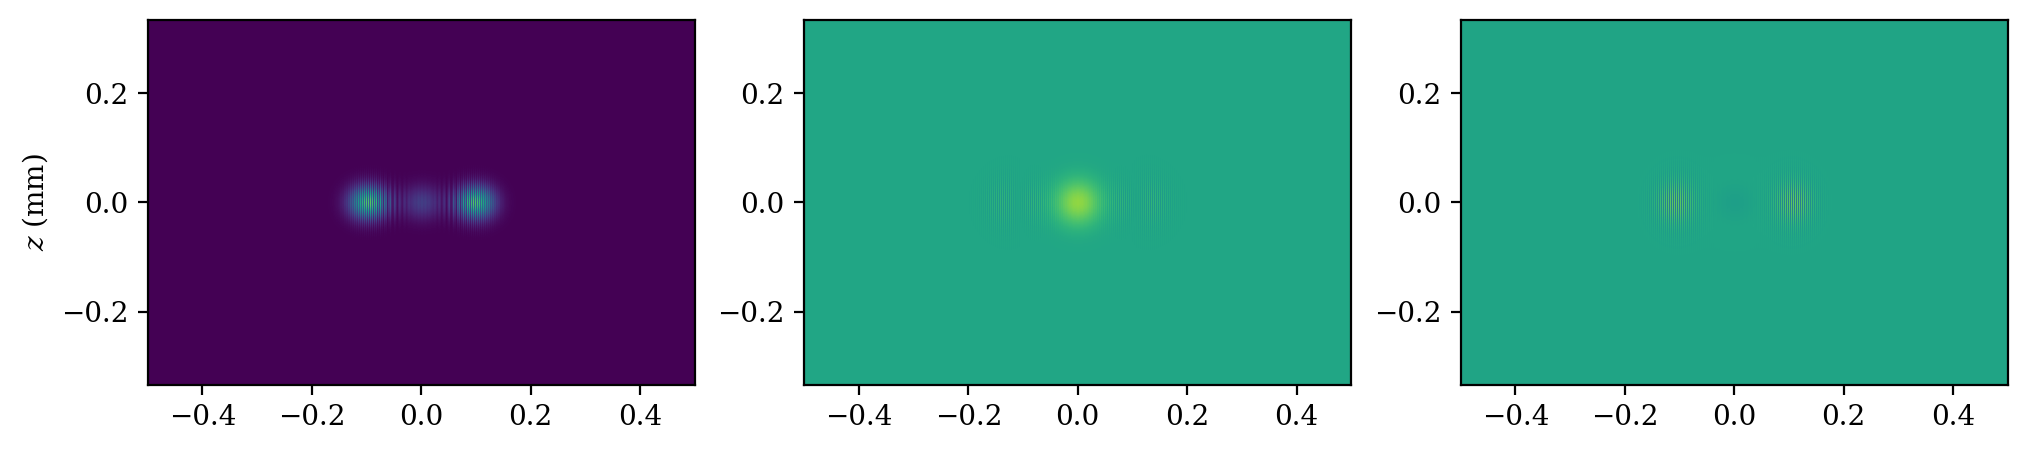

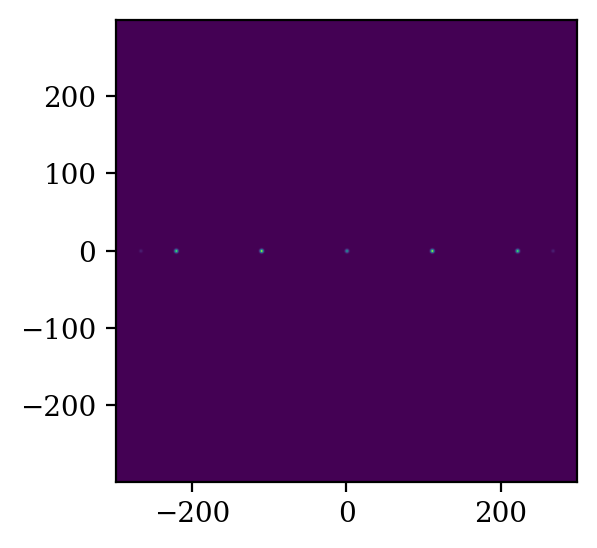

time = 6.0 ms
2.1544674295845034 |psi|^2


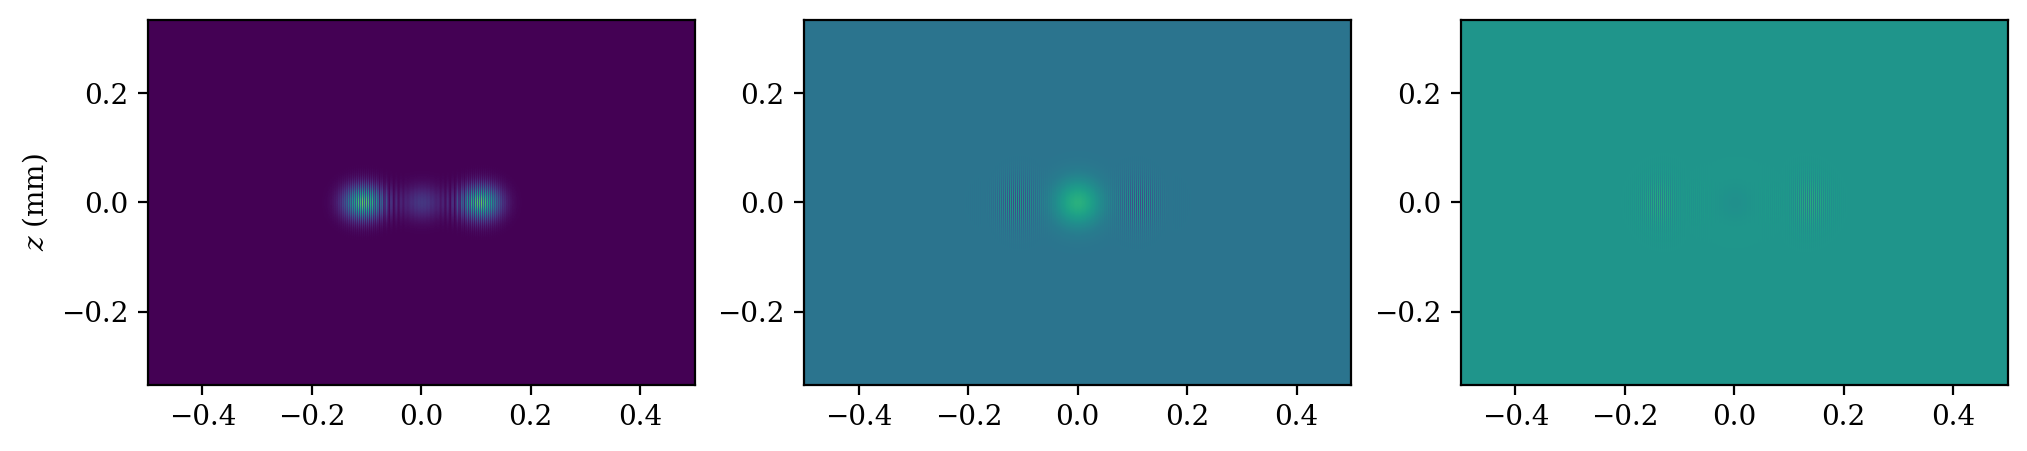

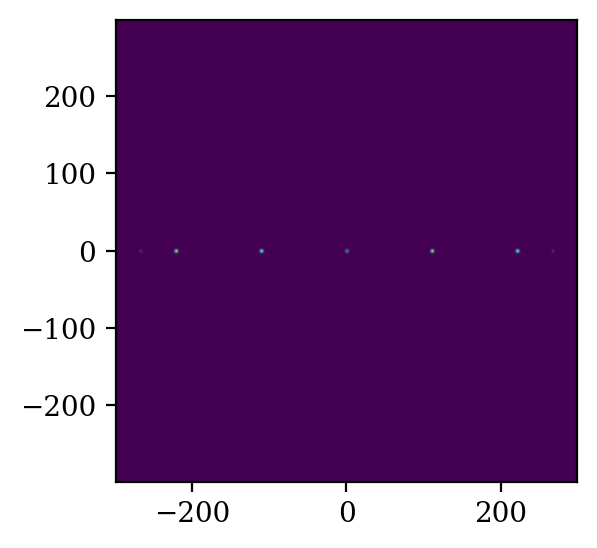

time = 6.5 ms
2.3855364813395776 |psi|^2


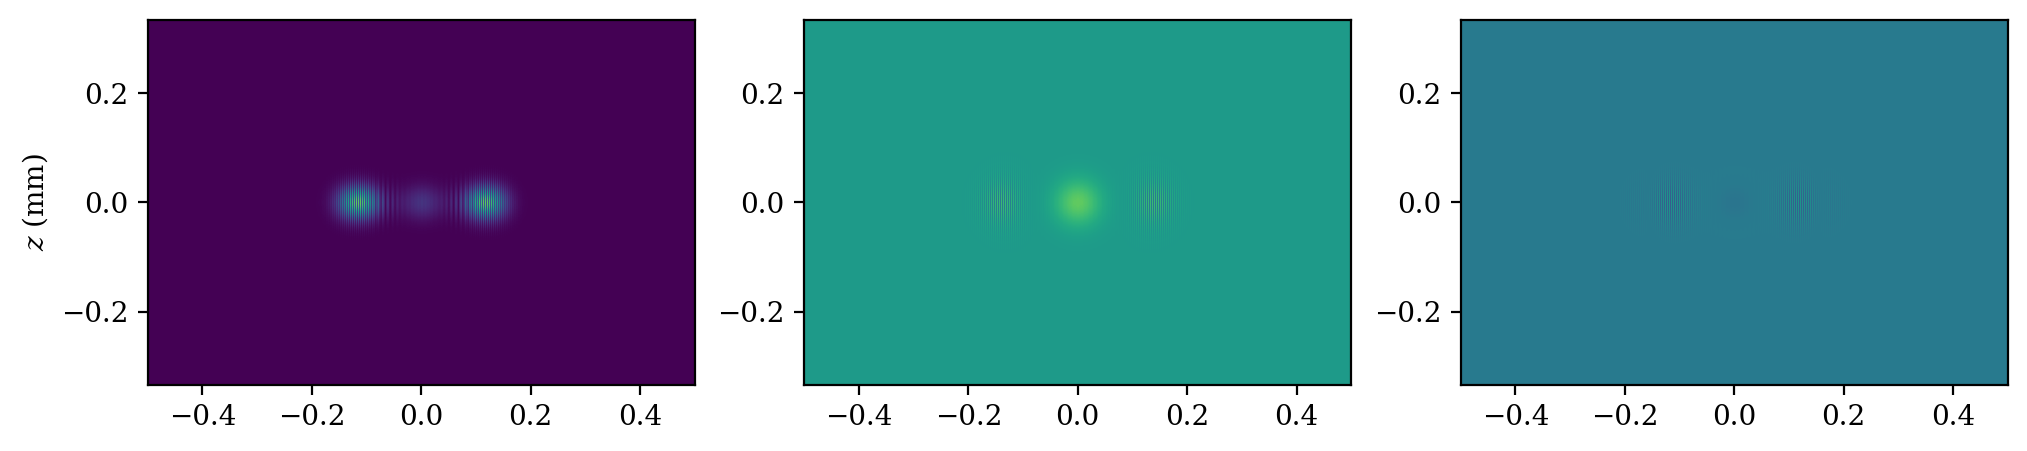

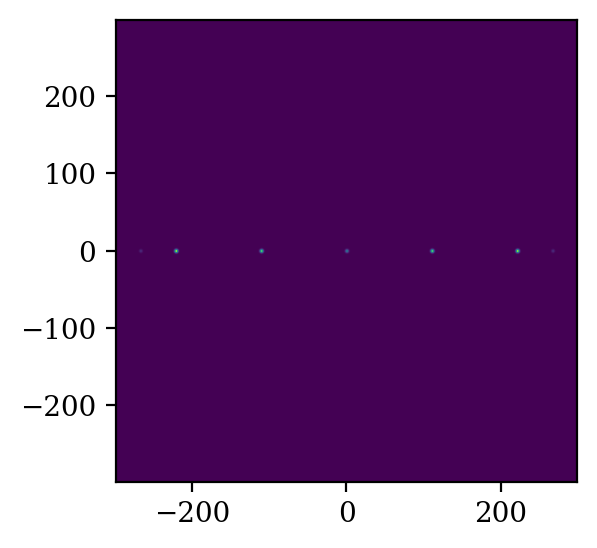

time = 7.0 ms
2.66086811182505 |psi|^2


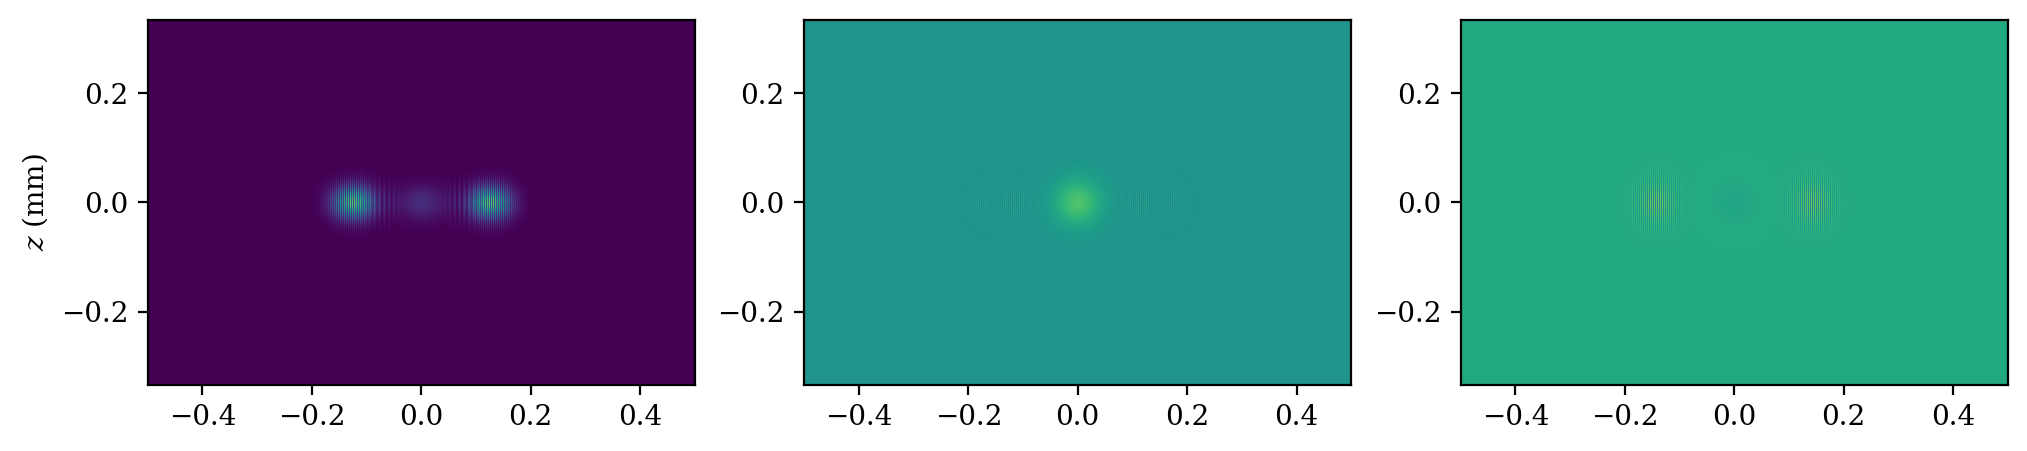

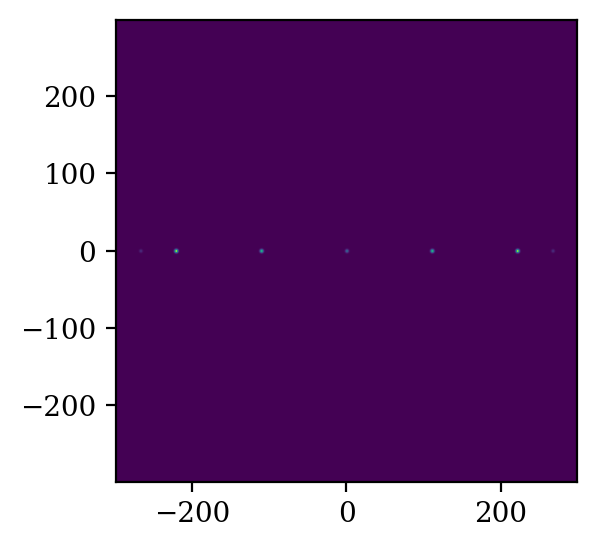

time = 7.5 ms
2.9897448790098697 |psi|^2


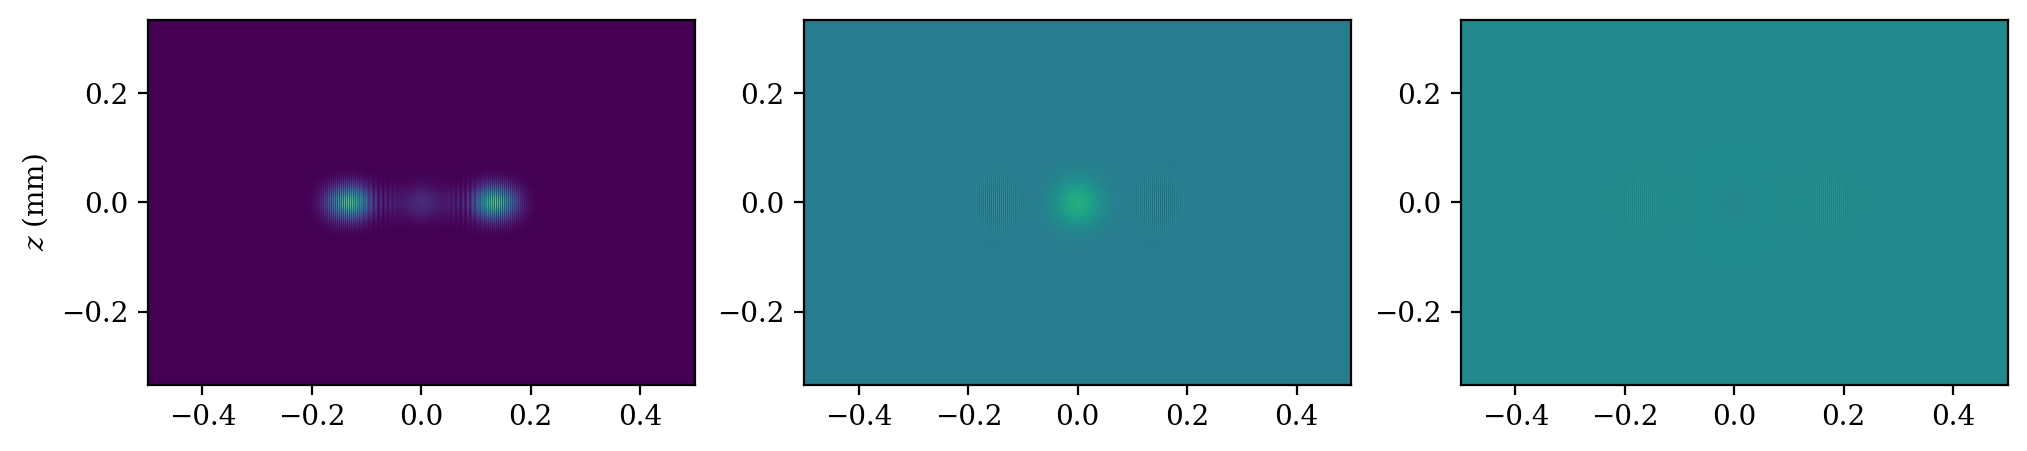

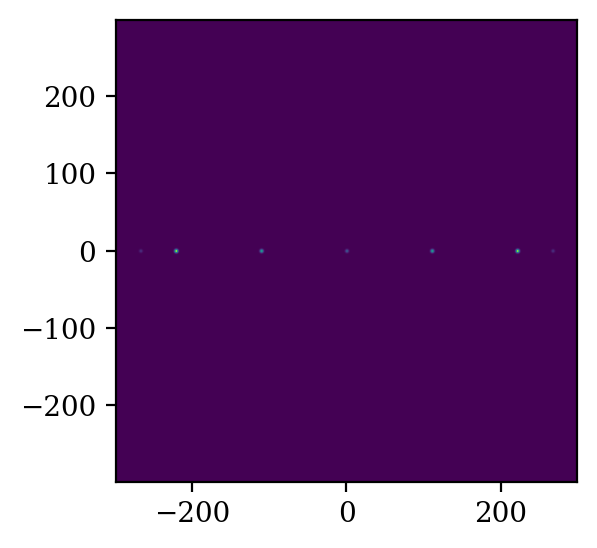

time = 8.0 ms
3.383450716801871 |psi|^2


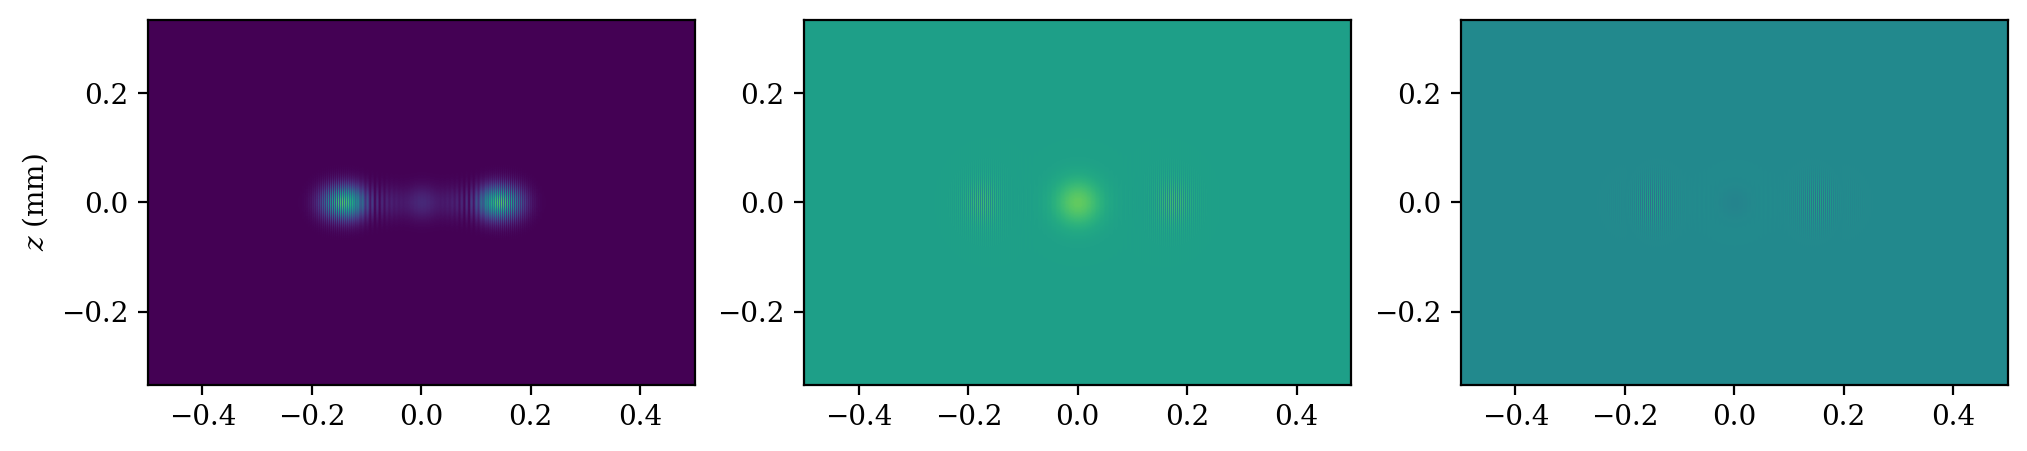

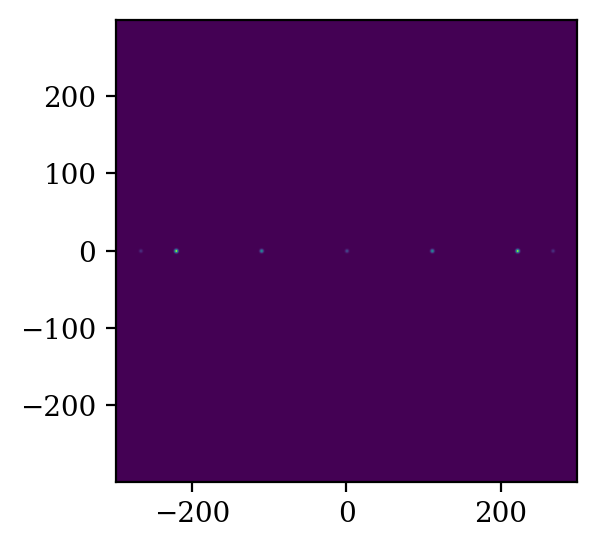

time = 8.5 ms
3.8557123311380472 |psi|^2


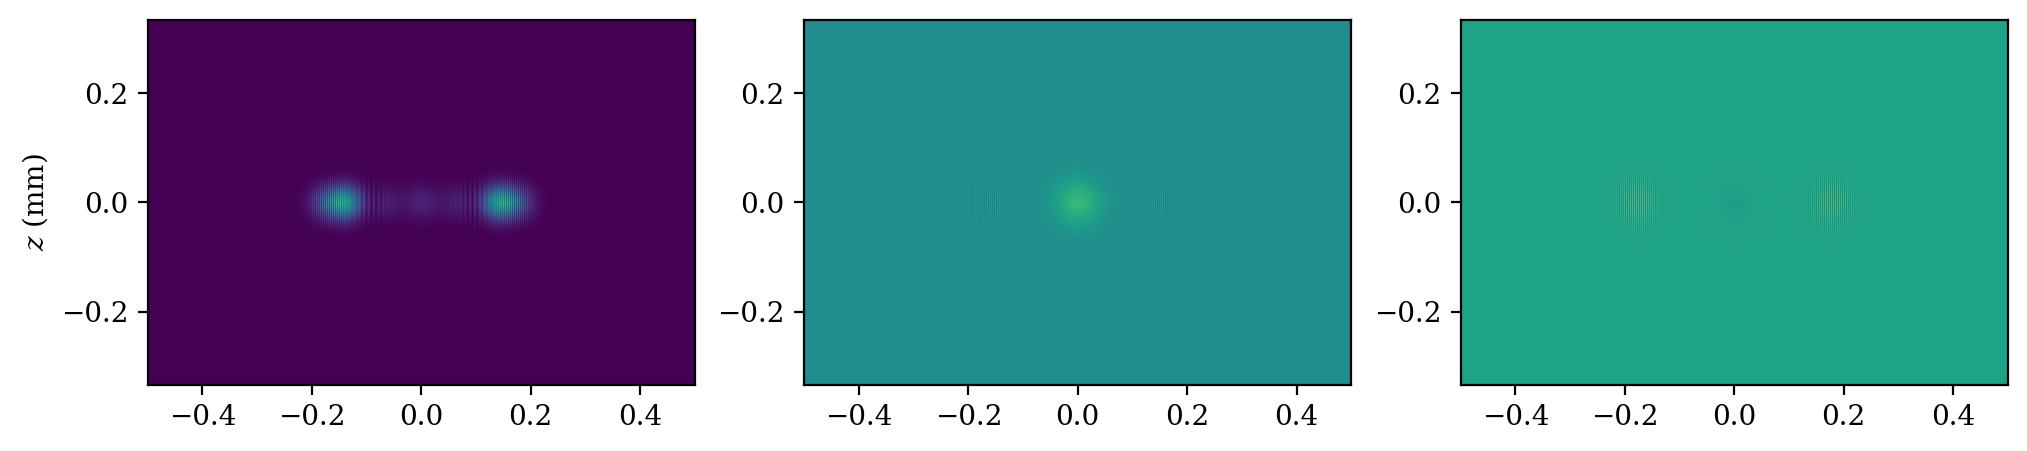

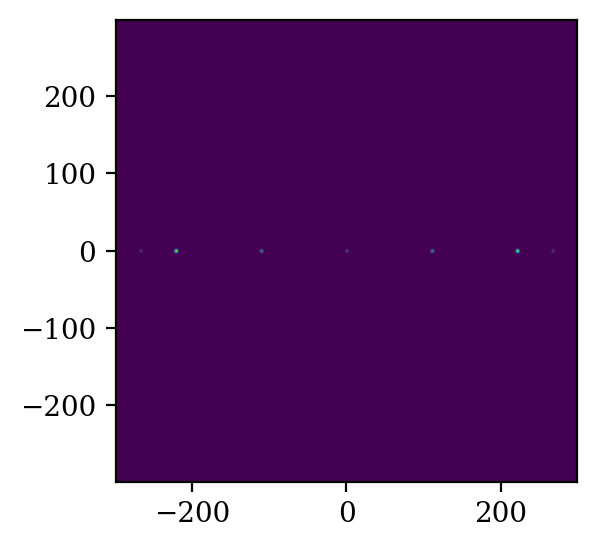

time = 9.0 ms
4.423240311860773 |psi|^2


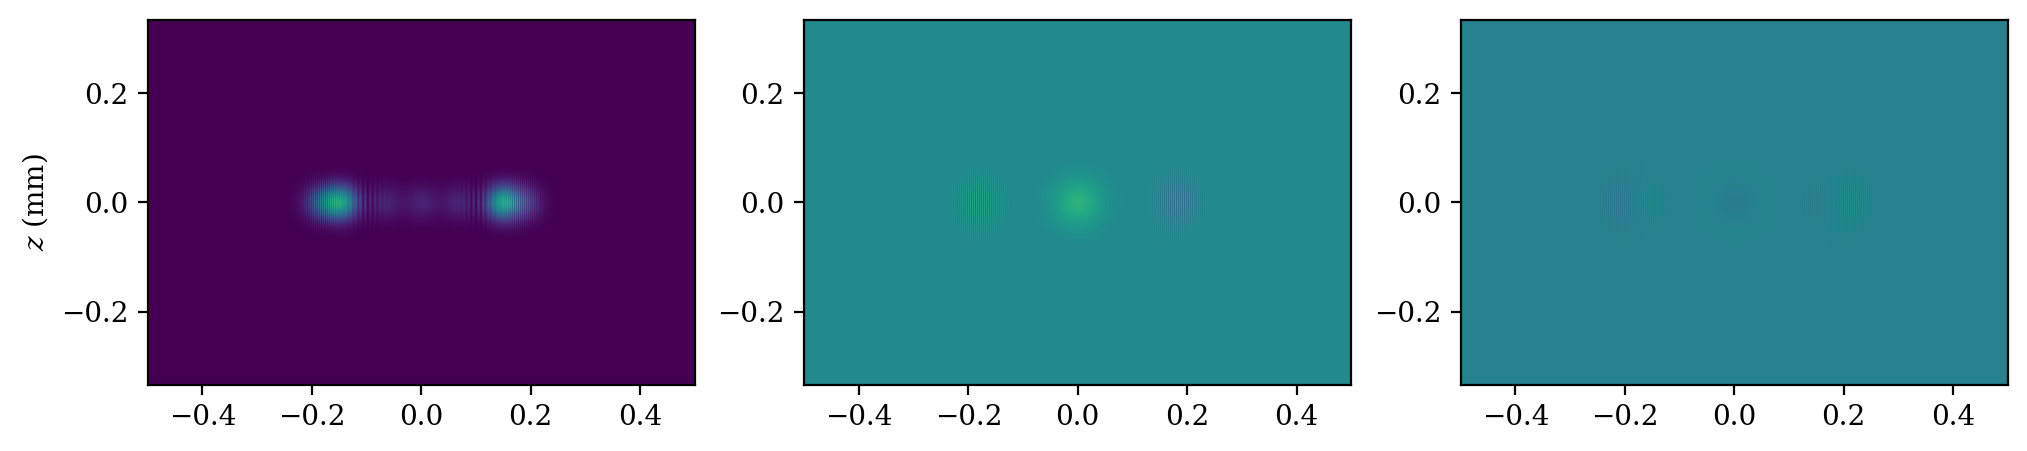

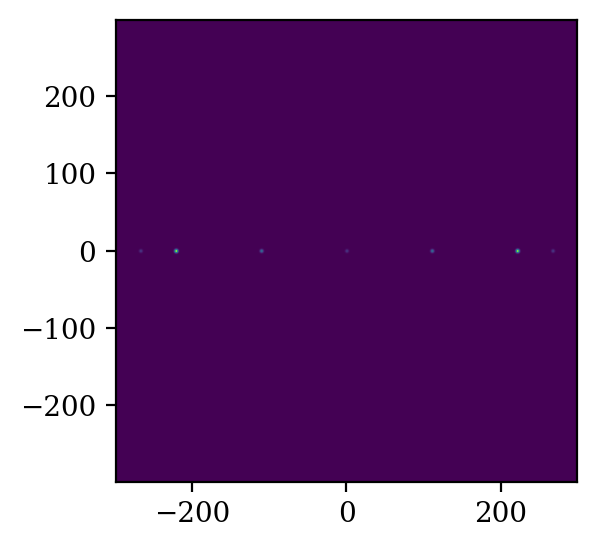

time = 9.5 ms
5.106393062687159 |psi|^2


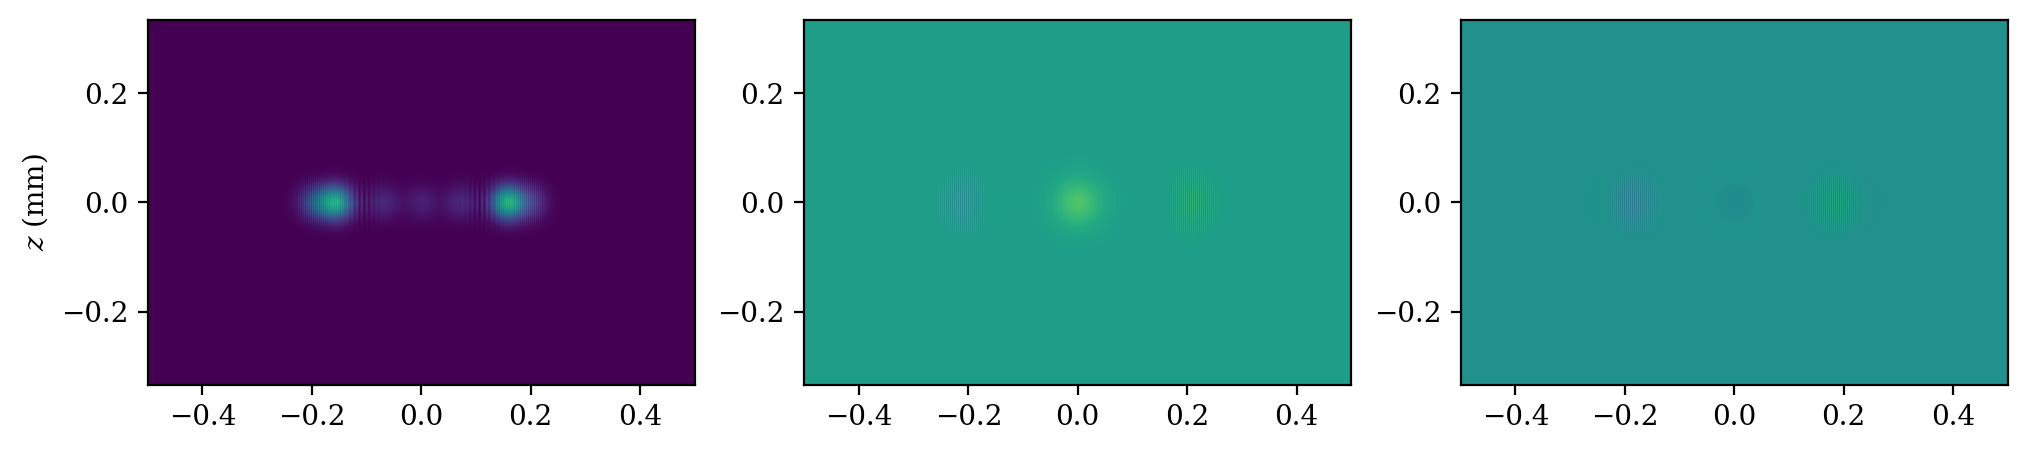

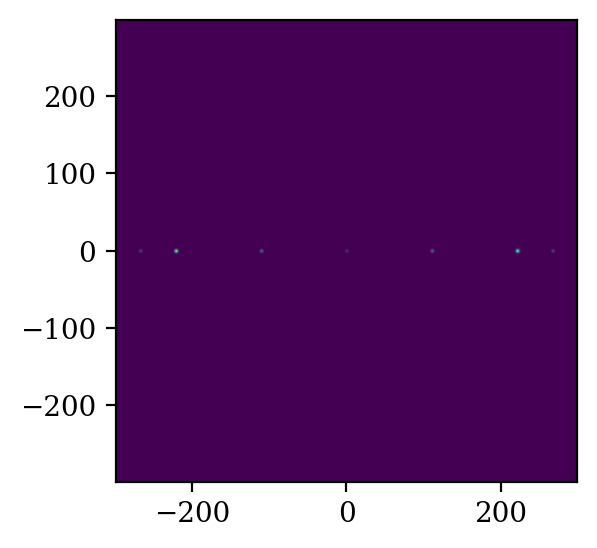

time = 10.0 ms
5.929992141133447 |psi|^2


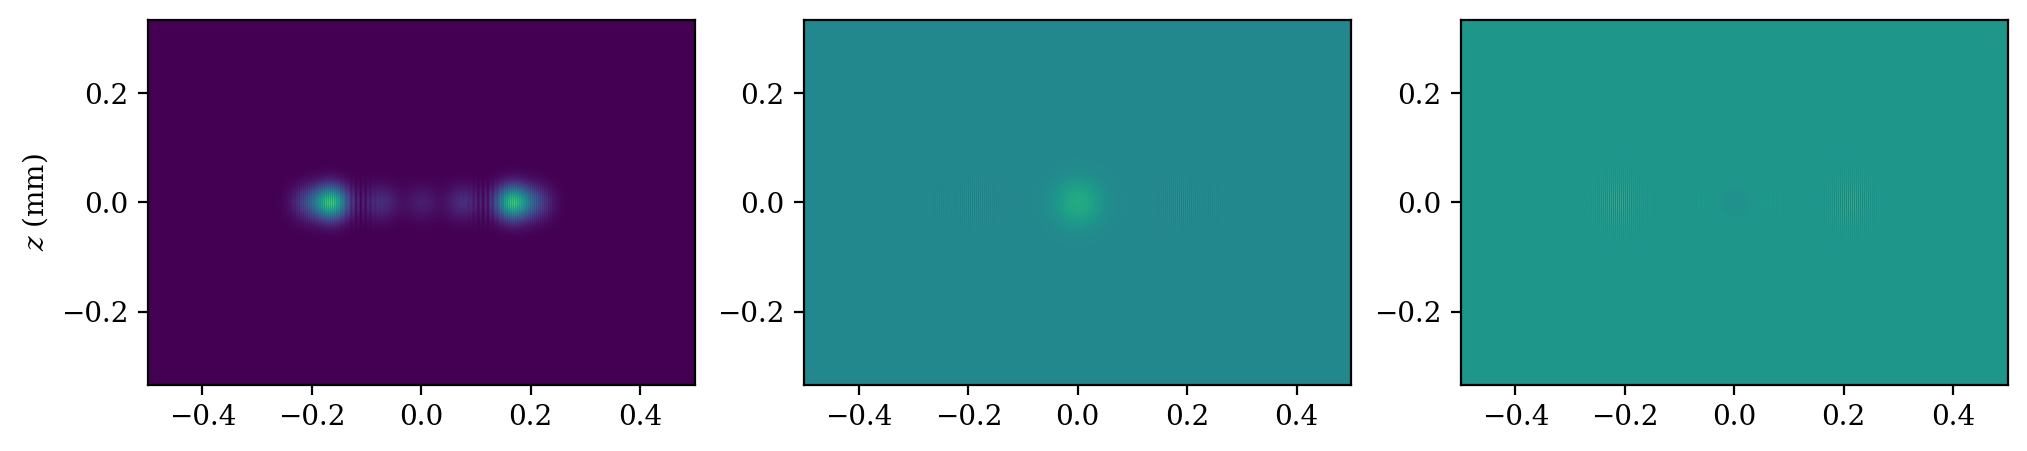

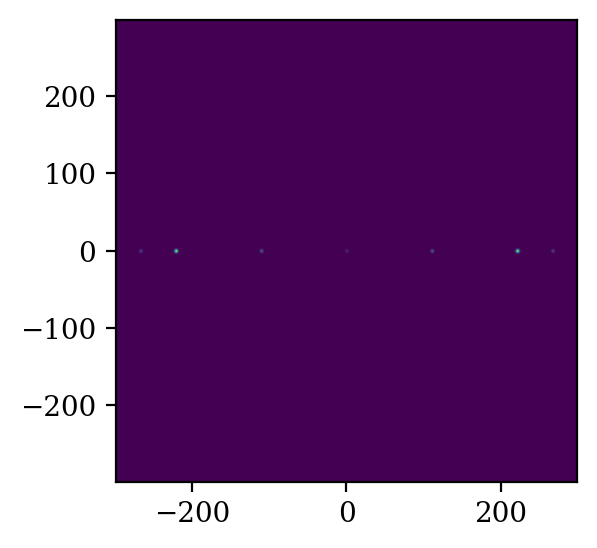

time = 10.5 ms
6.924324426146243 |psi|^2


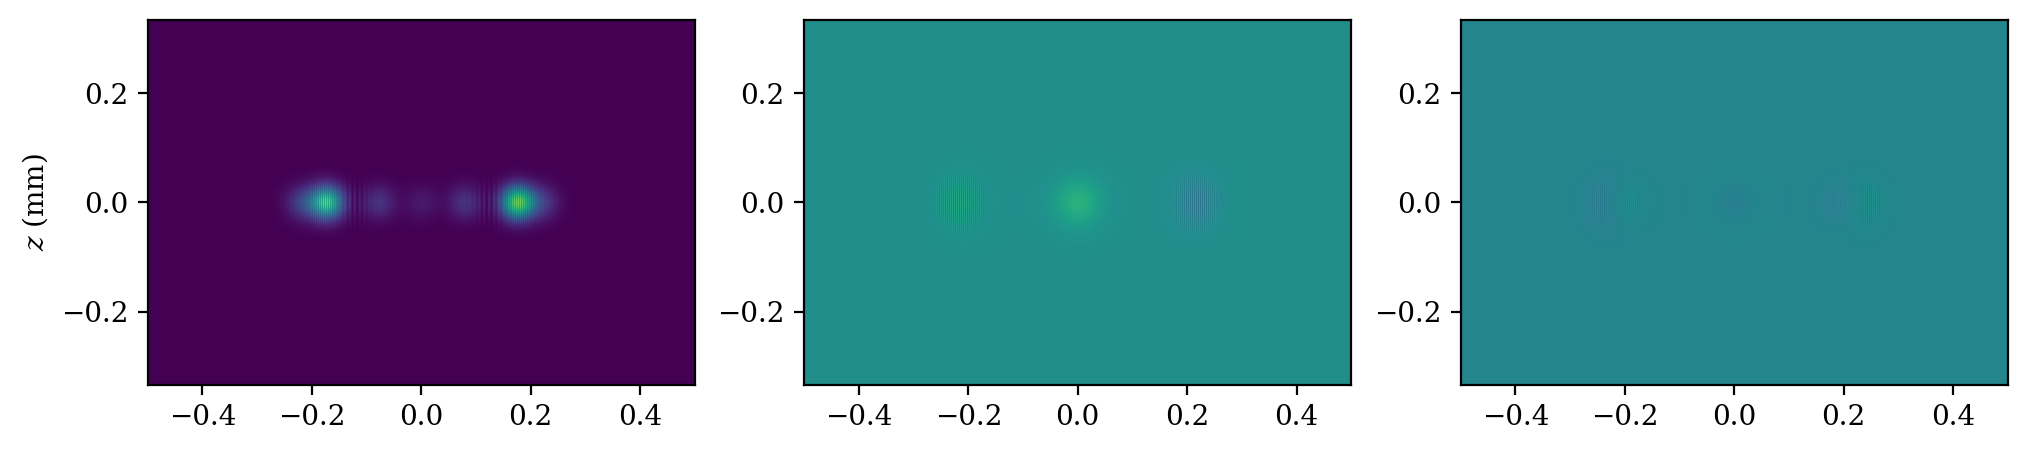

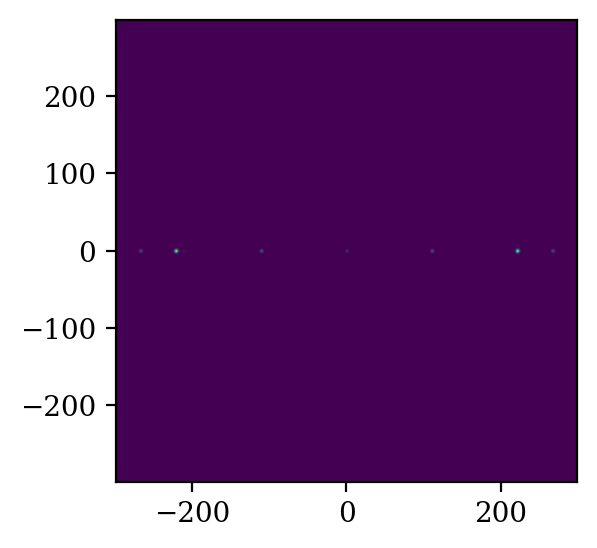

time = 11.0 ms
8.126375025965649 |psi|^2


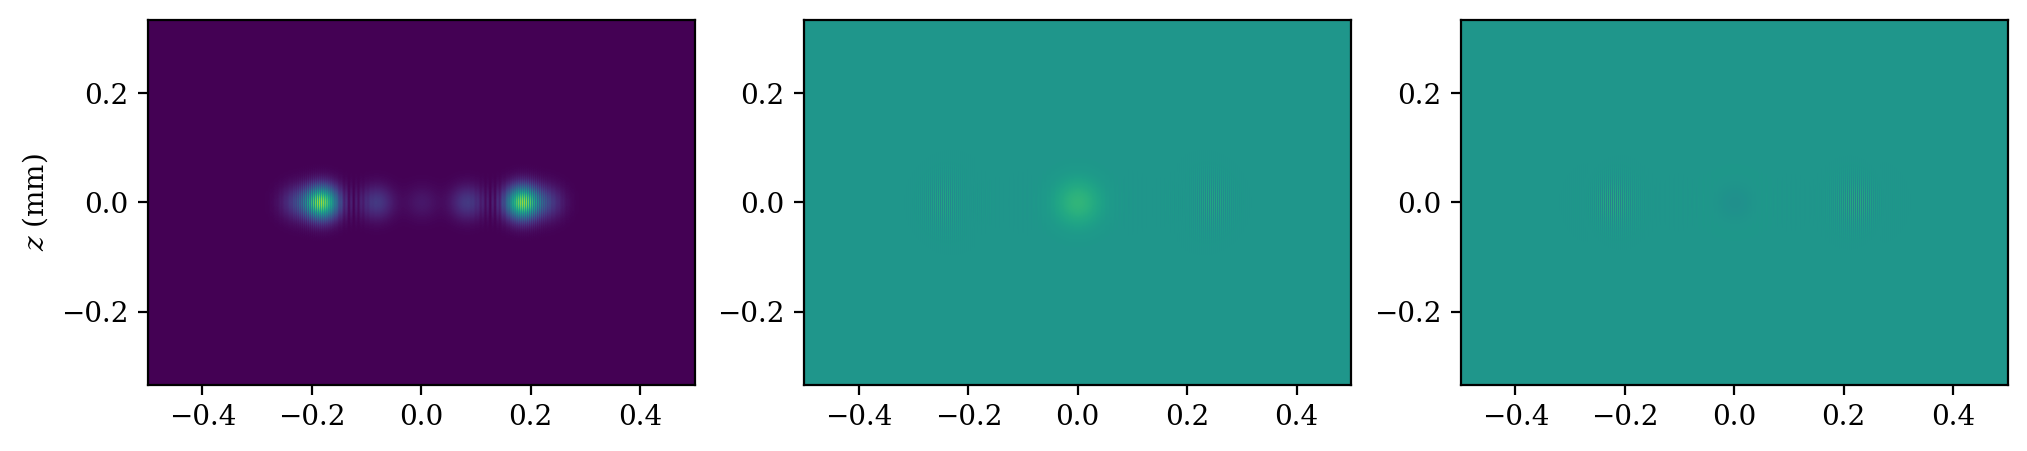

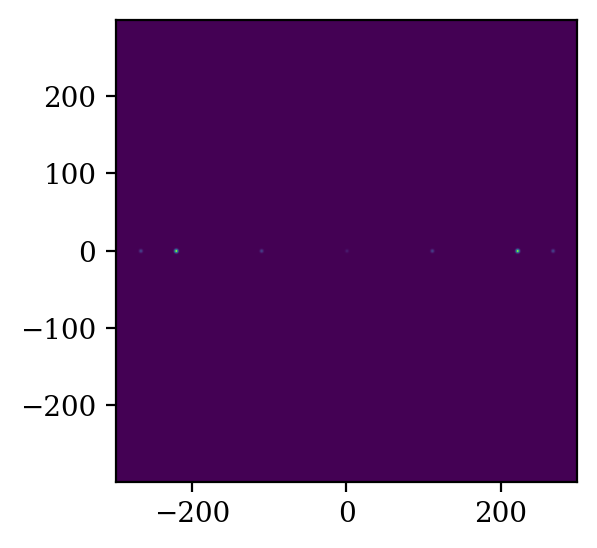

time = 11.5 ms
9.5813454193108 |psi|^2


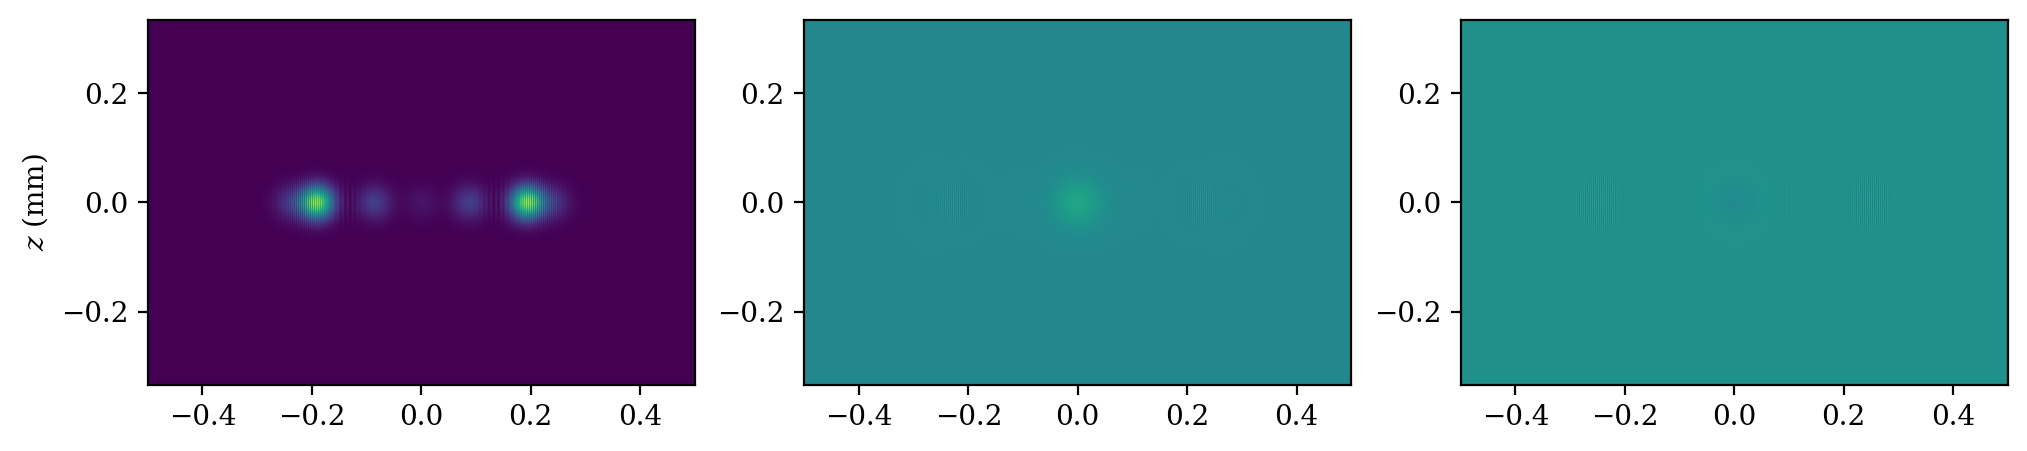

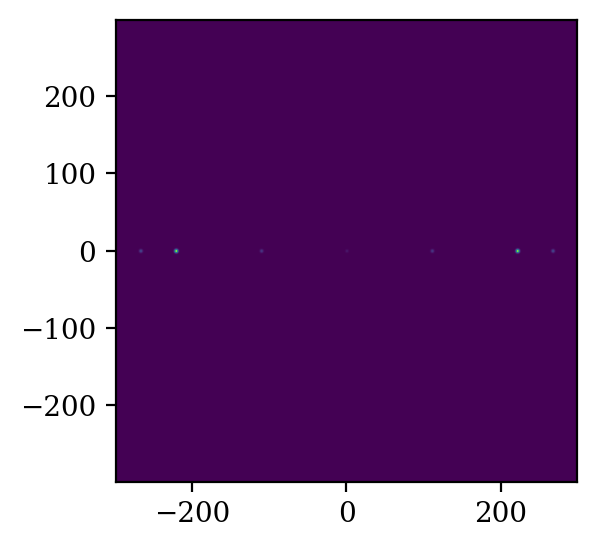

time = 12.0 ms
11.34452451235204 |psi|^2


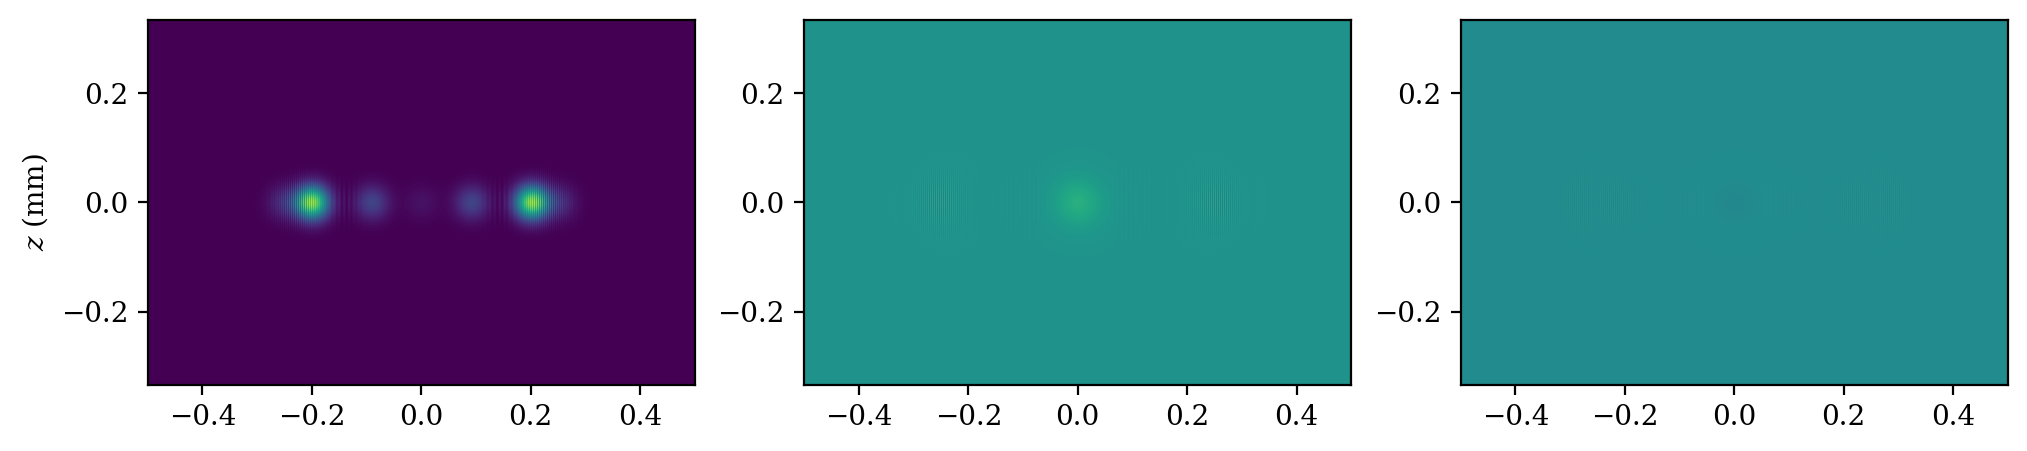

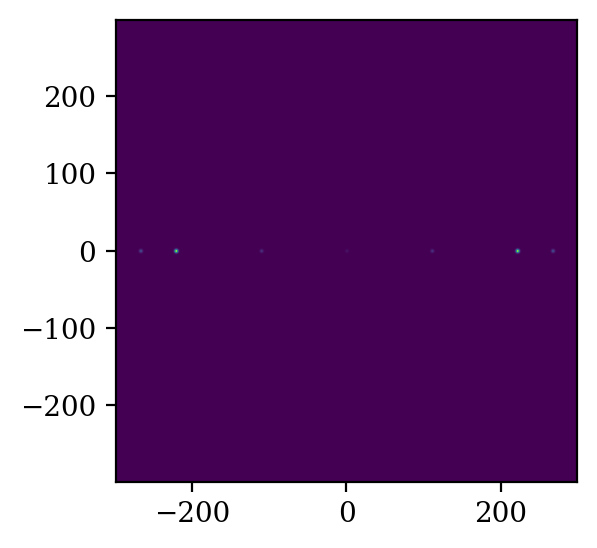

time = 12.5 ms
13.483596748669061 |psi|^2


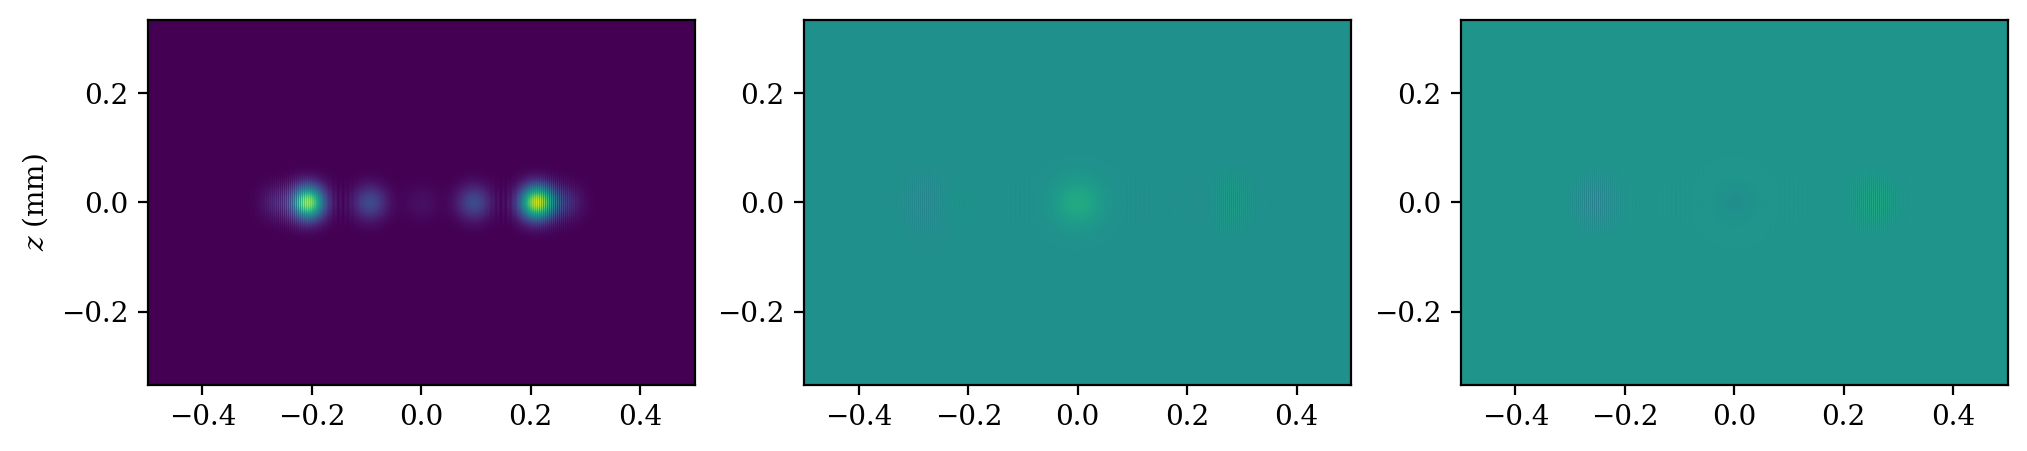

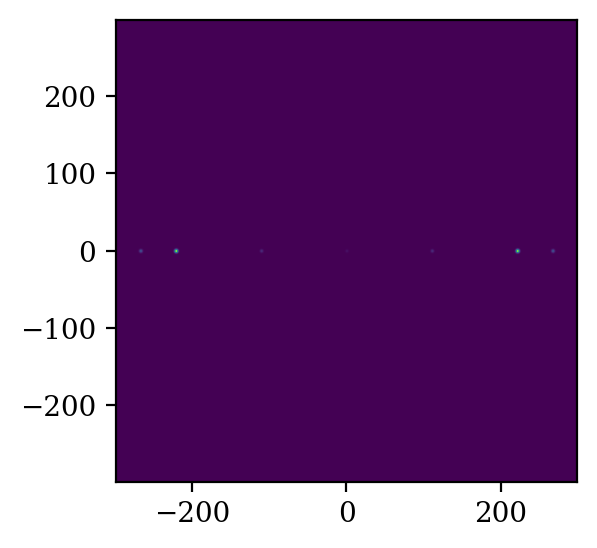

time = 13.0 ms
16.08149195419106 |psi|^2


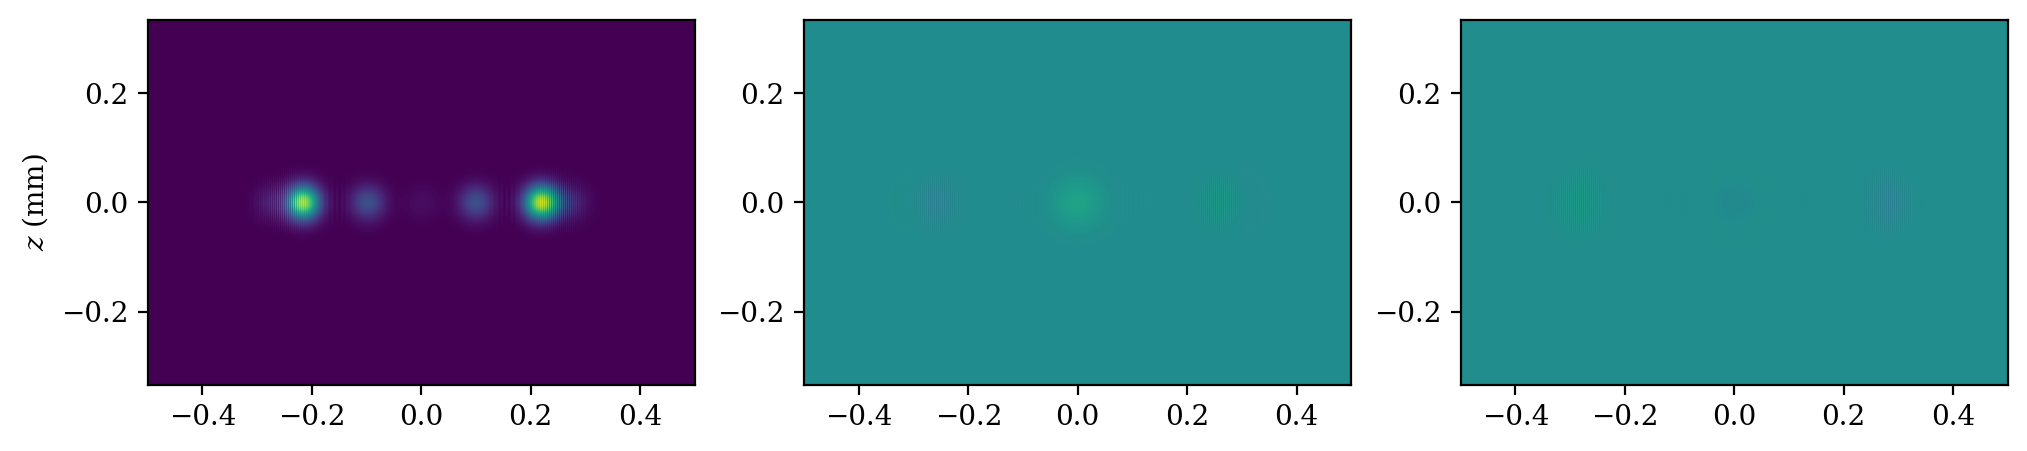

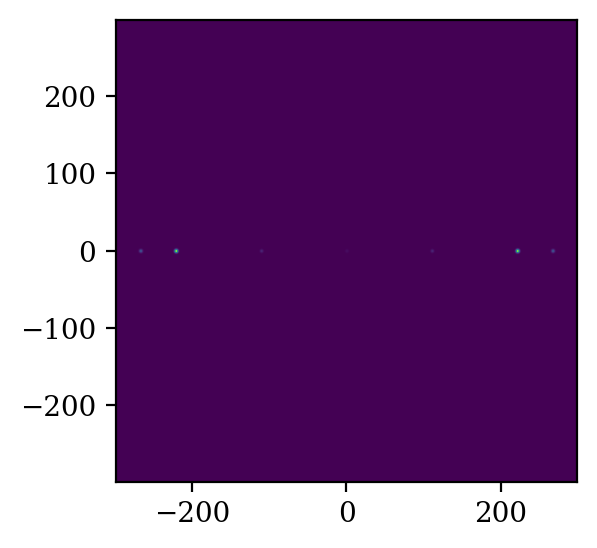

time = 13.5 ms
19.239907270505075 |psi|^2


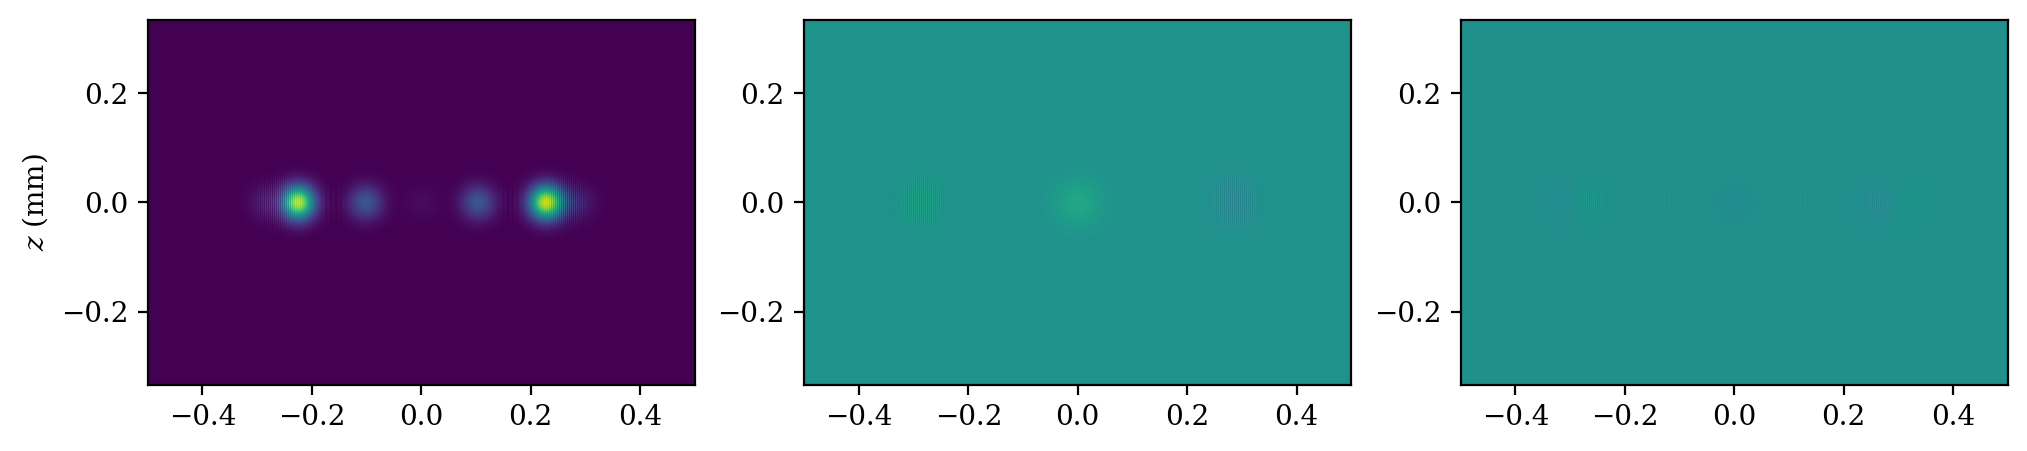

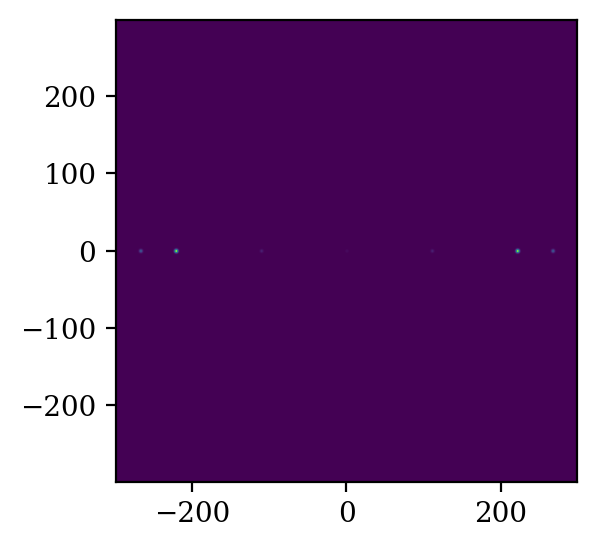

time = 14.0 ms
23.083663631442228 |psi|^2


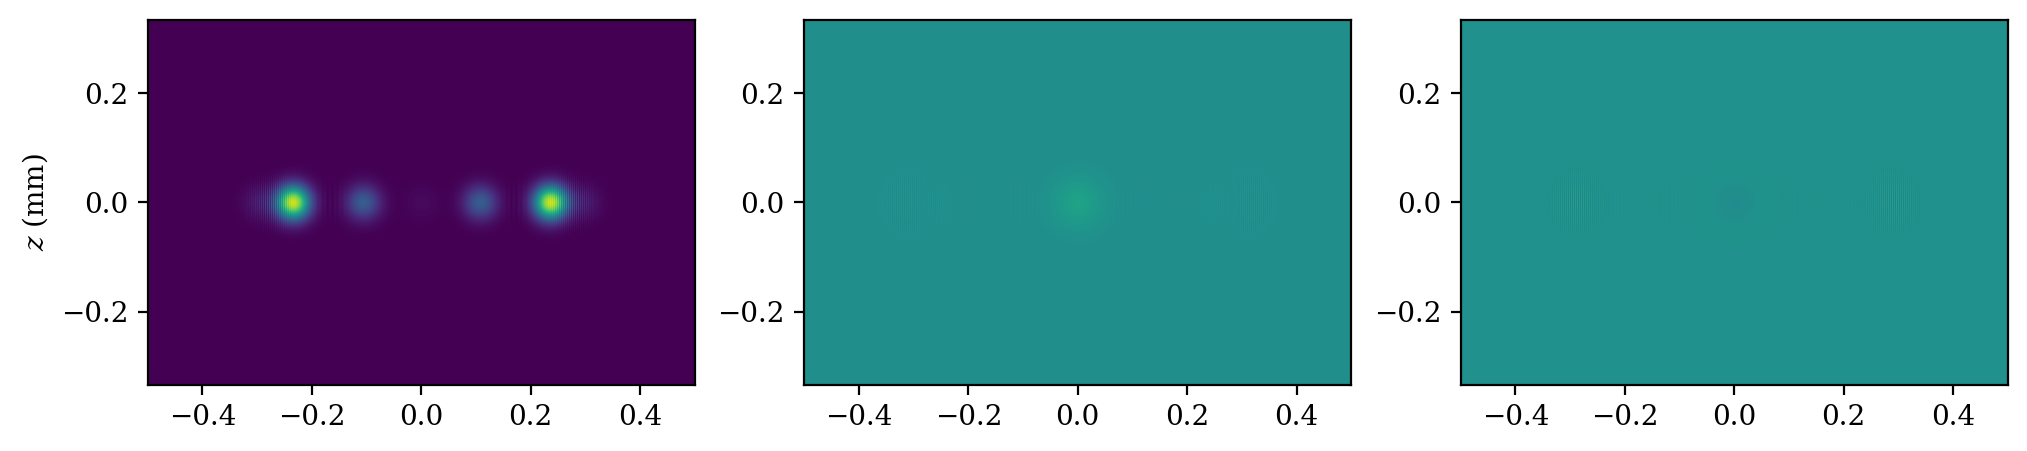

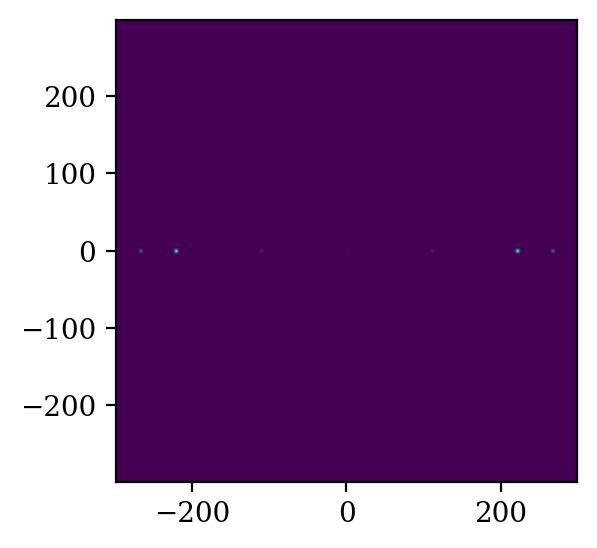

time = 14.5 ms
27.766099409744793 |psi|^2


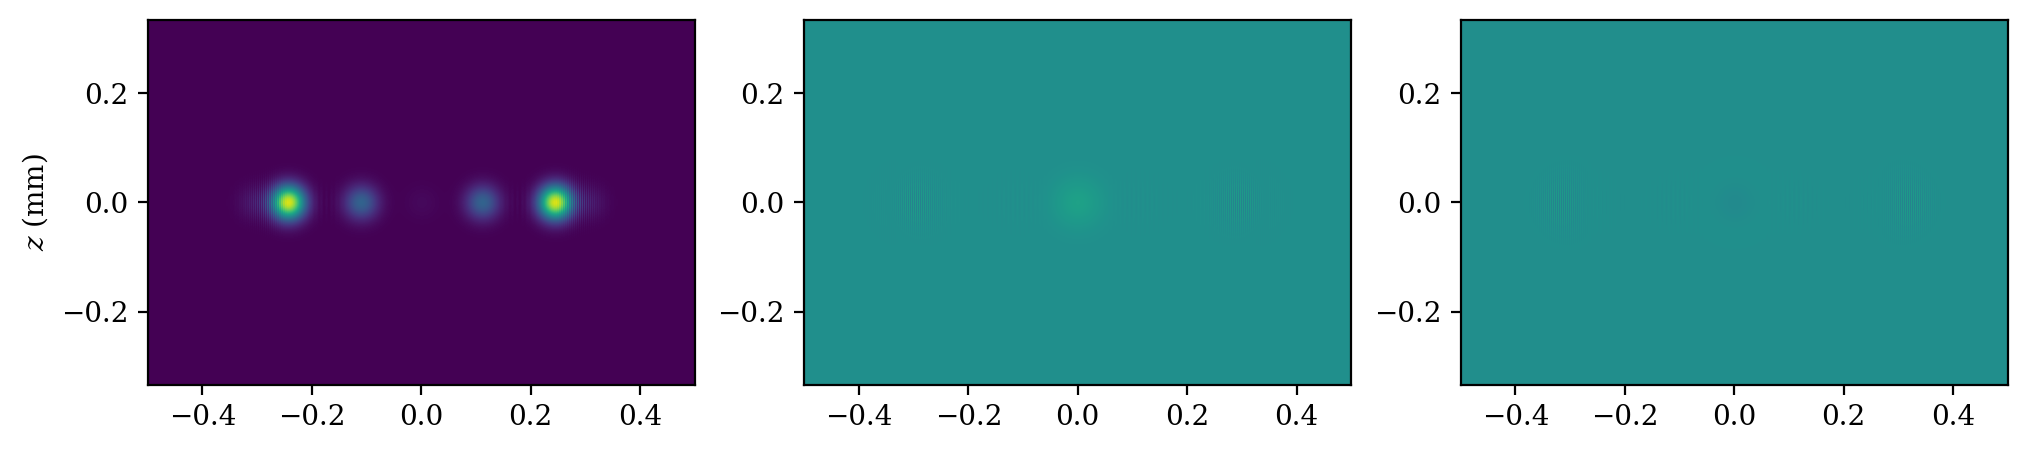

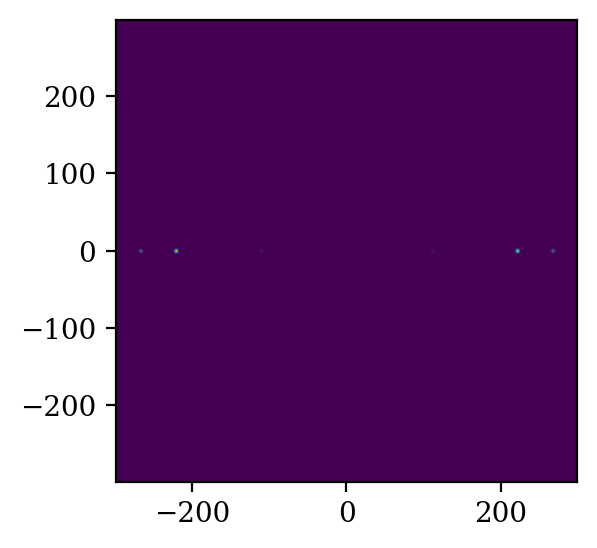

time = 15.0 ms
33.47575416791468 |psi|^2


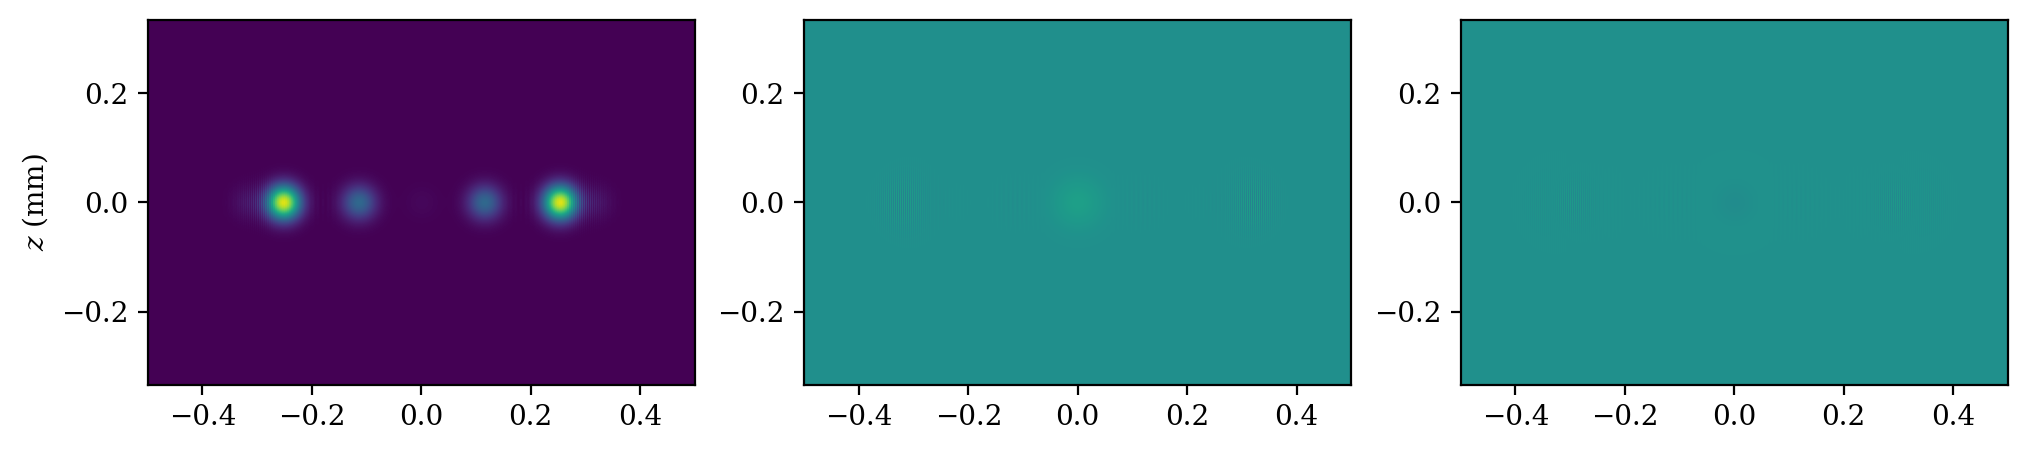

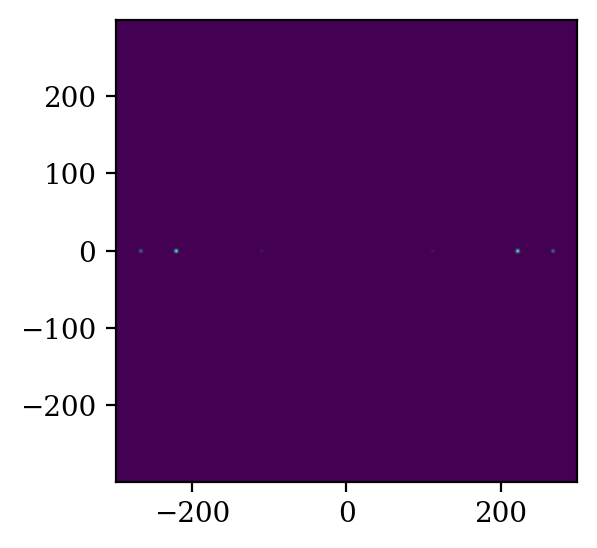

time = 15.5 ms
40.444658491219805 |psi|^2


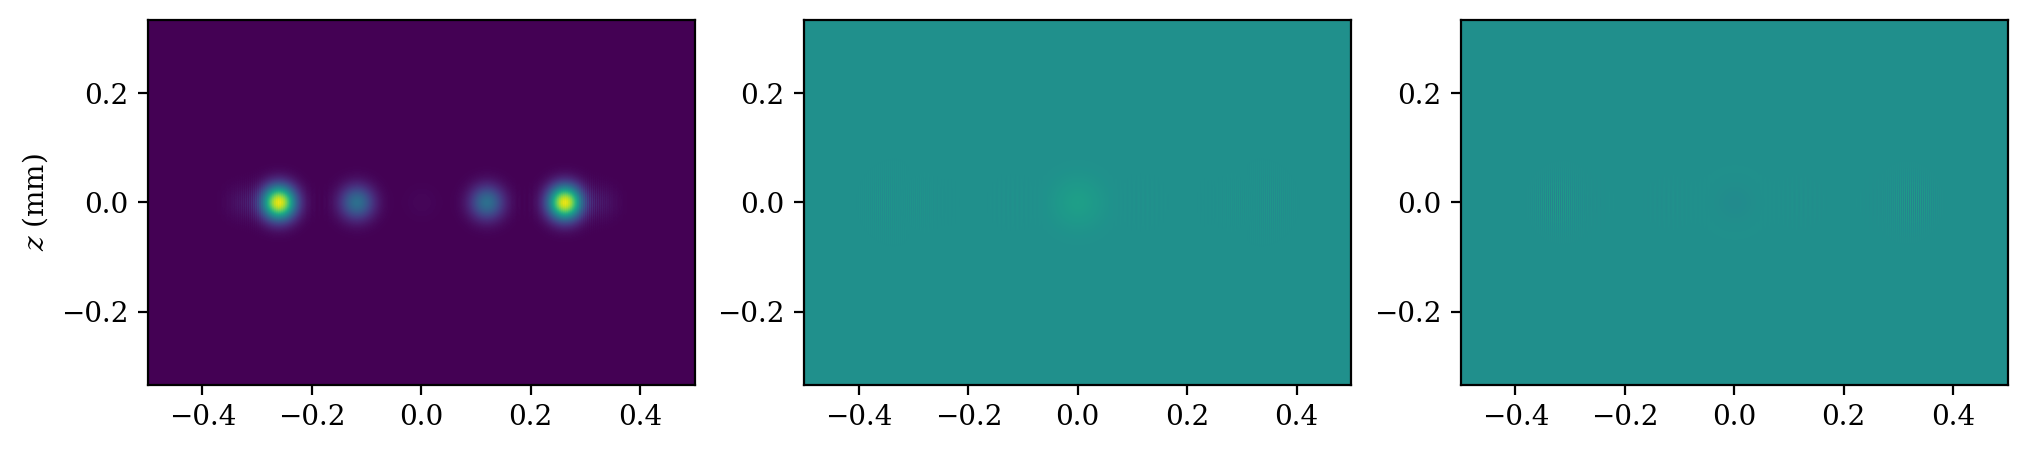

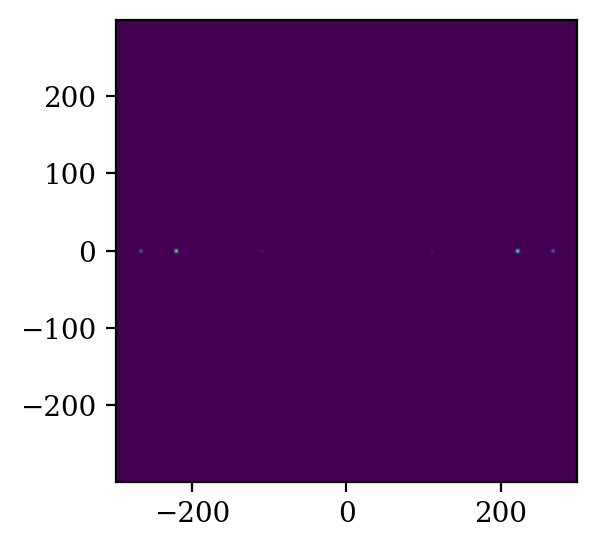

time = 16.0 ms
48.958624939466745 |psi|^2


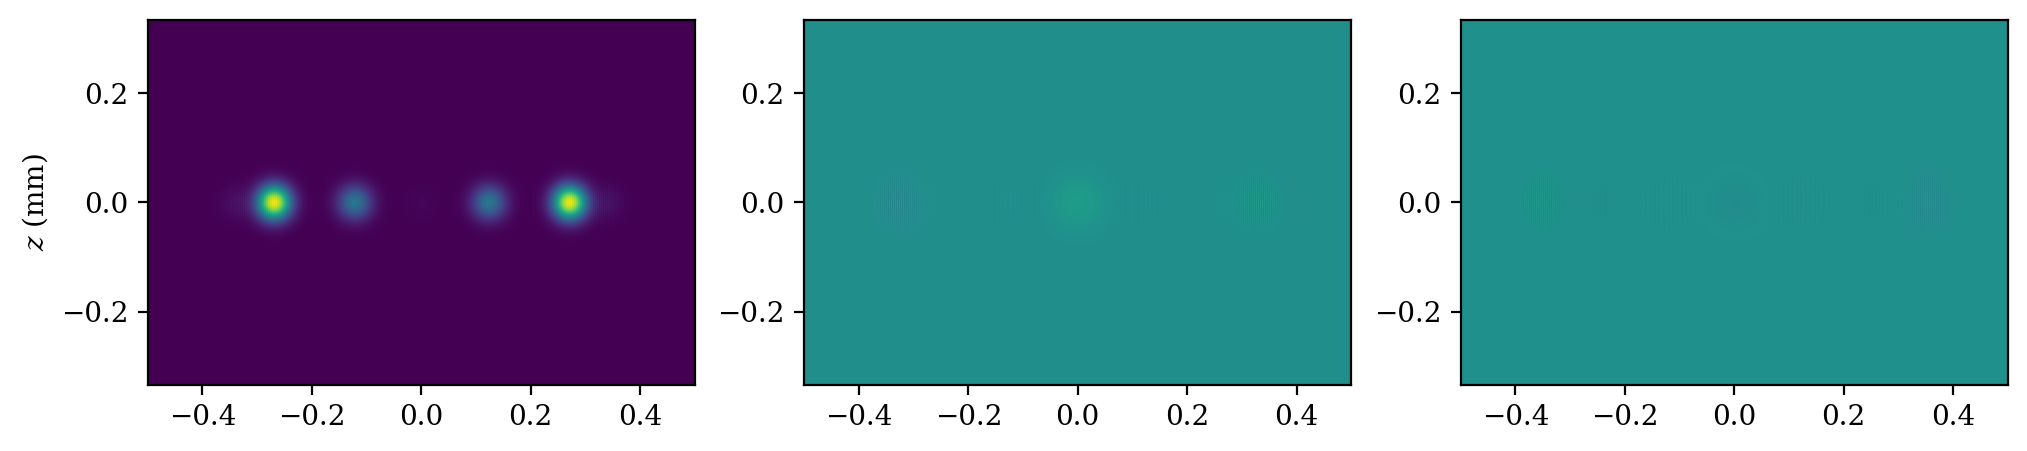

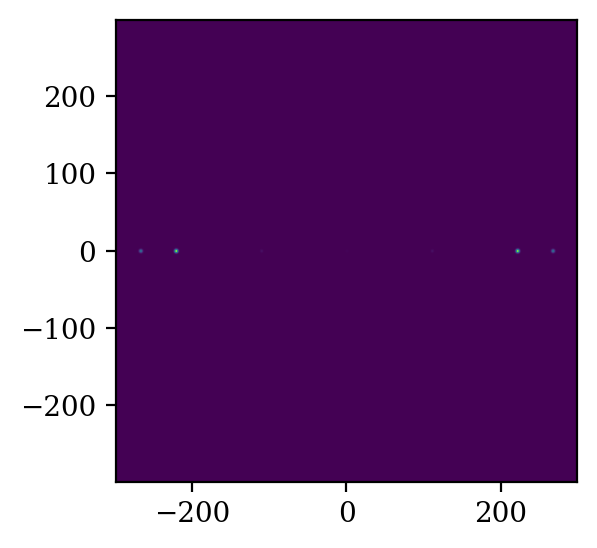

time = 16.5 ms
59.37003436087664 |psi|^2


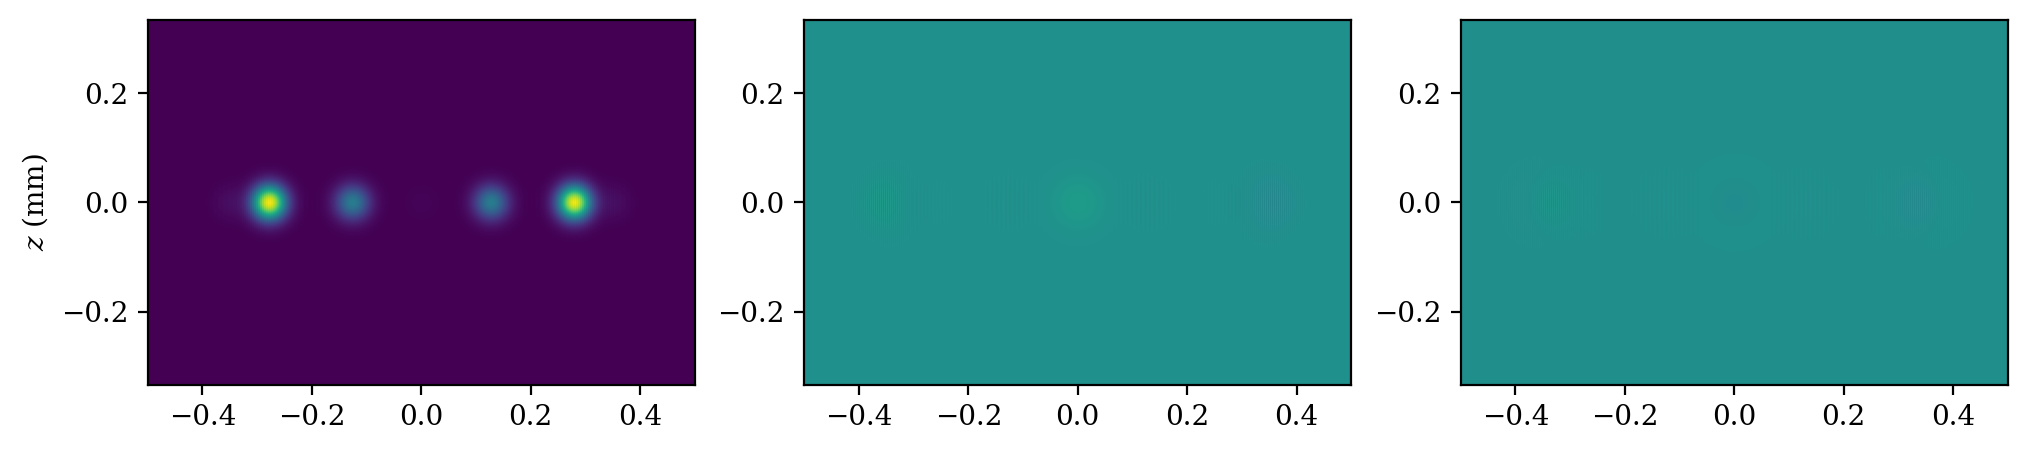

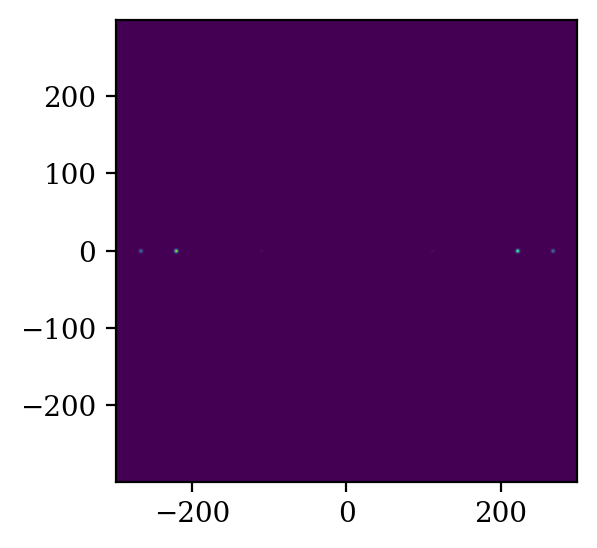

time = 17.0 ms
72.11373638022054 |psi|^2


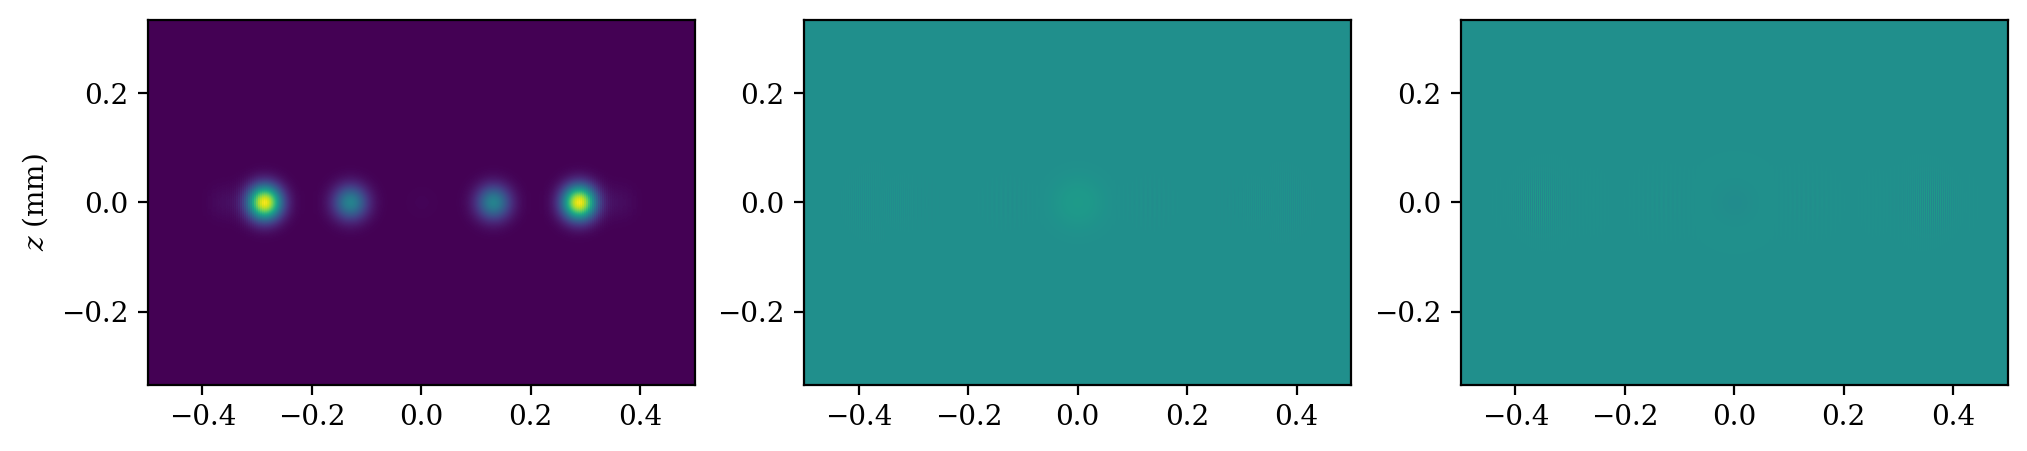

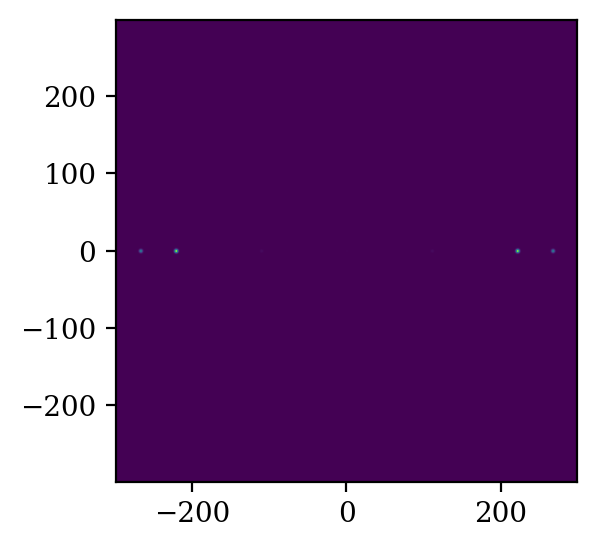

time = 17.5 ms
87.72683938437387 |psi|^2


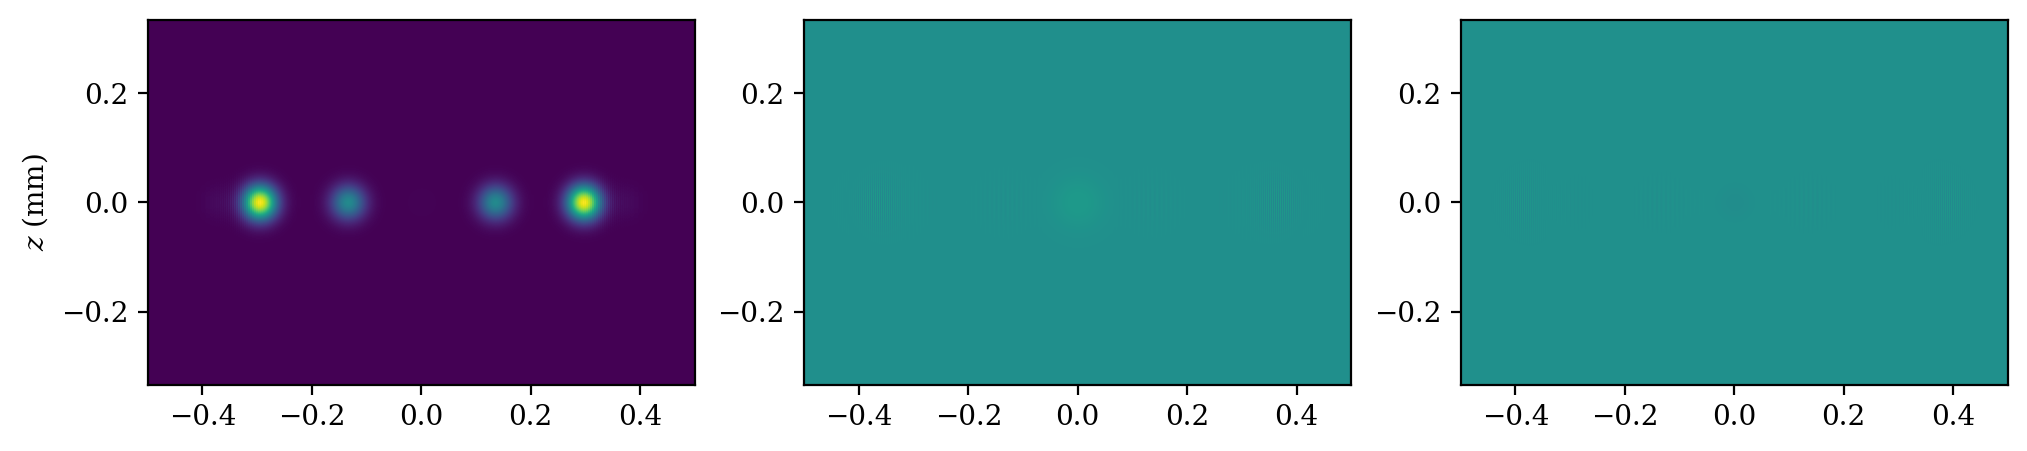

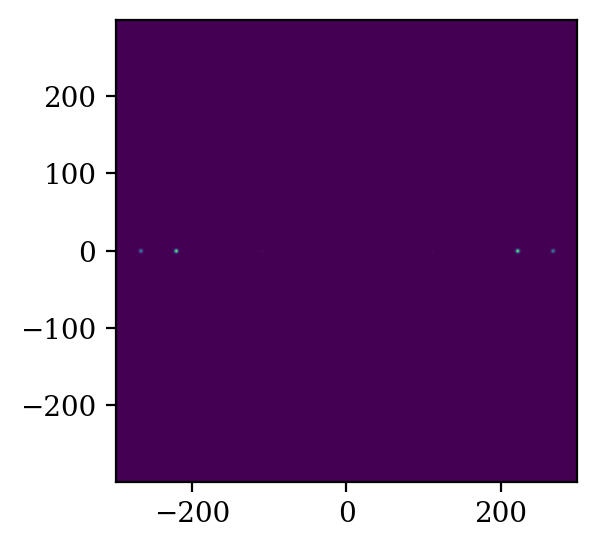

time = 18.0 ms
106.87336208922959 |psi|^2


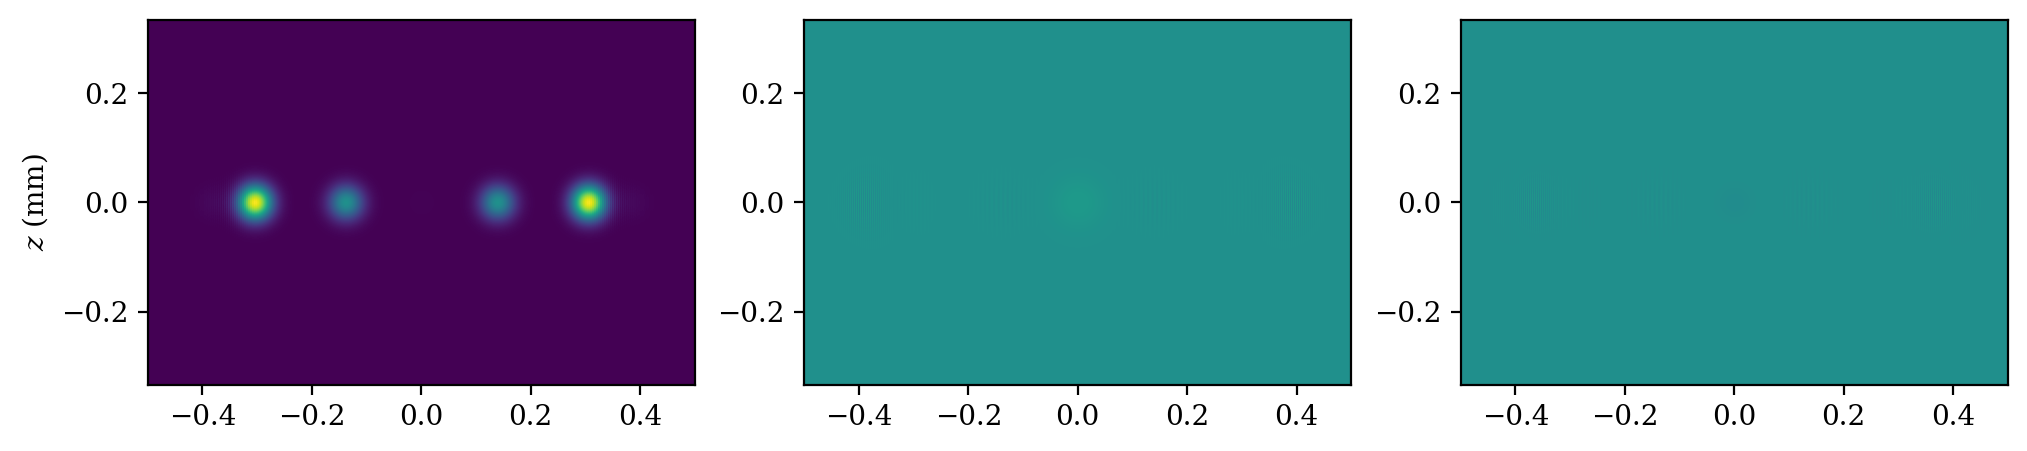

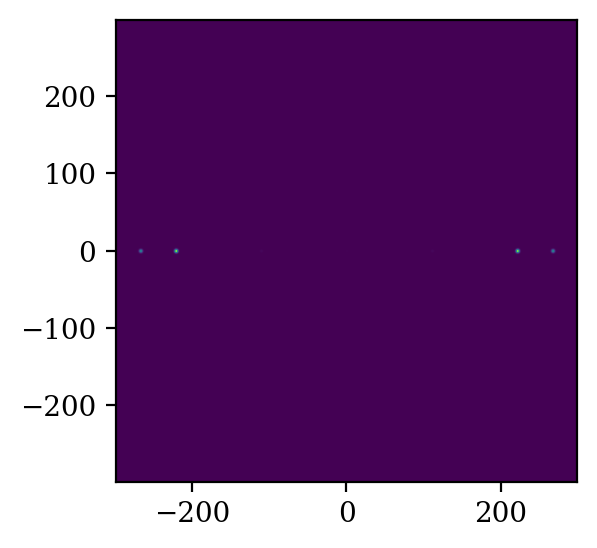

time = 18.5 ms
130.3749662753707 |psi|^2


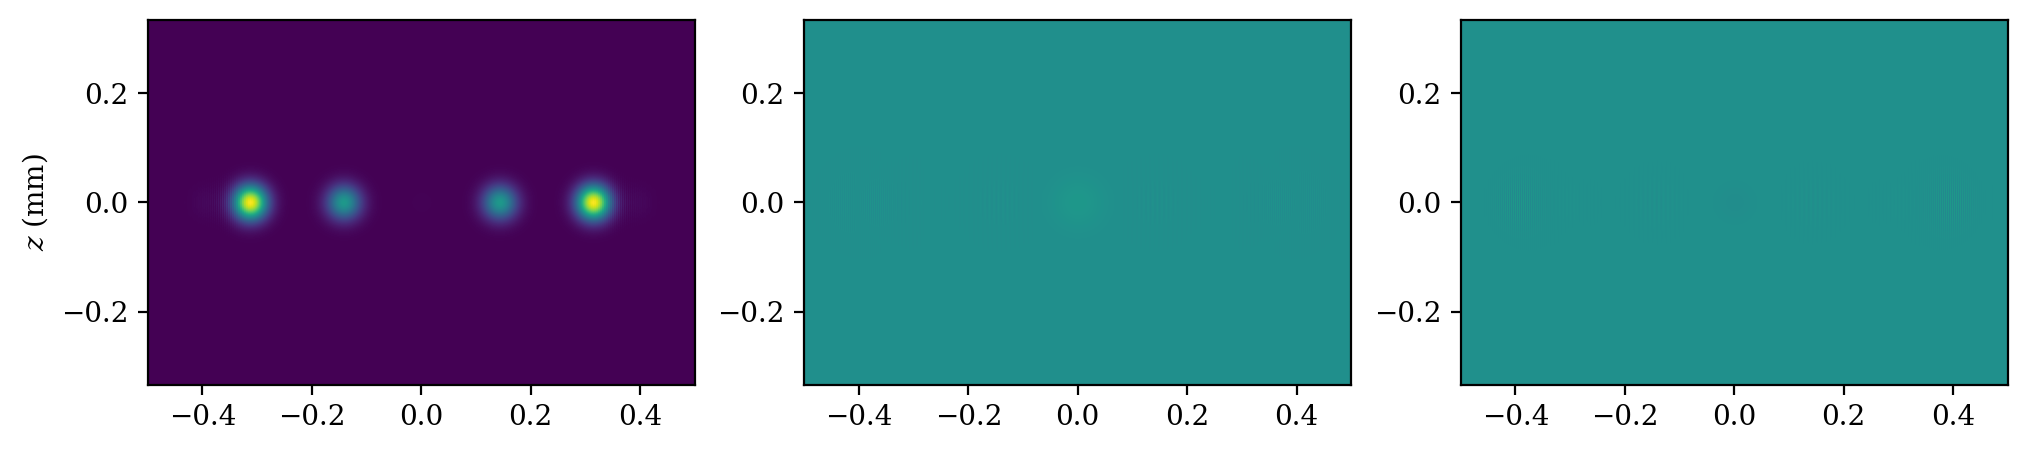

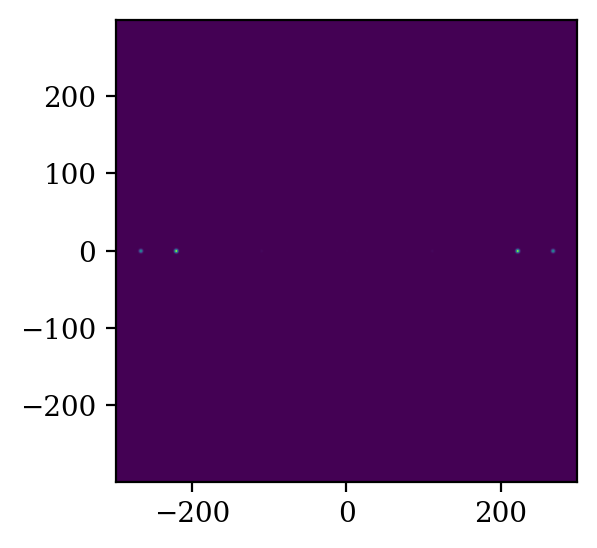

time = 19.0 ms
159.24930178416676 |psi|^2


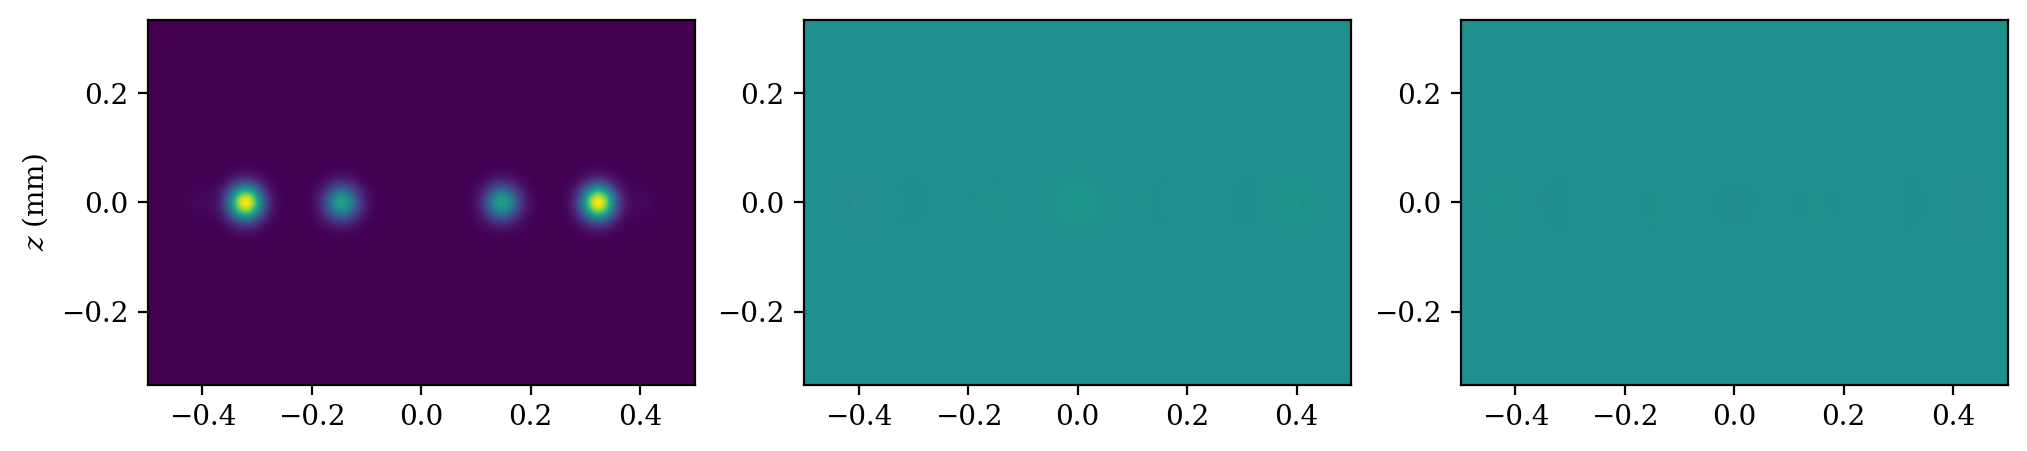

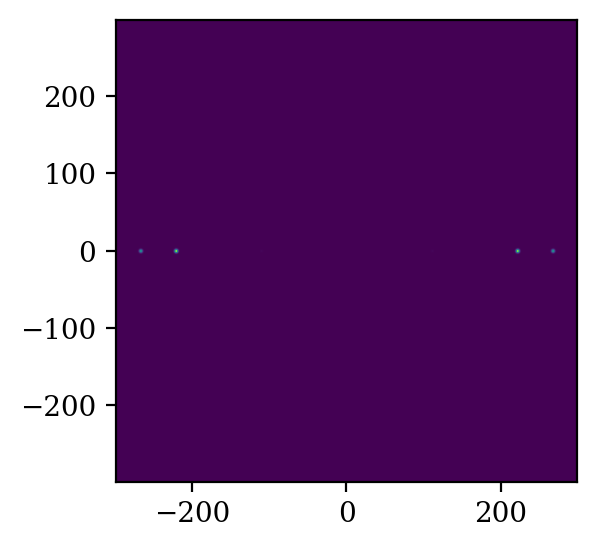

time = 19.5 ms
194.75788712932479 |psi|^2


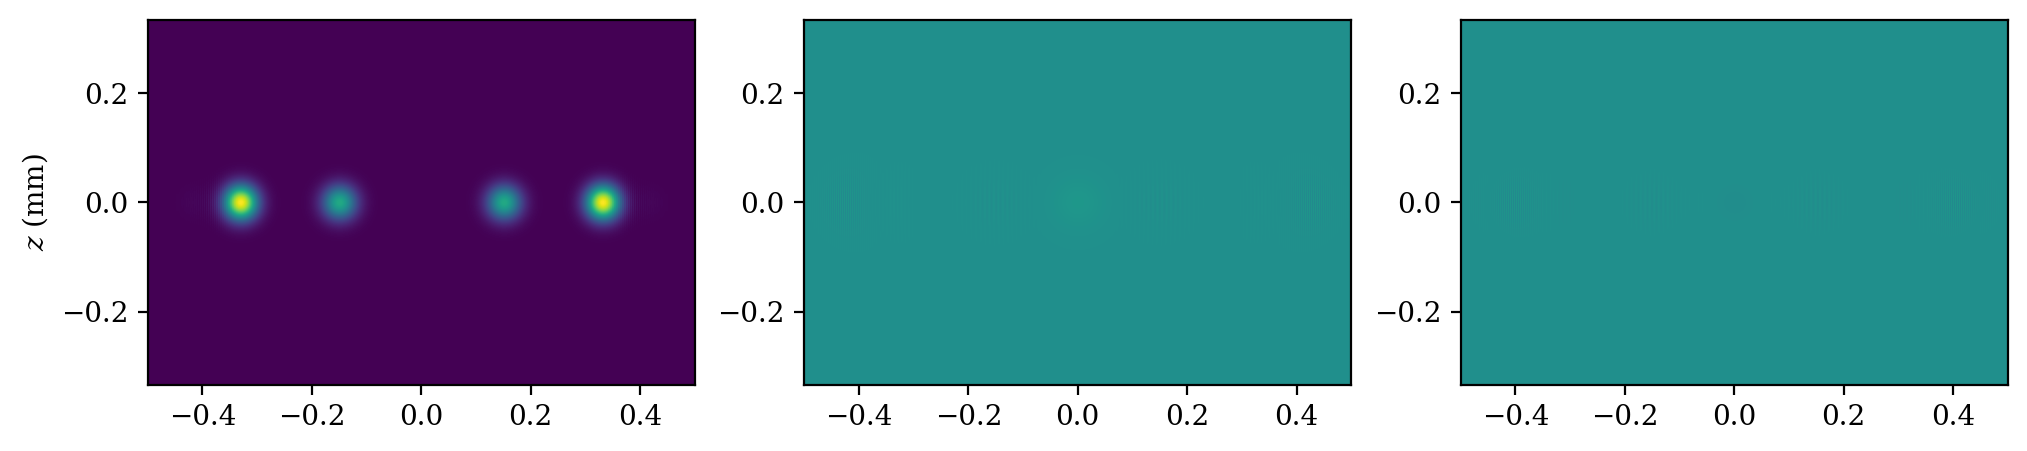

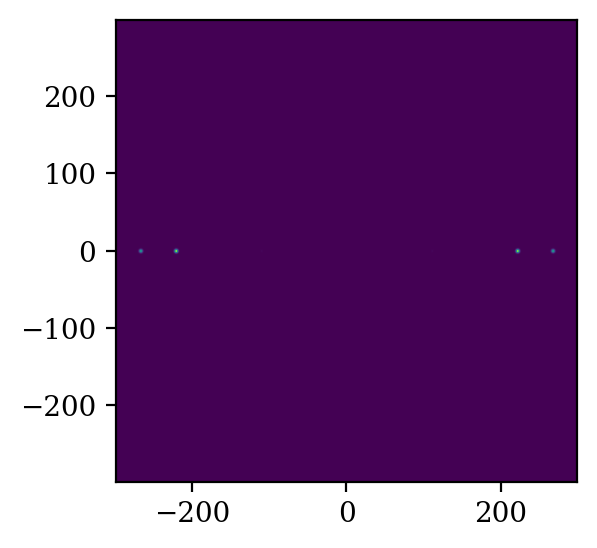

In [228]:
(t,psi) = runNBWithPlots(psi,t,20,0.5)

In [229]:
t

19.499999999967894